In [1]:
from __future__ import annotations
import os
import pprint
import logging
import time
import json
import itertools
import pathlib
import torch
import pandas as pd
import ragas
from ragas import evaluate
from dotenv import load_dotenv
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_weaviate import WeaviateVectorStore
from langchain_community.llms import Ollama
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.documents import Document
from langgraph.graph import START, END, StateGraph
from pydantic import BaseModel, Field, ValidationError
from langchain_ollama import OllamaLLM
import weaviate
from langchain.embeddings.base import Embeddings
from langchain_core.retrievers import BaseRetriever
from sentence_transformers import CrossEncoder, SentenceTransformer
from dataclasses import dataclass
from typing import List, Dict, Any, Optional, TypedDict
from datetime import datetime, timezone
from langsmith import Client
from langsmith.evaluation import evaluate as ls_evaluate, LangChainStringEvaluator
from ragas.metrics import (
    ContextRecall,
    Faithfulness,
    ContextPrecision,
    ResponseRelevancy,
    AnswerCorrectness,
    AnswerSimilarity,
    SemanticSimilarity
)
from datasets import Dataset

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
load_dotenv(override=True)

from IPython.display import display, HTML, Image
display(HTML("<style>.container { width:98;} </style>"))
device = "cuda" if torch.cuda.is_available() else "cpu"
# Para el aviso de Triton, pesos y otros transformers 
logging.getLogger("xformers").setLevel(logging.ERROR)

In [ ]:
WEAVIATE_URL = os.getenv('WEAVIATE_URL', 'http://localhost:8080')
LANGSMITH_API_KEY = os.getenv('LANGSMITH_API_KEY')
LANGSMITH_PROJECT = os.getenv('LANGSMITH_PROJECT', 'RAG-IDEArq')
LANGSMITH_TRACING = os.getenv('LANGSMITH_TRACING', 'true')
MISTRAL_API_KEY = os.getenv("MISTRAL_API_KEY")
# Configurar LangSmith
if LANGSMITH_API_KEY:
    os.environ["LANGCHAIN_TRACING_V2"] = "true"
    os.environ["LANGCHAIN_API_KEY"] = LANGSMITH_API_KEY
    os.environ["LANGCHAIN_PROJECT"] = LANGSMITH_PROJECT


RESULTS_DIR = pathlib.Path('./results')
RESULTS_DIR.mkdir(exist_ok=True)

print(f'LangSmith configurado: {LANGSMITH_API_KEY is not None}')
print(f'Proyecto: {LANGSMITH_PROJECT}')

LangSmith configurado: True
Proyecto: RAG-IDEArq


In [3]:
# Limpiar memoria GPU si está disponible
import gc
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()
    print(f'Memoria GPU limpiada')

Memoria GPU limpiada


## Configuración de modelos

Activamos los modelos LLM con Ollama:

In [ ]:
# ollama run hf.co/unsloth/Qwen3-4B-Instruct-2507-GGUF:Q8_0 
# ollama run hf.co/MaziyarPanahi/Phi-3.5-mini-instruct-GGUF:Q6_K 
# ollama run hf.co/bartowski/Llama-3.2-3B-Instruct-GGUF:Q8_0



In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Usando dispositivo para embeddings: {device}')
# embedding gte
model_kwargs = {
    'device': device,
    'trust_remote_code': True
}

'''Wrapper personalizado para el modelo de embeddings E5 Instruct.
   Añade prefijos específicos ("passage:" para documentos, "query:" para consultas) 
   Métodos:
    - embed_documents(): Procesa listas de documentos
    - embed_query(): Procesa una consulta individual
'''

class E5InstructEmbeddings(Embeddings):
    def __init__(self, model_name="intfloat/multilingual-e5-large-instruct", device=None):
        """Inicializa el modelo de embeddings E5 Instruct con prefijos específicos para documentos y queries."""
        if device is None:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        self.device = device
        self.model = SentenceTransformer(model_name, device=device)
    
    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        """Para documentos - añadir prefix 'passage:'"""
        prefixed_texts = [f"passage: {text}" for text in texts]
        return self.model.encode(prefixed_texts, device=self.device).tolist()
    
    def embed_query(self, text: str) -> List[float]:
        """Para queries - añadir prefix 'query:'"""
        prefixed_text = f"query: {text}"
        return self.model.encode([prefixed_text], device=self.device)[0].tolist()

LLM = {
    'Qwen3-4B-instruct-2507': OllamaLLM(model="hf.co/unsloth/Qwen3-4B-Instruct-2507-GGUF:Q8_0", temperatura = 0.5),
    'Llama-3.2-3B-instruct': OllamaLLM(model="hf.co/bartowski/Llama-3.2-3B-Instruct-GGUF:Q8_0", temperatura = 0.5),
    'Phi-3.5-mini-instruct': OllamaLLM(model="hf.co/MaziyarPanahi/Phi-3.5-mini-instruct-GGUF:Q6_K", temperatura = 0.5)
}

EMBEDDING_MODELS = {
    "all-MiniLM-L6-v2": HuggingFaceEmbeddings(
        model_name="sentence-transformers/all-MiniLM-L6-v2",
        model_kwargs={"device": device}),
    "e5-large-instruct": E5InstructEmbeddings(
        model_name="intfloat/multilingual-e5-large-instruct",
        device=device),
    "gte-multilingual-base": HuggingFaceEmbeddings(
        model_name="Alibaba-NLP/gte-multilingual-base",
        model_kwargs=model_kwargs)
}

# Cliente Weaviate
client = weaviate.connect_to_local(
    host="localhost",
    port=8080,
    grpc_port=50051
)

# Mapear embeddings a las clases de Weaviate
WEAVIATE_CLASSES = {
    'all-MiniLM-L6-v2': 'IdearqAllMiniLM',
    'e5-large-instruct': 'IdearqE5',
    'gte-multilingual-base': 'IdearqGTE'
}

Usando dispositivo para embeddings: cuda


<frozen importlib._bootstrap>:530: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.15; use exec_module() instead
Some weights of the model checkpoint at Alibaba-NLP/gte-multilingual-base were not used when initializing NewModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
PROMPTS = {
'prompt_zero_shot': """Eres un asistente experto en arqueología, historia y datos geoespaciales. Responde la pregunta usando los contextos proporcionados, que pueden estar en español, inglés, francés, catalán o portugués.
Sintetiza información de todos los contextos relevantes independientemente de su idioma. Si encuentras información relevante en cualquier idioma, úsala para construir tu respuesta en el mismo idioma en el que se realiza la pregunta.

Contexto: {context}

Pregunta: {question}

Instrucciones:
- Si encuentras información parcial en el contexto, intégrala en la respuesta aunque no sea completa.
- Si no hay absolutamente nada relevante, responde claramente: "No hay información suficiente en el contexto".
- No inventes ni alucines información fuera del contexto.
- Cuando sea posible, cita explícitamente los puntos clave del contexto (ej. autores, años, títulos de publicaciones, yacimientos, cronologías).
- Responde siempre de forma clara, estructurada y útil para un investigador.

Respuesta:""",

    'prompt_one_shot': """Eres un asistente experto en arqueología, historia y datos geoespaciales. Responde la pregunta usando los contextos proporcionados, que pueden estar en español, inglés, francés, catalán o portugués.
Sintetiza información de todos los contextos relevantes independientemente de su idioma. Si encuentras información relevante en cualquier idioma, úsala para construir tu respuesta en el mismo idioma en el que se realiza la pregunta.

Contexto: {context}

Pregunta: {question}

Instrucciones:
- Si encuentras información parcial en el contexto, intégrala en la respuesta aunque no sea completa.
- Si no hay absolutamente nada relevante, responde claramente: "No hay información suficiente en el contexto".
- No inventes ni alucines información fuera del contexto.
- Cuando sea posible, cita explícitamente los puntos clave del contexto (ej. autores, años, títulos de publicaciones, yacimientos, cronologías).
- Responde siempre de forma clara, estructurada y útil para un investigador.

Ejemplo:
Q: ¿Cuál es la utilidad de los análisis de isótopos de estroncio en Arqueología?
A: El tema del desplazamiento, la movilidad y la migración ha sido altamente destacado como uno de los cinco grandes retos de la investigación arqueológica contemporánea. El uso del análisis de isótopos de estroncio es hoy en día uno de los métodos más eficaces para afrontar este reto, ofreciendo un enfoque sistemático, cuantitativo y comparable a la movilidad de las poblaciones humanas y animales del pasado (Larsen 2018).

Respuesta:""",

    'prompt_few_shot': """Eres un asistente experto en arqueología, historia y datos geoespaciales. Responde la pregunta usando los contextos proporcionados, que pueden estar en español, inglés, francés, catalán o portugués.
Sintetiza información de todos los contextos relevantes independientemente de su idioma. Si encuentras información relevante en cualquier idioma, úsala para construir tu respuesta en el mismo idioma en el que se realiza la pregunta.
Contexto: {context}

Pregunta: {question}

Instrucciones:
- Si encuentras información parcial en el contexto, intégrala en la respuesta aunque no sea completa.
- Si no hay absolutamente nada relevante, responde claramente: "No hay información suficiente en el contexto".
- No inventes ni alucines información fuera del contexto.
- Cuando sea posible, cita explícitamente los puntos clave del contexto (ej. autores, años, títulos de publicaciones, yacimientos, cronologías).
- Responde siempre de forma clara, estructurada y útil para un investigador.

Ejemplos:
Q: ¿Cuál es la utilidad de los análisis de isótopos de estroncio en Arqueología?
A: El tema del desplazamiento, la movilidad y la migración ha sido altamente destacado como uno de los cinco grandes retos de la investigación arqueológica contemporánea. El uso del análisis de isótopos de estroncio es hoy en día uno de los métodos más eficaces para afrontar este reto, ofreciendo un enfoque sistemático, cuantitativo y comparable a la movilidad de las poblaciones humanas y animales del pasado (Larsen 2018).

Q: ¿Cuáles son las características de la distribución geográfica de la muestra disponible de análisis de isótopos de estroncio en la Península Ibérica?
A: La distribución de la muestra es variable y discontinua, con concentraciones asociadas a focos de investigación específicos (p. ej., Lisboa, valle del Ebro). La cobertura es irregular tanto geográfica como cronológicamente, lo que dificulta los estudios a escala ibérica para la mayoría de los periodos, a excepción de la Edad del Cobre (764 muestras). La escasez de datos es crítica en algunas épocas, como el Mesolítico, que cuenta con una única muestra. 

Respuesta:"""
}

selected_template = PROMPTS['prompt_few_shot']

prompt_template = ChatPromptTemplate.from_template(selected_template)

example_messages = prompt_template.invoke(
    {"context": "Contexto de ejemplo.", "question": "Pregunta de ejemplo."}
).to_messages()

# Results dir
RESULTS_DIR = pathlib.Path('./results')
RESULTS_DIR.mkdir(exist_ok=True)

Definimos el grafo.

In [6]:
# Estado del grafo con TypedDict
class State(TypedDict):
    question: str
    llm_name: str
    embedding_name: str
    prompt_name: str
    context: List[Document]
    answer: str
    metadata: Dict[str, Any]

# Clase para almacenar resultados con todas las métricas

from dataclasses import dataclass, field

@dataclass
class RunResultComplete:
    llm: str
    embedding: str
    prompt: str
    question: str
    answer: Optional[str]
    contexts: List[str]
    ground_truth: Optional[str]
    docs: List[Dict[str, Any]]
    latency: float
    metadata: Dict[str, Any]
    
    # Métricas RAGAS con LLM
    context_recall: Optional[float] = None
    faithfulness: Optional[float] = None
    context_precision: Optional[float] = None  
    response_relevancy: Optional[float] = None
    
    # Métricas RAGAS sin LLM
    answer_correctness: Optional[float] = None  
    semantic_similarity: Optional[float] = None
    exact_match: Optional[float] = None  
    
    # Métricas LangSmith con LLM
    ls_correctness: Optional[float] = None
    ls_helpfulness: Optional[float] = None
    ls_relevance: Optional[float] = None
    
    # Métricas LangSmith sin LLM
    ls_string_distance: Optional[float] = None
    ls_regex_match: Optional[float] = None

def retrieve(state: State):
    # Obtener el modelo de embedding correspondiente
    embedding_model = EMBEDDING_MODELS[state["embedding_name"]]     
    class_name = WEAVIATE_CLASSES[state["embedding_name"]]   

    vector_store = WeaviateVectorStore(
        client=client,
        index_name=class_name,
        text_key="content",
        embedding=embedding_model,
        attributes=["filename", "title", "source", "chunk_index", "doc_index"]
    )

    retrieved_docs = vector_store.similarity_search(state["question"], k = 10)
    #print(f"Recuperados {len(retrieved_docs)} docs para {state['embedding_name']}")
    return {"context": retrieved_docs}

def generate(state: State):
    print("    -> Entrando en el nodo 'generate'...")
    try:
        # 1. Preparamos el contexto y el prompt
        docs_content = "\\n\\n---\\n\\n".join(doc.page_content for doc in state["context"])
        template = PROMPTS[state["prompt_name"]]
        prompt = ChatPromptTemplate.from_template(template)
        
        # 2. Seleccionamos el LLM
        current_llm = LLM[state["llm_name"]]
        
        # --- INICIO DE DEPURACIÓN ---
        print(f"       - LLM a usar: {state['llm_name']}")
        print(f"       - Prompt a usar: {state['prompt_name']}")
        # Imprimimos solo los primeros 300 caracteres del contexto para no llenar la pantalla
        print(f"       - Contexto para el prompt (primeros 300 chars):\\n'{docs_content[:300]}...'")
        # --- FIN DE DEPURACIÓN ---

        # 3. Invocamos el LLM
        messages = prompt.invoke({"question": state["question"], "context": docs_content})
        response = current_llm.invoke(messages)
        
        print("    -> El LLM ha devuelto una respuesta.")
        
        latency = 0 
        metadata = { "latency": latency }

        return {"answer": response, "metadata": metadata}

    except Exception as e:
        print(f"    -> ERROR DENTRO DEL NODO 'generate': {e}")
        return {"answer": "", "metadata": {"error": str(e)}}

def extract_sources_from_docs(docs: List[Document]) -> List[Dict[str, Any]]:
    """Extraer metadatos de fuentes de los documentos"""
    sources = []
    for doc in docs:
        metadata = doc.metadata
        source_info = {
            'filename': metadata.get('filename', 'Unknown'),
            'title': metadata.get('title', metadata.get('doc_title', 'Sin título')),
            'page_content_preview': doc.page_content[:200] + "..."
        }
        sources.append(source_info)
    return sources

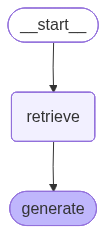

In [7]:
# Crear el grafo 
graph_builder = StateGraph(State)
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)

graph_builder.add_edge(START, "retrieve")
graph_builder.add_edge("retrieve", "generate")

graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

## Configurar la evaluación con RAGAS y LangSmith

## RAG pipeline

In [8]:
from itertools import product
from datasets import Dataset

# Preguntas y ground truths
questions = [
    'What are the main theoretical models of Neolithic expansion in Europe?',
    'Quais são as datas mais antigas da extração de sílex na península central?',
    '¿Cuáles son las cronologías de las manifestaciones funerarias del Mesolítico en las distintas regiones peninsulares?',
    'Principales yacimientos de la Segunda Edad del Hierro en la provincia de León.',
    'Periodización del Bronce Final en el Levante de la Península Ibérica, cronología de las fases y principales ejemplos de yacimientos asignados a las mismas.',
    'Yacimientos Calcolíticos de la Península Ibérica  en los que se han hallado objetos de marfil.',
    'Cronología y districubión espacial del poblamiento neolítixco en la Meseta Sur.',
    'Dataciones más antiguas para el megalitismo en la zona Sureste de la Península Ibérica.'
    'Excavaciones de urgencia de la Junta de Andalucía en la provincia de Almería publicadas en 2001.',
    '¿En qué año excavaron en el yacimiento de La Bastida de Totana los hermanos Siret?'
]
ground_truths = [
    """These can be divided into two main positions: the first, known as demic diffusion, emphasises the movement of Neolithic societies and, by extension, agricultural practices; the second, referred to in the literature as cultural diffusion, focuses on the importance of the transmission of the Neolithic package—technology (e.g., pottery), plants, and domesticated animals—as a trigger for the expansion of the Neolithic.""",
    """A única mina de sílex do Neolítico no centro de Espanha é a de Casamontero (Madrid). A série completa de datas de radiocarbono é apresentada na Fig. 3 e a sua distribuição espacial na Fig. 4 do artigo de Díaz del Río e Consuegra, 2015.
        Infelizmente, a amostra de Sus sp. não tinha colagénio suficiente para ser datada. O teste X2 mostra que todas as datas, com a única exceção da Beta-232890, são estatisticamente idênticas. Recentemente, foi enviada outra matriz de anel para datação num fragmento de fémur de Ovis aries. O resultado, 6200+/ -40 BP (Beta-295152), é estatisticamente igual a dez das onze datas anteriores.
       Assumindo a hipótese plausível de que elas datam diferentes eventos de mineração, há uma probabilidade de 65% de que todos os episódios de mineração tenham ocorrido entre 5327-5215 cal BC (1σ), um período de tempo de apenas cem anos. Portanto, estas datas de radiocarbono não permitem observar a evolução espácio-temporal da exploração mineira, mas indicam que o principal episódio de atividade da Casa Montero durou pouco mais de um século, quatro gerações. Esta interpretação não é apenas possível, é provável."""
    """Modelo construido a partir de muestras individuales de radiocarbono de esqueletos mesolíticos encontrados en los cementerios ibéricos. La diferencia más significativa entre la región mediterránea y la región cantábrica y Portugal se observa en la aparición de cementerios durante el Mesolítico temprano. Además, al evaluar los datos de las tres zonas de la Península Ibérica, se pueden identificar los siguientes patrones cronológicos.
        - En la región mediterránea, las fechas de El Collado muestran que los cementerios aparecieron alrededor de 9475-9300 cal BP. Este tipo de práctica funeraria continuará en otros yacimientos cercanos, como Casa Corona y Cingle del Mas Nou. A diferencia del cementerio de El Collado, que estuvo en uso durante unos 1100 años, según las fechas obtenidas, en Casa Corona y Cingle del Mas Nou, su periodo de uso es mucho más breve (8007-7583 cal BP). Además, Cingle del Mas Nou se diferencia de otros yacimientos funerarios mesolíticos de la Península Ibérica en que los restos de siete individuos (completos e incompletos) fueron depositados en una única estructura.
        - En la fachada atlántica de Portugal, las primeras pruebas de cementerios en el estuario de Muge datan de 8409-8030 cal BP (en Cabeço de Arruda, por ejemplo). Estos están asociados a grandes concheros de más de 5 m de espesor, utilizados durante un largo periodo de tiempo. En el estuario del Sado, las fechas son ligeramente más recientes que en Muge, comenzando alrededor del 8200 cal BP (por ejemplo, en Amoreiras). Está claro que entre el 8160 y el 7970 cal BP, los grupos mesolíticos enterraban sistemáticamente a todos o algunos de sus muertos en cementerios.
        - Por último, las fechas de los yacimientos funerarios del norte de la Península Ibérica (costa cantábrica) con dos o más individuos indican que los primeros enterramientos mesolíticos agrupados fueron un poco más recientes (entre 7981 y 6636 cal BP). En cualquier caso, cabe destacar que, a diferencia de las otras dos zonas, en la mayoría de los yacimientos solo se ha documentado un único individuo o grupos mucho más reducidos, como en Los Canes y La Braña."""
    """
        - Castro de la Edad de Hierro de Valencia de Don Juan
        - La Muela (al otro lado de la carretera de acceso a Valencia de Don Juan)
        - Antigua ciudad astur-romana de Lancia: otro de los grandes de oppida de la Segunda Edad del Hierro
        - Regueras de Arriba o San Martín de Torres.
        - En la zona cántabra, los castros laciniaegos de la Mesa en Rioscuro, que se delimita con una potente muralla de módulos, fechada seguramente en los siglos II y I a.C., y el castro de La Zamora, en sosas de Laciana.
        - También en la zona cántabra en el municipio de Puebla de Lillo se han podido reconocer ciertas piezas metalíticas de la Segunda Edad del Hierro, recogidas en el antiguo castro de Castiltejón. 
        - El castro de Chano en la comarca de Fornela.
        - Peña del Castro (La Ercina), ubicado a 2 km de la localidad de la Ercina 
        - El Castrelín de San Juan dse Paluezas
        - La Corona del Castro en Borrenes
        - La Peña del Hombre en el ayuntamiento de Priaranza
        - Castro de Columbrianos
        - Peña Piñera, en la Vega de Espinareda
        - Por último, se ha señalado un conjunto de castros en altitudes considerables en las sierras del Teleno, la Valdería y el Bierzo, algunos ya conocidos en la bibliografía y en la Carta Arqueológica de León, con grandes amurallamientos, que se extienden entre afloramientos rocosos de materiales de la era Primaria; yacimientos como Portillo de Xandequín en Pozos, Peña Rayada en Cunas, Alto de San Vicente-Los Conventos en Morla de la Valdería, Yera de los Piornos-Peña del Tren en Torneros de la Valdería, Sierra del Pueblo en Torneros de la Valdería, El Pajarín-La Formosida en Boisán (Lucillo) y los bercianos localizados en Folgoso de la Ribera, Torre del Bierzo y Molinaseca. """
    """Bronce tardío o reciente (c. 1550/1500-1300/1250 cal BC):
        - Oropesa la Vella
        - Torreló d’Onda
        - Les Raboses
        - Altet de Palau
        - Cap Prim
        - Mas del Corral
        - Cabezo Redondo
        - Peña de Sax
        - El Negret
        - Illeta del Banyets
        - Tabayá

    Bronce final I (c. 1300/1250-1000 cal BC):
        - Costamar
        - Oropesa la Vella
        - El Castellet
        - Torrelló de Boverot
        - Pic dels Corbs III y IV
        - Cova d’en Pardo
        - Cova de la Pastora
        - Cap Prim
        - Peña de Sax
        - El Negret
        - Tabayá
        - Botx-Grupitex

    Bronce final II (1000-850 cal BC):
        - Ereta del Castellar
        - El Castellet
        - Torrelló de Boverot
        - Pic dels Corbs V
        - Solana del Castell I
        - Mola d’Agres
        - Tabayá
        - Caramoro
        - Botx

    Bronce final III (850-725 cal BC):
        -Ereta del Castellar
        - El Castellet
        -Torrelló de Boverot
        -Vinarragell
        - La Vital
        -Solana del Castell II
        -Mola d’Agres
        -Cova de la Sarsa
        -Tabayá
        -Peña Negra I
        - Barranc del Botx
        -Saladares Ia1/IA2

    Hierro antiguo o fase Orientalizante (725-550 cal BC):
        - Vinarragell
        - El Molón
        - Los Villares
        - Solana del Castell III
        - El Castellar
        - El Puig
        - Camara
        - Tabayá
        - Peña Negra II
        - Casa Secà
        - Saladares IA3
""",
"""Calcolítico antiguo (pre-campaniforme [bell beaker]):
        - Zambujal
        - Vila Nova de São Pedro
        - Leceiaa
        - Praia das Maçãs
        - Palmela
        - Alcalar
        - Perdigões 
        - Señorío de Guzmán
        - La Pijotilla
        - Valencina de la Concepción
        - Gilena
        - Los Millares

Calcolítico reciente (campaniforme [bell beaker]):
        - Palmela
        - Pedra do Ouro
        - Verdelha dos Ruivos
        - Vila Nova de São Pedro
        - Perdigões
        - Valencina de la Concepción
        - Los Algarbes
        - Cerro de la Virgen
        - Camino de Yeseras
        - La Pijotilla
""",
"""Lo dividimos en dos áreas: poblamiento neolítico en el valle medio y alto del Tajo y poblamiento neolítico de La Mancha.
- Valle del Tajo: En la zona de la Sierra madrileña se localizan las cuevas la Cueva de La Ventana o la Cueva de la Higuera. Ambas son especialmente importantes para comprender los asentamientos en cueva, ya que disponen de dataciones radiocarbónicas asociadas a contextos de habitación. Ya en la provincia de Guadalajara destacan los yacimientos de la Cueva de la Hoz, Abrigo de Tordelrrábano  la Cueva de Jarama II, los enclaves de Sorbe II (Humanes de Mohernando), II y VII, la Cueva del Paso, el Abrigo de los Enebrales, Cueva del Reno y la Cueva del Destete.  Sin embargo, son los yacimientos de hoyos los que constituyen el principal modelo de asentamiento. Las excavaciones arqueológicas en extensión realizadas en los últimos años han puesto de manifiesto el predominio del hábitat en asentamientos al aire libre durante este periodo. Tan sólo se han documentado 8 enclaves neolíticos serranos de un total de 24 yacimientos cartografiados en la región. Los 16 yacimientos restantes se ubican en zonas bajas de los valles. A estas cifras hay que sumar tres nuevos yacimientos neolíticos: Soto del Henares, La Serna y Prado de Galápagos, recientemente publicados por C. Blasco et al.
(2016) que amplían el listado de asentamientos de hoyos ubicados en los fondos de
valle.
La concentración de yacimientos neolíticos es especialmente interesante en la zona sureste de la Comunidad de Madrid, en los tramos finales de los ríos Henares, Jarama y Manzanares. La densidad de yacimientos de hoyos neolíticos en las zonas bajas de estos cursos fluviales ha aportado desde hace años datos muy interesantes para conocer los patrones de asentamiento y los modelos de
ocupación territorial de las primeras comunidades neolíticas. 
- Poblamiento neolítico de La Mancha: El modelo de asentamiento neolítico mejor conocido en La Mancha son las ocupaciones en cuevas y abrigos. En este sentido, los yacimientos neolíticos manchegos mejor conocidos son la Cueva del Niño y el Abrigo de Molino de Vadico, en Albacete, y el Abrigo de Verdelpino, en Cuenca, a los que ya nos referimos en el capítulo anterior. En estos yacimientos se han documentado, además, ocupaciones previas, por lo que se son especialmente interesantes para estudiar el momento de adopción de los modos de vida neolíticos. 
En los últimos años se han realizado varias intervenciones arqueológicas en el contexto de las obras de construcción de grandes infraestructuras. Desde el punto de vista arqueológico, este tipo de intervenciones implican la prospección y, en su caso, excavación en zonas aleatorias afectadas por los proyectos constructivos, por lo que no se introducen sesgos relacionados con intereses científicos concretos. Por lo tanto, los hallazgos suponen una buena aproximación de la existencia o ausencia de distintos tipos de registro arqueológico. En este sentido, las obras de acceso al aeropuerto de Ciudad Real o los trabajos de la autopista que conecta Ocaña (Toledo) con La Roda (Ciudad Real), no aportaron hallazgos de asentamientos neolíticos. 
Si bien es cierto que las investigaciones sobre esta etapa de la Prehistoria en La Mancha han sido escasas y son pocos los equipos de investigación que han desarrollado líneas de investigación orientadas al conocimiento de las primeras sociedades productoras en esa región, no es menos cierto que las intervenciones arqueológicas llevadas a cabo en el contexto de obras de infraestructura en Castilla-La Mancha apoyan la idea de un poblamiento neolítico caracterizado por su escasa densidad, especialmente si se compara con otras regiones como en valle medio y alto del Tajo.
""",
"""Son el solar situado en la avenida Pablo Iglesias esquina A Rafaeka Jiménez, solar situado en la calle La central de Villaricos (cuevas de Almanzora) y en la calle Castillejo (Gador, Almería).""",
"""En el año 1886."""

]

EVALUACIÓN CON API MISTRAL

In [ ]:
from langchain_mistralai import ChatMistralAI
from ragas.metrics import context_precision, context_recall, faithfulness, answer_correctness
import time
from datasets import Dataset
from ragas import evaluate 
import pandas as pd
  # Configurar Mistral
mistral_evaluator = ChatMistralAI(
    api_key=MISTRAL_API_KEY,
    model="mistral-small-latest",
    temperature=0.1,
    max_retries=3,
    timeout= 180 # Timeout para las requests HTTP
    
)

# Prompts específicos para métricas
context_precision.context_precision_prompt.instruction = """
Dada una pregunta sobre arqueología y un conjunto de contextos que pueden estar en varios idiomas (español, inglés, francés, catalán, portugués), identifica qué contextos son útiles para responder la pregunta.
Los contextos pueden contener información técnica, fechas, yacimientos arqueológicos, cronologías, dataciones, etc. Un contexto es útil si contiene información relevante que ayude a responder la pregunta, aunque sea parcialmente, independientemente      
del idioma en que esté escrito.     

Pregunta: {question}
Contextos: {contexts}

Responde SOLO con un JSON válido en este formato exacto:
{"useful_contexts": [0, 1, 2]}
donde los números son los índices de contextos útiles.
"""

context_recall.context_recall_prompt.instruction = """
Dada una pregunta sobre arqueología y un conjunto de contextos que pueden estar en varios idiomas (español, inglés, francés, catalán, portugués), evalúa si el contexto contiene toda la información necesaria para responder la pregunta.
Los contextos pueden contener información técnica, fechas, yacimientos arqueológicos, cronologías, dataciones, etc. Un contexto es útil si contiene información relevante que ayude a responder la pregunta, aunque sea parcialmente, independientemente      
del idioma en que esté escrito.
Responde SOLO con un JSON válido en este formato exacto:
{"correctness": 0.8}
donde el valor está entre 0.0 y 1.0
"""  
print("Mistral configurado para RAGAS")

# Función de evaluación con Mistral y las 4 métricas

def evaluate_with_mistral_four_metrics(results_list, embedding_model, max_batch_size=2, delay_between_batches=90):
    """
    Evaluación RAGAS con Mistral API usando las 4 métricas principales
    """
    print(f"Evaluando {len(results_list)} preguntas con 4 métricas en batches de {max_batch_size}")

    all_batch_results = []
    total_batches = (len(results_list) + max_batch_size - 1) // max_batch_size

    for batch_idx in range(0, len(results_list), max_batch_size):
        batch_num = batch_idx // max_batch_size + 1
        batch = results_list[batch_idx:batch_idx + max_batch_size]

        print(f"   🔄 Procesando batch {batch_num}/{total_batches} ({len(batch)} preguntas)")

        # Crear dataset del batch
        batch_dataset = Dataset.from_list(batch)

        # Intentar evaluación con reintentos
        batch_success = False
        for attempt in range(3):
            try:
                print(f"      Intento {attempt + 1}/3 para batch {batch_num}")

                # Evaluar cada métrica por separado para mayor estabilidad
                batch_metrics = {}

                metrics_to_evaluate = [
                    ('context_precision', context_precision),
                    ('context_recall', context_recall),
                    ('faithfulness', faithfulness),
                    ('answer_correctness', answer_correctness)
                ]

                for metric_name, metric_obj in metrics_to_evaluate:
                    try:
                        print(f"         Evaluando {metric_name}...")

                        metric_result = evaluate(
                            batch_dataset,
                            llm=mistral_evaluator,
                            embeddings=embedding_model,
                            metrics=[metric_obj],
                            raise_exceptions=False
                        )

                        metric_df = metric_result.to_pandas()

                        if metric_name in metric_df.columns:
                            batch_metrics[metric_name] = metric_df[metric_name]
                            print(f"{metric_name} completado")
                        else:
                            batch_metrics[metric_name] = None
                            print(f"{metric_name} no encontrado en resultados")

                        # Pausa entre métricas para evitar rate limits
                        time.sleep(25)

                    except Exception as metric_error:
                        print(f"{metric_name} falló: {metric_error}")
                        batch_metrics[metric_name] = None
                        time.sleep(30)  # Pausa más larga si hay error

                # Crear DataFrame combinado del batch
                batch_result_df = pd.DataFrame({
                    'question': [item['question'] for item in batch],
                    'answer': [item['answer'] for item in batch],
                    'contexts': [item['contexts'] for item in batch],
                    'ground_truth': [item['ground_truth'] for item in batch],
                    'context_precision': batch_metrics.get('context_precision'),
                    'context_recall': batch_metrics.get('context_recall'),
                    'faithfulness': batch_metrics.get('faithfulness'),
                    'answer_correctness': batch_metrics.get('answer_correctness')
                })

                all_batch_results.append(batch_result_df)
                batch_success = True
                print(f"Batch {batch_num} completado con 4 métricas")
                break

            except Exception as batch_error:
                print(f"Batch {batch_num}, intento {attempt + 1} falló: {batch_error}")
                if attempt < 2:
                    wait_time = 120 * (attempt + 1)  # Espera más larga para 4 métricas
                    print(f"         Esperando {wait_time}s antes del siguiente intento...")
                    time.sleep(wait_time)

        if not batch_success:
            print(f"Batch {batch_num} falló después de 3 intentos, creando resultados vacíos")
            # Crear DataFrame vacío para este batch
            empty_batch_df = pd.DataFrame({
                'question': [item['question'] for item in batch],
                'answer': [item['answer'] for item in batch],
                'contexts': [item['contexts'] for item in batch],
                'ground_truth': [item['ground_truth'] for item in batch],
                'context_precision': [None] * len(batch),
                'context_recall': [None] * len(batch),
                'faithfulness': [None] * len(batch),
                'answer_correctness': [None] * len(batch)
            })
            all_batch_results.append(empty_batch_df)

        # Rate limiting: pausa entre batches (más larga para 4 métricas)
        if batch_num < total_batches:
            print(f"Esperando {delay_between_batches}s antes del siguiente batch...")
            time.sleep(delay_between_batches)

    # Combinar todos los resultados
    if all_batch_results:
        combined_results = pd.concat(all_batch_results, ignore_index=True)
        print(f"Evaluación completada: {len(combined_results)} preguntas con 4 métricas")
        return combined_results
    else:
        print(f"No se pudieron procesar resultados")
        return pd.DataFrame()

Mistral configurado para RAGAS


In [10]:
# Evaluar TODAS las combinaciones: 3 prompts × 3 embeddings = 9 combinaciones
resultados_completos = {}

prompts_list = ['prompt_zero_shot', 'prompt_one_shot', 'prompt_few_shot']

for prompt_name in prompts_list:
    print(f"\nEVALUANDO CON PROMPT: {prompt_name}")
    print("="*80)
    # CAMBIAR EL TEMPLATE GLOBAL (esto es lo clave)
    selected_template = PROMPTS[prompt_name]
    prompt_template = ChatPromptTemplate.from_template(selected_template)

    # Generar respuestas con este prompt específico
    results_list_prompt = []

    # Necesitas generar las respuestas con tu grafo de LangGraph primero
    print("Generando respuestas con LangGraph...")

    for i, (question, ground_truth) in enumerate(zip(questions, ground_truths)):
        print(f"Procesando pregunta {i+1}/{len(questions)} con {prompt_name}")


        state = {
            'question': question,
            'llm_name': 'Qwen3-4B-instruct-2507',  
            'embedding_name': 'all-MiniLM-L6-v2',  # Se cambiará en el bucle    
            'prompt_name': prompt_name,
            'context': [],
            'answer': '',
            'metadata': {}
        }
        try:
        
            final_state = graph.invoke(state)
            answer = final_state.get('answer', '')
            contexts = final_state.get('context', [])

            if answer and answer.strip():  # Verificar que hay respuesta
                  results_list_prompt.append({
                      'question': question,
                      'answer': answer,
                      'contexts': [doc.page_content for doc in contexts] if contexts else ['Sin contexto'],
                      'ground_truth': ground_truth
                  })
            else:
                  print(f"      ⚠️ Pregunta {i+1} sin respuesta válida")

        except Exception as e:
            print(f"      ❌ Error en pregunta {i+1}: {e}")

    print(f"Respuestas válidas generadas con {prompt_name}: {len(results_list_prompt)}")

    # Solo evaluar si tenemos respuestas válidas
    if len(results_list_prompt) >= 2:
          # EVALUAR CON LOS 3 EMBEDDINGS
        resultados_por_embedding = {}

        for embedding_name, current_embedding_model in EMBEDDING_MODELS.items():
            print(f"\nEVALUANDO: {prompt_name} + {embedding_name}")
            print("-"*60)

            resultado = evaluate_with_mistral_four_metrics(
                results_list=results_list_prompt,
                  embedding_model=current_embedding_model,
                  max_batch_size=2,
                  delay_between_batches=120
            )

            resultados_por_embedding[embedding_name] = resultado

              # Mostrar métricas promedio
            print(f"\nCOMBINACIÓN: {prompt_name} + {embedding_name}")
            for metric in ['context_precision', 'context_recall', 'faithfulness', 'answer_correctness']:
                if metric in resultado.columns:
                    valores = resultado[metric].dropna()
                    if len(valores) > 0:
                        print(f"   {metric}: {valores.mean():.3f}")
                    else:
                        print(f"   {metric}: Sin valores válidos")

            time.sleep(90)  # Pausa entre embeddings

          # Guardar resultados de este prompt
        resultados_completos[prompt_name] = resultados_por_embedding

    else:
        print(f"No hay suficientes respuestas válidas para {prompt_name}, saltando evaluación")

    if prompt_name != prompts_list[-1]:
        print(f"\nPAUSA ENTRE PROMPTS: 300 segundos...")
        time.sleep(300)

print("\"EVALUACIÓN COMPLETA")

  # Mostrar tabla final
print("\nTABLA DE RESULTADOS:")
print("="*100)

for prompt_name, embeddings_results in resultados_completos.items():
    print(f"\nPROMPT: {prompt_name}")
    for embedding_name, resultado in embeddings_results.items():
        print(f"{embedding_name}:")
        for metric in ['context_precision', 'context_recall', 'faithfulness', 'answer_correctness']:
            if metric in resultado.columns:
                valores = resultado[metric].dropna()
                if len(valores) > 0:
                    print(f"      {metric}: {valores.mean():.3f}")


EVALUANDO CON PROMPT: prompt_zero_shot
Generando respuestas con LangGraph...
Procesando pregunta 1/9 con prompt_zero_shot
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Published by Elsevier Inc. All rights reserved. doi:10.1016/j.yqres.2011.12.003 Contents lists available at SciVerse ScienceDirect Quaternary Research journal homepage: www.elsevier.com/locate/yqres https://doi.org/10.1016/j.yqres.2011.12.003 Published online by Cambridge University Press Introduc...'
    -> El LLM ha devuelto una respuesta.
Procesando pregunta 2/9 con prompt_zero_shot
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. A data obtida, é claramente mais recuada que os con­ textos mais antigos reportados em território hoje portu­ guês, no

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\_analytics.py:77: ResourceWarning: unclosed file <_io.TextIOWrapper name='C:\\Users\\elevi\\AppData\\Local\\ragas\\ragas\\uuid.json' mode='r' encoding='cp1252'>
  user_id = json.load(open(uuid_filepath))["userid"]


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 1 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 2/3 (2 preguntas)
      Intento 1/3 para batch 2
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 2 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 3/3 (2 preguntas)
      Intento 1/3 para batch 3
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 3 completado con 4 métricas
Evaluación completada: 6 preguntas con 4 métricas

COMBINACIÓN: prompt_zero_shot + all-MiniLM-L6-v2
   context_precision: 0.475
   context_recall: 0.106
   faithfulness: 0.903
   answer_correctness: 0.275

EVALUANDO: prompt_zero_shot + e5-large-instruct
------------------------------------------------------------
Evaluando 6 preguntas con 4 métricas en batches de 2
   🔄 Procesando batch 1/3 (2 preguntas)
      Intento 1/3 para batch 1
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 1 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 2/3 (2 preguntas)
      Intento 1/3 para batch 2
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 2 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 3/3 (2 preguntas)
      Intento 1/3 para batch 3
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 3 completado con 4 métricas
Evaluación completada: 6 preguntas con 4 métricas

COMBINACIÓN: prompt_zero_shot + e5-large-instruct
   context_precision: 0.387
   context_recall: 0.087
   faithfulness: 0.880
   answer_correctness: 0.242

EVALUANDO: prompt_zero_shot + gte-multilingual-base
------------------------------------------------------------
Evaluando 6 preguntas con 4 métricas en batches de 2
   🔄 Procesando batch 1/3 (2 preguntas)
      Intento 1/3 para batch 1
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 1 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 2/3 (2 preguntas)
      Intento 1/3 para batch 2
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 2 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 3/3 (2 preguntas)
      Intento 1/3 para batch 3
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 3 completado con 4 métricas
Evaluación completada: 6 preguntas con 4 métricas

COMBINACIÓN: prompt_zero_shot + gte-multilingual-base
   context_precision: 0.417
   context_recall: 0.304
   faithfulness: 0.844
   answer_correctness: 0.162

PAUSA ENTRE PROMPTS: 300 segundos...

EVALUANDO CON PROMPT: prompt_one_shot
Generando respuestas con LangGraph...
Procesando pregunta 1/9 con prompt_one_shot
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Published by Elsevier Inc. All rights reserved. doi:10.1016/j.yqres.2011.12.003 Contents lists available at SciVerse ScienceDirect Quaternary Research journal homepage: www.elsevier.com/locate/yqres https://doi.org/10.1016/j.yqres.2011.12.003 Published online by Cambridge University Press Introduc...'
    -> El LLM ha devuelto una respuesta.
Procesando pregunta 2/9 con prompt_one_

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 1 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 2/3 (2 preguntas)
      Intento 1/3 para batch 2
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 2 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 3/3 (2 preguntas)
      Intento 1/3 para batch 3
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 3 completado con 4 métricas
Evaluación completada: 6 preguntas con 4 métricas

COMBINACIÓN: prompt_one_shot + all-MiniLM-L6-v2
   context_precision: 0.395
   context_recall: 0.143
   faithfulness: 0.763
   answer_correctness: 0.187

EVALUANDO: prompt_one_shot + e5-large-instruct
------------------------------------------------------------
Evaluando 6 preguntas con 4 métricas en batches de 2
   🔄 Procesando batch 1/3 (2 preguntas)
      Intento 1/3 para batch 1
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 1 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 2/3 (2 preguntas)
      Intento 1/3 para batch 2
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 2 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 3/3 (2 preguntas)
      Intento 1/3 para batch 3
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 3 completado con 4 métricas
Evaluación completada: 6 preguntas con 4 métricas

COMBINACIÓN: prompt_one_shot + e5-large-instruct
   context_precision: 0.340
   context_recall: 0.342
   faithfulness: 0.742
   answer_correctness: 0.287

EVALUANDO: prompt_one_shot + gte-multilingual-base
------------------------------------------------------------
Evaluando 6 preguntas con 4 métricas en batches de 2
   🔄 Procesando batch 1/3 (2 preguntas)
      Intento 1/3 para batch 1
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 1 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 2/3 (2 preguntas)
      Intento 1/3 para batch 2
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 2 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 3/3 (2 preguntas)
      Intento 1/3 para batch 3
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 3 completado con 4 métricas
Evaluación completada: 6 preguntas con 4 métricas

COMBINACIÓN: prompt_one_shot + gte-multilingual-base
   context_precision: 0.315
   context_recall: 0.092
   faithfulness: 0.747
   answer_correctness: 0.212

PAUSA ENTRE PROMPTS: 300 segundos...

EVALUANDO CON PROMPT: prompt_few_shot
Generando respuestas con LangGraph...
Procesando pregunta 1/9 con prompt_few_shot
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Published by Elsevier Inc. All rights reserved. doi:10.1016/j.yqres.2011.12.003 Contents lists available at SciVerse ScienceDirect Quaternary Research journal homepage: www.elsevier.com/locate/yqres https://doi.org/10.1016/j.yqres.2011.12.003 Published online by Cambridge University Press Introduc...'
    -> El LLM ha devuelto una respuesta.
Procesando pregunta 2/9 con prompt_few_s

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 1 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 2/3 (2 preguntas)
      Intento 1/3 para batch 2
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 2 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 3/3 (2 preguntas)
      Intento 1/3 para batch 3
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 3 completado con 4 métricas
Evaluación completada: 6 preguntas con 4 métricas

COMBINACIÓN: prompt_few_shot + all-MiniLM-L6-v2
   context_precision: 0.228
   context_recall: 0.300
   faithfulness: 0.657
   answer_correctness: 0.149

EVALUANDO: prompt_few_shot + e5-large-instruct
------------------------------------------------------------
Evaluando 6 preguntas con 4 métricas en batches de 2
   🔄 Procesando batch 1/3 (2 preguntas)
      Intento 1/3 para batch 1
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 1 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 2/3 (2 preguntas)
      Intento 1/3 para batch 2
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 2 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 3/3 (2 preguntas)
      Intento 1/3 para batch 3
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 3 completado con 4 métricas
Evaluación completada: 6 preguntas con 4 métricas

COMBINACIÓN: prompt_few_shot + e5-large-instruct
   context_precision: 0.356
   context_recall: 0.088
   faithfulness: 0.587
   answer_correctness: 0.236

EVALUANDO: prompt_few_shot + gte-multilingual-base
------------------------------------------------------------
Evaluando 6 preguntas con 4 métricas en batches de 2
   🔄 Procesando batch 1/3 (2 preguntas)
      Intento 1/3 para batch 1
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 1 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 2/3 (2 preguntas)
      Intento 1/3 para batch 2
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 2 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 3/3 (2 preguntas)
      Intento 1/3 para batch 3
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 3 completado con 4 métricas
Evaluación completada: 6 preguntas con 4 métricas

COMBINACIÓN: prompt_few_shot + gte-multilingual-base
   context_precision: 0.437
   context_recall: 0.096
   faithfulness: 0.721
   answer_correctness: 0.181
"EVALUACIÓN COMPLETA

TABLA DE RESULTADOS:

PROMPT: prompt_zero_shot
all-MiniLM-L6-v2:
      context_precision: 0.475
      context_recall: 0.106
      faithfulness: 0.903
      answer_correctness: 0.275
e5-large-instruct:
      context_precision: 0.387
      context_recall: 0.087
      faithfulness: 0.880
      answer_correctness: 0.242
gte-multilingual-base:
      context_precision: 0.417
      context_recall: 0.304
      faithfulness: 0.844
      answer_correctness: 0.162

PROMPT: prompt_one_shot
all-MiniLM-L6-v2:
      context_precision: 0.395
      context_recall: 0.143
      faithfulness: 0.763
      answer_correctness: 0.187
e5-large-instruct:
      context_precision: 0.340
      context_recall: 0.342
      fai

In [ ]:
# Evaluar TODAS las combinaciones: 3 prompts × 3 embeddings = 9 combinaciones
resultados_completos = {}

prompts_list = ['prompt_zero_shot', 'prompt_one_shot', 'prompt_few_shot']

for prompt_name in prompts_list:
    print(f"\nEVALUANDO CON PROMPT: {prompt_name}")
    print("="*80)
    # CAMBIAR EL TEMPLATE GLOBAL (esto es lo clave)




    
    selected_template = PROMPTS[prompt_name]
    prompt_template = ChatPromptTemplate.from_template(selected_template)

    # Generar respuestas con este prompt específico
    results_list_prompt = []

    # Necesitas generar las respuestas con tu grafo de LangGraph primero
    print("Generando respuestas con LangGraph...")

    for i, (question, ground_truth) in enumerate(zip(questions, ground_truths)):
        print(f"Procesando pregunta {i+1}/{len(questions)} con {prompt_name}")

        # Aquí usas tu grafo de LangGraph para generar la respuesta
        state = {
            'question': question,
            'llm_name': 'Phi-3.5-mini-instruct',  # Tu LLM de generación
            'embedding_name': 'all-MiniLM-L6-v2',  # Se cambiará en el bucle    
            'prompt_name': prompt_name,
            'context': [],
            'answer': '',
            'metadata': {}
        }
        try:
            # INVOCAR TU GRAFO (ajusta según tu código)
            final_state = graph.invoke(state)
            answer = final_state.get('answer', '')
            contexts = final_state.get('context', [])

            if answer and answer.strip():  # Verificar que hay respuesta
                  results_list_prompt.append({
                      'question': question,
                      'answer': answer,
                      'contexts': [doc.page_content for doc in contexts] if contexts else ['Sin contexto'],
                      'ground_truth': ground_truth
                  })
            else:
                  print(f"Pregunta {i+1} sin respuesta válida")

        except Exception as e:
            print(f"Error en pregunta {i+1}: {e}")

    print(f"Respuestas válidas generadas con {prompt_name}: {len(results_list_prompt)}")

      # Solo evaluar si tenemos respuestas válidas
    if len(results_list_prompt) >= 2:
          # EVALUAR CON LOS 3 EMBEDDINGS
        resultados_por_embedding = {}

        for embedding_name, current_embedding_model in EMBEDDING_MODELS.items():
            print(f"\nEVALUANDO: {prompt_name} + {embedding_name}")
            print("-"*60)

            resultado = evaluate_with_mistral_four_metrics(
                results_list=results_list_prompt,
                  embedding_model=current_embedding_model,
                  max_batch_size=2,
                  delay_between_batches=120
            )

            resultados_por_embedding[embedding_name] = resultado

              # Mostrar métricas promedio
            print(f"\nCOMBINACIÓN: {prompt_name} + {embedding_name}")
            for metric in ['context_precision', 'context_recall', 'faithfulness', 'answer_correctness']:
                if metric in resultado.columns:
                    valores = resultado[metric].dropna()
                    if len(valores) > 0:
                        print(f"   {metric}: {valores.mean():.3f}")
                    else:
                        print(f"   {metric}: Sin valores válidos")

            time.sleep(90)  # Pausa entre embeddings

          # Guardar resultados de este prompt
        resultados_completos[prompt_name] = resultados_por_embedding

    else:
        print(f"No hay suficientes respuestas válidas para {prompt_name}, saltando evaluación")

    if prompt_name != prompts_list[-1]:
        print(f"\nPAUSA ENTRE PROMPTS: 300 segundos...")
        time.sleep(300)

print("\"EVALUACIÓN COMPLETA")

  # Mostrar tabla final
print("\nTABLA DE RESULTADOS:")
print("="*100)

for prompt_name, embeddings_results in resultados_completos.items():
    print(f"\nPROMPT: {prompt_name}")
    for embedding_name, resultado in embeddings_results.items():
        print(f"{embedding_name}:")
        for metric in ['context_precision', 'context_recall', 'faithfulness', 'answer_correctness']:
            if metric in resultado.columns:
                valores = resultado[metric].dropna()
                if len(valores) > 0:
                    print(f"      {metric}: {valores.mean():.3f}")


EVALUANDO CON PROMPT: prompt_zero_shot
Generando respuestas con LangGraph...
Procesando pregunta 1/9 con prompt_zero_shot
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Phi-3.5-mini-instruct
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Published by Elsevier Inc. All rights reserved. doi:10.1016/j.yqres.2011.12.003 Contents lists available at SciVerse ScienceDirect Quaternary Research journal homepage: www.elsevier.com/locate/yqres https://doi.org/10.1016/j.yqres.2011.12.003 Published online by Cambridge University Press Introduc...'
    -> El LLM ha devuelto una respuesta.
Procesando pregunta 2/9 con prompt_zero_shot
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Phi-3.5-mini-instruct
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. A data obtida, é claramente mais recuada que os con­ textos mais antigos reportados em território hoje portu­ guês, nome

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\_analytics.py:77: ResourceWarning: unclosed file <_io.TextIOWrapper name='C:\\Users\\elevi\\AppData\\Local\\ragas\\ragas\\uuid.json' mode='r' encoding='cp1252'>
  user_id = json.load(open(uuid_filepath))["userid"]


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 1 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 2/3 (2 preguntas)
      Intento 1/3 para batch 2
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 2 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 3/3 (2 preguntas)
      Intento 1/3 para batch 3
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 3 completado con 4 métricas
Evaluación completada: 6 preguntas con 4 métricas

📊 COMBINACIÓN: prompt_zero_shot + all-MiniLM-L6-v2
   context_precision: 0.404
   context_recall: 0.106
   faithfulness: 0.705
   answer_correctness: 0.179

🔄 EVALUANDO: prompt_zero_shot + e5-large-instruct
------------------------------------------------------------
Evaluando 6 preguntas con 4 métricas en batches de 2
   🔄 Procesando batch 1/3 (2 preguntas)
      Intento 1/3 para batch 1
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 1 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 2/3 (2 preguntas)
      Intento 1/3 para batch 2
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 2 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 3/3 (2 preguntas)
      Intento 1/3 para batch 3
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 3 completado con 4 métricas
Evaluación completada: 6 preguntas con 4 métricas

📊 COMBINACIÓN: prompt_zero_shot + e5-large-instruct
   context_precision: 0.458
   context_recall: 0.148
   faithfulness: 0.772
   answer_correctness: 0.266

🔄 EVALUANDO: prompt_zero_shot + gte-multilingual-base
------------------------------------------------------------
Evaluando 6 preguntas con 4 métricas en batches de 2
   🔄 Procesando batch 1/3 (2 preguntas)
      Intento 1/3 para batch 1
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 1 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 2/3 (2 preguntas)
      Intento 1/3 para batch 2
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 2 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 3/3 (2 preguntas)
      Intento 1/3 para batch 3
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 3 completado con 4 métricas
Evaluación completada: 6 preguntas con 4 métricas

📊 COMBINACIÓN: prompt_zero_shot + gte-multilingual-base
   context_precision: 0.475
   context_recall: 0.239
   faithfulness: 0.733
   answer_correctness: 0.148

⏱️ PAUSA ENTRE PROMPTS: 300 segundos...

EVALUANDO CON PROMPT: prompt_one_shot
Generando respuestas con LangGraph...
Procesando pregunta 1/9 con prompt_one_shot
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Phi-3.5-mini-instruct
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Published by Elsevier Inc. All rights reserved. doi:10.1016/j.yqres.2011.12.003 Contents lists available at SciVerse ScienceDirect Quaternary Research journal homepage: www.elsevier.com/locate/yqres https://doi.org/10.1016/j.yqres.2011.12.003 Published online by Cambridge University Press Introduc...'
    -> El LLM ha devuelto una respuesta.
Procesando pregunta 2/9 con prompt_

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 1 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 2/3 (2 preguntas)
      Intento 1/3 para batch 2
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 2 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 3/3 (2 preguntas)
      Intento 1/3 para batch 3
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 3 completado con 4 métricas
Evaluación completada: 6 preguntas con 4 métricas

📊 COMBINACIÓN: prompt_one_shot + all-MiniLM-L6-v2
   context_precision: 0.429
   context_recall: 0.282
   faithfulness: 0.967
   answer_correctness: 0.215

🔄 EVALUANDO: prompt_one_shot + e5-large-instruct
------------------------------------------------------------
Evaluando 6 preguntas con 4 métricas en batches de 2
   🔄 Procesando batch 1/3 (2 preguntas)
      Intento 1/3 para batch 1
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 1 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 2/3 (2 preguntas)
      Intento 1/3 para batch 2
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 2 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 3/3 (2 preguntas)
      Intento 1/3 para batch 3
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 3 completado con 4 métricas
Evaluación completada: 6 preguntas con 4 métricas

📊 COMBINACIÓN: prompt_one_shot + e5-large-instruct
   context_precision: 0.458
   context_recall: 0.130
   faithfulness: 0.929
   answer_correctness: 0.307

🔄 EVALUANDO: prompt_one_shot + gte-multilingual-base
------------------------------------------------------------
Evaluando 6 preguntas con 4 métricas en batches de 2
   🔄 Procesando batch 1/3 (2 preguntas)
      Intento 1/3 para batch 1
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 1 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 2/3 (2 preguntas)
      Intento 1/3 para batch 2
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 2 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 3/3 (2 preguntas)
      Intento 1/3 para batch 3
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 3 completado con 4 métricas
Evaluación completada: 6 preguntas con 4 métricas

📊 COMBINACIÓN: prompt_one_shot + gte-multilingual-base
   context_precision: 0.527
   context_recall: 0.181
   faithfulness: 0.888
   answer_correctness: 0.211

⏱️ PAUSA ENTRE PROMPTS: 300 segundos...

EVALUANDO CON PROMPT: prompt_few_shot
Generando respuestas con LangGraph...
Procesando pregunta 1/9 con prompt_few_shot
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Phi-3.5-mini-instruct
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Published by Elsevier Inc. All rights reserved. doi:10.1016/j.yqres.2011.12.003 Contents lists available at SciVerse ScienceDirect Quaternary Research journal homepage: www.elsevier.com/locate/yqres https://doi.org/10.1016/j.yqres.2011.12.003 Published online by Cambridge University Press Introduc...'
    -> El LLM ha devuelto una respuesta.
Procesando pregunta 2/9 con prompt_f

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 1 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 2/3 (2 preguntas)
      Intento 1/3 para batch 2
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 2 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 3/3 (2 preguntas)
      Intento 1/3 para batch 3
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 3 completado con 4 métricas
Evaluación completada: 6 preguntas con 4 métricas

📊 COMBINACIÓN: prompt_few_shot + all-MiniLM-L6-v2
   context_precision: 0.367
   context_recall: 0.314
   faithfulness: 0.845
   answer_correctness: 0.180

🔄 EVALUANDO: prompt_few_shot + e5-large-instruct
------------------------------------------------------------
Evaluando 6 preguntas con 4 métricas en batches de 2
   🔄 Procesando batch 1/3 (2 preguntas)
      Intento 1/3 para batch 1
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 1 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 2/3 (2 preguntas)
      Intento 1/3 para batch 2
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 2 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 3/3 (2 preguntas)
      Intento 1/3 para batch 3
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 3 completado con 4 métricas
Evaluación completada: 6 preguntas con 4 métricas

📊 COMBINACIÓN: prompt_few_shot + e5-large-instruct
   context_precision: 0.479
   context_recall: 0.329
   faithfulness: 0.860
   answer_correctness: 0.262

🔄 EVALUANDO: prompt_few_shot + gte-multilingual-base
------------------------------------------------------------
Evaluando 6 preguntas con 4 métricas en batches de 2
   🔄 Procesando batch 1/3 (2 preguntas)
      Intento 1/3 para batch 1
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 1 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 2/3 (2 preguntas)
      Intento 1/3 para batch 2
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 2 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 3/3 (2 preguntas)
      Intento 1/3 para batch 3
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 3 completado con 4 métricas
Evaluación completada: 6 preguntas con 4 métricas

📊 COMBINACIÓN: prompt_few_shot + gte-multilingual-base
   context_precision: 0.471
   context_recall: 0.259
   faithfulness: 0.866
   answer_correctness: 0.158
"EVALUACIÓN COMPLETA

TABLA DE RESULTADOS:

🎯 PROMPT: prompt_zero_shot
   📊 all-MiniLM-L6-v2:
      context_precision: 0.404
      context_recall: 0.106
      faithfulness: 0.705
      answer_correctness: 0.179
   📊 e5-large-instruct:
      context_precision: 0.458
      context_recall: 0.148
      faithfulness: 0.772
      answer_correctness: 0.266
   📊 gte-multilingual-base:
      context_precision: 0.475
      context_recall: 0.239
      faithfulness: 0.733
      answer_correctness: 0.148

🎯 PROMPT: prompt_one_shot
   📊 all-MiniLM-L6-v2:
      context_precision: 0.429
      context_recall: 0.282
      faithfulness: 0.967
      answer_correctness: 0.215
   📊 e5-large-instruct:
      context_precision: 0.458
      

In [11]:
# Evaluar TODAS las combinaciones: 3 prompts × 3 embeddings = 9 combinaciones
resultados_completos = {}

prompts_list = ['prompt_zero_shot', 'prompt_one_shot', 'prompt_few_shot']

for prompt_name in prompts_list:
    print(f"\nEVALUANDO CON PROMPT: {prompt_name}")
    print("="*80)
    # CAMBIAR EL TEMPLATE GLOBAL (esto es lo clave)
    selected_template = PROMPTS[prompt_name]
    prompt_template = ChatPromptTemplate.from_template(selected_template)

    # Generar respuestas con este prompt específico
    results_list_prompt = []

    # Necesitas generar las respuestas con tu grafo de LangGraph primero
    print("Generando respuestas con LangGraph...")

    for i, (question, ground_truth) in enumerate(zip(questions, ground_truths)):
        print(f"Procesando pregunta {i+1}/{len(questions)} con {prompt_name}")

        # Aquí usas tu grafo de LangGraph para generar la respuesta
        state = {
            'question': question,
            'llm_name': 'Llama-3.2-3B-instruct',  # Tu LLM de generación
            'embedding_name': 'all-MiniLM-L6-v2',  # Se cambiará en el bucle    
            'prompt_name': prompt_name,
            'context': [],
            'answer': '',
            'metadata': {}
        }
        try:
            # INVOCAR TU GRAFO (ajusta según tu código)
            final_state = graph.invoke(state)
            answer = final_state.get('answer', '')
            contexts = final_state.get('context', [])

            if answer and answer.strip():  # Verificar que hay respuesta
                  results_list_prompt.append({
                      'question': question,
                      'answer': answer,
                      'contexts': [doc.page_content for doc in contexts] if contexts else ['Sin contexto'],
                      'ground_truth': ground_truth
                  })
            else:
                  print(f"Pregunta {i+1} sin respuesta válida")

        except Exception as e:
            print(f"Error en pregunta {i+1}: {e}")

    print(f"Respuestas válidas generadas con {prompt_name}: {len(results_list_prompt)}")

      # Solo evaluar si tenemos respuestas válidas
    if len(results_list_prompt) >= 2:
          # EVALUAR CON LOS 3 EMBEDDINGS
        resultados_por_embedding = {}

        for embedding_name, current_embedding_model in EMBEDDING_MODELS.items():
            print(f"\nEVALUANDO: {prompt_name} + {embedding_name}")
            print("-"*60)

            resultado = evaluate_with_mistral_four_metrics(
                results_list=results_list_prompt,
                  embedding_model=current_embedding_model,
                  max_batch_size=2,
                  delay_between_batches=120
            )

            resultados_por_embedding[embedding_name] = resultado

              # Mostrar métricas promedio
            print(f"\nCOMBINACIÓN: {prompt_name} + {embedding_name}")
            for metric in ['context_precision', 'context_recall', 'faithfulness', 'answer_correctness']:
                if metric in resultado.columns:
                    valores = resultado[metric].dropna()
                    if len(valores) > 0:
                        print(f"   {metric}: {valores.mean():.3f}")
                    else:
                        print(f"   {metric}: Sin valores válidos")

            time.sleep(90)  # Pausa entre embeddings

          # Guardar resultados de este prompt
        resultados_completos[prompt_name] = resultados_por_embedding

    else:
        print(f"No hay suficientes respuestas válidas para {prompt_name}, saltando evaluación")

    if prompt_name != prompts_list[-1]:
        print(f"\nPAUSA ENTRE PROMPTS: 300 segundos...")
        time.sleep(300)

print("\"EVALUACIÓN COMPLETA")

  # Mostrar tabla final
print("\nTABLA DE RESULTADOS:")
print("="*100)

for prompt_name, embeddings_results in resultados_completos.items():
    print(f"\nPROMPT: {prompt_name}")
    for embedding_name, resultado in embeddings_results.items():
        print(f"{embedding_name}:")
        for metric in ['context_precision', 'context_recall', 'faithfulness', 'answer_correctness']:
            if metric in resultado.columns:
                valores = resultado[metric].dropna()
                if len(valores) > 0:
                    print(f"      {metric}: {valores.mean():.3f}")


EVALUANDO CON PROMPT: prompt_zero_shot
Generando respuestas con LangGraph...
Procesando pregunta 1/9 con prompt_zero_shot
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Llama-3.2-3B-instruct
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Published by Elsevier Inc. All rights reserved. doi:10.1016/j.yqres.2011.12.003 Contents lists available at SciVerse ScienceDirect Quaternary Research journal homepage: www.elsevier.com/locate/yqres https://doi.org/10.1016/j.yqres.2011.12.003 Published online by Cambridge University Press Introduc...'
    -> El LLM ha devuelto una respuesta.
Procesando pregunta 2/9 con prompt_zero_shot
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Llama-3.2-3B-instruct
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. A data obtida, é claramente mais recuada que os con­ textos mais antigos reportados em território hoje portu­ guês, nome

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 1 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 2/3 (2 preguntas)
      Intento 1/3 para batch 2
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 2 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 3/3 (2 preguntas)
      Intento 1/3 para batch 3
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 3 completado con 4 métricas
Evaluación completada: 6 preguntas con 4 métricas

COMBINACIÓN: prompt_zero_shot + all-MiniLM-L6-v2
   context_precision: 0.317
   context_recall: 0.157
   faithfulness: 0.566
   answer_correctness: 0.223

EVALUANDO: prompt_zero_shot + e5-large-instruct
------------------------------------------------------------
Evaluando 6 preguntas con 4 métricas en batches de 2
   🔄 Procesando batch 1/3 (2 preguntas)
      Intento 1/3 para batch 1
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 1 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 2/3 (2 preguntas)
      Intento 1/3 para batch 2
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 2 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 3/3 (2 preguntas)
      Intento 1/3 para batch 3
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 3 completado con 4 métricas
Evaluación completada: 6 preguntas con 4 métricas

COMBINACIÓN: prompt_zero_shot + e5-large-instruct
   context_precision: 0.365
   context_recall: 0.217
   faithfulness: 0.626
   answer_correctness: 0.350

EVALUANDO: prompt_zero_shot + gte-multilingual-base
------------------------------------------------------------
Evaluando 6 preguntas con 4 métricas en batches de 2
   🔄 Procesando batch 1/3 (2 preguntas)
      Intento 1/3 para batch 1
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 1 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 2/3 (2 preguntas)
      Intento 1/3 para batch 2
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 2 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 3/3 (2 preguntas)
      Intento 1/3 para batch 3
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 3 completado con 4 métricas
Evaluación completada: 6 preguntas con 4 métricas

COMBINACIÓN: prompt_zero_shot + gte-multilingual-base
   context_precision: 0.390
   context_recall: 0.129
   faithfulness: 0.598
   answer_correctness: 0.379

PAUSA ENTRE PROMPTS: 300 segundos...

EVALUANDO CON PROMPT: prompt_one_shot
Generando respuestas con LangGraph...
Procesando pregunta 1/9 con prompt_one_shot
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Llama-3.2-3B-instruct
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Published by Elsevier Inc. All rights reserved. doi:10.1016/j.yqres.2011.12.003 Contents lists available at SciVerse ScienceDirect Quaternary Research journal homepage: www.elsevier.com/locate/yqres https://doi.org/10.1016/j.yqres.2011.12.003 Published online by Cambridge University Press Introduc...'
    -> El LLM ha devuelto una respuesta.
Procesando pregunta 2/9 con prompt_one_s

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 1 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 2/3 (2 preguntas)
      Intento 1/3 para batch 2
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 2 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 3/3 (2 preguntas)
      Intento 1/3 para batch 3
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 3 completado con 4 métricas
Evaluación completada: 6 preguntas con 4 métricas

COMBINACIÓN: prompt_one_shot + all-MiniLM-L6-v2
   context_precision: 0.478
   context_recall: 0.273
   faithfulness: 0.754
   answer_correctness: 0.218

EVALUANDO: prompt_one_shot + e5-large-instruct
------------------------------------------------------------
Evaluando 6 preguntas con 4 métricas en batches de 2
   🔄 Procesando batch 1/3 (2 preguntas)
      Intento 1/3 para batch 1
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 1 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 2/3 (2 preguntas)
      Intento 1/3 para batch 2
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 2 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 3/3 (2 preguntas)
      Intento 1/3 para batch 3
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 3 completado con 4 métricas
Evaluación completada: 6 preguntas con 4 métricas

COMBINACIÓN: prompt_one_shot + e5-large-instruct
   context_precision: 0.450
   context_recall: 0.323
   faithfulness: 0.733
   answer_correctness: 0.353

EVALUANDO: prompt_one_shot + gte-multilingual-base
------------------------------------------------------------
Evaluando 6 preguntas con 4 métricas en batches de 2
   🔄 Procesando batch 1/3 (2 preguntas)
      Intento 1/3 para batch 1
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 1 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 2/3 (2 preguntas)
      Intento 1/3 para batch 2
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 2 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 3/3 (2 preguntas)
      Intento 1/3 para batch 3
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 3 completado con 4 métricas
Evaluación completada: 6 preguntas con 4 métricas

COMBINACIÓN: prompt_one_shot + gte-multilingual-base
   context_precision: 0.479
   context_recall: 0.105
   faithfulness: 0.746
   answer_correctness: 0.246

PAUSA ENTRE PROMPTS: 300 segundos...

EVALUANDO CON PROMPT: prompt_few_shot
Generando respuestas con LangGraph...
Procesando pregunta 1/9 con prompt_few_shot
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Llama-3.2-3B-instruct
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Published by Elsevier Inc. All rights reserved. doi:10.1016/j.yqres.2011.12.003 Contents lists available at SciVerse ScienceDirect Quaternary Research journal homepage: www.elsevier.com/locate/yqres https://doi.org/10.1016/j.yqres.2011.12.003 Published online by Cambridge University Press Introduc...'
    -> El LLM ha devuelto una respuesta.
Procesando pregunta 2/9 con prompt_few_sh

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 1 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 2/3 (2 preguntas)
      Intento 1/3 para batch 2
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 2 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 3/3 (2 preguntas)
      Intento 1/3 para batch 3
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 3 completado con 4 métricas
Evaluación completada: 6 preguntas con 4 métricas

COMBINACIÓN: prompt_few_shot + all-MiniLM-L6-v2
   context_precision: 0.427
   context_recall: 0.254
   faithfulness: 0.763
   answer_correctness: 0.322

EVALUANDO: prompt_few_shot + e5-large-instruct
------------------------------------------------------------
Evaluando 6 preguntas con 4 métricas en batches de 2
   🔄 Procesando batch 1/3 (2 preguntas)
      Intento 1/3 para batch 1
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 1 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 2/3 (2 preguntas)
      Intento 1/3 para batch 2
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 2 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 3/3 (2 preguntas)
      Intento 1/3 para batch 3
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 3 completado con 4 métricas
Evaluación completada: 6 preguntas con 4 métricas

COMBINACIÓN: prompt_few_shot + e5-large-instruct
   context_precision: 0.420
   context_recall: 0.187
   faithfulness: 0.745
   answer_correctness: 0.472

EVALUANDO: prompt_few_shot + gte-multilingual-base
------------------------------------------------------------
Evaluando 6 preguntas con 4 métricas en batches de 2
   🔄 Procesando batch 1/3 (2 preguntas)
      Intento 1/3 para batch 1
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 1 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 2/3 (2 preguntas)
      Intento 1/3 para batch 2
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 2 completado con 4 métricas
Esperando 120s antes del siguiente batch...
   🔄 Procesando batch 3/3 (2 preguntas)
      Intento 1/3 para batch 3
         Evaluando context_precision...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_precision.py:140: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextPrecisionWithReference instead.
  return await self._ascore(row, callbacks)


context_precision completado
         Evaluando context_recall...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  return await self._ascore(row, callbacks)
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\base.py:535: DeprecationWarning: The function _single_turn_ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContextRecall instead.
  self._single_turn_ascore(sample=sample, callbacks=group_cm),
e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_context_recall.py:171: DeprecationWarning: The function _ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use LLMContext

context_recall completado
         Evaluando faithfulness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

faithfulness completado
         Evaluando answer_correctness...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

e:\ANACONDA\envs\rag\Lib\site-packages\ragas\metrics\_answer_correctness.py:260: DeprecationWarning: The function ascore was deprecated in 0.2, and will be removed in the 0.3 release. Use single_turn_ascore instead.
  similarity_score = await self.answer_similarity.ascore(


answer_correctness completado
Batch 3 completado con 4 métricas
Evaluación completada: 6 preguntas con 4 métricas

COMBINACIÓN: prompt_few_shot + gte-multilingual-base
   context_precision: 0.248
   context_recall: 0.300
   faithfulness: 0.782
   answer_correctness: 0.233
"EVALUACIÓN COMPLETA

TABLA DE RESULTADOS:

PROMPT: prompt_zero_shot
all-MiniLM-L6-v2:
      context_precision: 0.317
      context_recall: 0.157
      faithfulness: 0.566
      answer_correctness: 0.223
e5-large-instruct:
      context_precision: 0.365
      context_recall: 0.217
      faithfulness: 0.626
      answer_correctness: 0.350
gte-multilingual-base:
      context_precision: 0.390
      context_recall: 0.129
      faithfulness: 0.598
      answer_correctness: 0.379

PROMPT: prompt_one_shot
all-MiniLM-L6-v2:
      context_precision: 0.478
      context_recall: 0.273
      faithfulness: 0.754
      answer_correctness: 0.218
e5-large-instruct:
      context_precision: 0.450
      context_recall: 0.323
      fai

EVALUACIÓN COM LLAMA QUE NO FUNCIONA


In [12]:
from itertools import product
from datasets import Dataset
import pandas as pd
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

  # Importar RAGAS y métricas
from ragas import evaluate  
from ragas.metrics import (
    context_precision,
    context_recall,
    faithfulness,
    answer_correctness
    
    
    )

  # CONFIGURAR LLAMA COMO EVALUADOR PARA RAGAS
from langchain_ollama import ChatOllama
llama_evaluator = ChatOllama(
    model="hf.co/bartowski/Llama-3.2-3B-Instruct-GGUF:Q8_0", 
    temperature=0.1,
    num_predict=200,
    timeout=1200,  # 15 minutos para Llama 3B
    num_ctx=4096,
    num_thread=8
)

print("CONFIGURACIÓN DE EVALUACIÓN:")
print(f"LLM Evaluador (RAGAS): {llama_evaluator.model}")
print("LLMs Generadores: Qwen3-4B-instruct-2507, Phi-3.5-mini-instruct")
print("Métricas: context_precision, context_recall, faithfulness, answer_correctness")
print("Embeddings específicos para answer_correctness por combinación")
print("="*80)

  # Variables comunes
embeddings = list(EMBEDDING_MODELS.keys())
prompts = list(PROMPTS.keys())

CONFIGURACIÓN DE EVALUACIÓN:
LLM Evaluador (RAGAS): hf.co/bartowski/Llama-3.2-3B-Instruct-GGUF:Q8_0
LLMs Generadores: Qwen3-4B-instruct-2507, Phi-3.5-mini-instruct
Métricas: context_precision, context_recall, faithfulness, answer_correctness
Embeddings específicos para answer_correctness por combinación


In [13]:
print("EVALUACIÓN CON GENERADOR QWEN")
print("Generador: Qwen3-4B-instruct-2507")
print(f"Evaluador: {llama_evaluator.model}")
print("="*60)

# Configuración específica para Qwen como GENERADOR
test_llm = 'Qwen3-4B-instruct-2507'  # GENERADOR de respuestas RAG

# Listas para almacenar resultados de Qwen
qwen_detailed_results = []
qwen_metrics_results = []

# Generar combinaciones solo para Qwen
qwen_combinations = list(product([test_llm], embeddings, prompts))
total_qwen_combinations = len(qwen_combinations)

print(f"Evaluando {total_qwen_combinations} combinaciones para Qwen:")
for emb in embeddings:
    for prompt in prompts:
         print(f"   • {test_llm} + {emb} + {prompt}")
print()

# Evaluar cada combinación de Qwen
for combo_idx, (llm_name, test_embedding, test_prompt) in enumerate(qwen_combinations):

    print(f"QWEN COMBINACIÓN {combo_idx+1}/{total_qwen_combinations}")
    print(f"   Generador: {llm_name}")
    print(f"   Embedding: {test_embedding} -> {WEAVIATE_CLASSES[test_embedding]}")
    print(f"   Prompt: {test_prompt}")

    combination_start_time = time.time()
    results_list = []
    successful_questions = 0

    # Generar respuestas para todas las preguntas
    print("Generando respuestas con Qwen...")
    for q_idx, question in enumerate(tqdm(questions, desc="   Preguntas")):
        try:
            state = {
                'question': question,
                'llm_name': llm_name,  # Qwen genera la respuesta
                'embedding_name': test_embedding,
                'prompt_name': test_prompt,
                'context': [], 'answer': '', 'metadata': {}
            }

            final_state = graph.invoke(state)  # Qwen genera respuesta RAG
            answer = final_state.get('answer', '')
            contexts = final_state.get('context', [])

            if answer and 'ERROR:' not in answer and len(contexts) > 0:
                # Almacenar para dataset RAGAS
                results_list.append({
                    'question': question,
                    'answer': answer,  # Respuesta generada por Qwen
                    'contexts': [doc.page_content for doc in contexts],
                    'ground_truth': ground_truths[q_idx] if q_idx < len(ground_truths) else ''
                 })
                successful_questions += 1

            # Almacenar detalles individuales
            qwen_detailed_results.append({
                'combination_id': combo_idx,
                'generator_llm': llm_name,  # Qwen generador
                'evaluator_llm': llama_evaluator.model,  # Llama evaluador
                'embedding_model': test_embedding,
                'weaviate_collection': WEAVIATE_CLASSES[test_embedding],
                'prompt_type': test_prompt,
                'question_id': q_idx,
                'question': question,
                'answer': answer,
                'contexts': [doc.page_content for doc in contexts],
                'num_contexts': len(contexts),
                'ground_truth': ground_truths[q_idx] if q_idx < len(ground_truths) else '',
                'status': 'success' if answer and 'ERROR:' not in answer else 'error'
            })

        except Exception as e:
            print(f"Error en pregunta {q_idx+1}: {e}")
            qwen_detailed_results.append({
                'combination_id': combo_idx,
                'generator_llm': llm_name,
                'evaluator_llm': llama_evaluator.model,
                'embedding_model': test_embedding,
                'weaviate_collection': WEAVIATE_CLASSES[test_embedding],
                'prompt_type': test_prompt,
                'question_id': q_idx,
                'question': question,
                'answer': f'ERROR: {str(e)}',
                'contexts': [],
                'num_contexts': 0,
                'ground_truth': ground_truths[q_idx] if q_idx < len(ground_truths) else '',
                'status': 'error'
             })

    print(f"{successful_questions}/{len(questions)} preguntas exitosas")

    # Evaluar con RAGAS usando Llama como evaluador
    if successful_questions >= 2:
        print("Evaluando respuestas de Qwen con Llama..." )

        try:
            dataset = Dataset.from_list(results_list)
              # USAR EL EMBEDDING ESPECÍFICO DE ESTA COMBINACIÓN
            current_embedding_model = EMBEDDING_MODELS[test_embedding]

            # CONFIGURACIÓN PARA EVITAR TIMEOUTS
            import asyncio
            asyncio.set_event_loop_policy(asyncio.WindowsProactorEventLoopPolicy())

            # Procesar en lotes pequeños si hay muchas preguntas
            if len(results_list) > 4:
                print(f"Procesando {len(results_list)} preguntas en lotes de 4...")

                # Dividir en lotes de 4
                batch_results = []
                for i in range(0, len(results_list), 4):
                    batch = results_list[i:i+4]
                    batch_dataset = Dataset.from_list(batch)

                    print(f"   Evaluando lote {i//4 + 1}/{(len(results_list) + 3)//4}")

                    batch_eval = evaluate(
                        batch_dataset,
                        llm=llama_evaluator,
                        embeddings=current_embedding_model,
                        metrics=[context_precision, context_recall, faithfulness, answer_correctness],
                        raise_exceptions=False
                    )
                    batch_results.append(batch_eval.to_pandas())

                    # Pausa entre lotes
                    time.sleep(30)

                # Combinar resultados
                metrics_df = pd.concat(batch_results, ignore_index=True)

            else:
                # Evaluación normal para pocos elementos
                evaluation_results = evaluate(
                    dataset,
                    llm=llama_evaluator,
                    embeddings=current_embedding_model,
                    metrics=[context_precision, context_recall, faithfulness, answer_correctness],
                    raise_exceptions=False
                )
                metrics_df = evaluation_results.to_pandas()

            # Función para calcular métricas seguras
            def safe_mean_std(series):
                clean_series = series.dropna()
                if len(clean_series) > 0:
                    return clean_series.mean(), clean_series.std()
                return None, None

            avg_metrics = {}
            for metric in ['context_precision', 'context_recall', 'faithfulness', 'answer_correctness']:
                if metric in metrics_df.columns:
                    mean_val, std_val = safe_mean_std(metrics_df[metric])
                    avg_metrics[f'{metric}_mean'] = mean_val
                    avg_metrics[f'{metric}_std'] = std_val

            # Guardar métricas de la combinación
            combination_metrics = {
                'combination_id': combo_idx,
                'generator_llm': llm_name,
                'evaluator_llm': llama_evaluator.model,
                'embedding_model': test_embedding,
                'weaviate_collection': WEAVIATE_CLASSES[test_embedding],
                'prompt_type': test_prompt,
                'total_questions': len(questions),
                'successful_questions': successful_questions,
                'evaluation_time_seconds': time.time() - combination_start_time,
                **avg_metrics
            }
            qwen_metrics_results.append(combination_metrics)

            print(f"   ✅ Evaluación Llama → Qwen completada:")
            for metric in ['context_precision_mean', 'context_recall_mean', 'faithfulness_mean', 'answer_correctness_mean']:
                if metric in avg_metrics and avg_metrics[metric] is not None:
                    print(f"      {metric.replace('_mean', '').title()}: {avg_metrics[metric]:.3f}")

        except Exception as e:
            print(f"   ❌ Error en evaluación RAGAS: {e}")
            qwen_metrics_results.append({
                'combination_id': combo_idx,
                'generator_llm': llm_name,
                'evaluator_llm': llama_evaluator.model,
                'embedding_model': test_embedding,
                'weaviate_collection': WEAVIATE_CLASSES[test_embedding],
                'prompt_type': test_prompt,
                'total_questions': len(questions),
                'successful_questions': successful_questions,
                'evaluation_time_seconds': time.time() - combination_start_time,
                'context_precision_mean': None,
                'context_recall_mean': None,
                'faithfulness_mean': None,
                'answer_correctness_mean': None,
                'context_precision_std': None,
                'context_recall_std': None,
                'faithfulness_std': None,
                'answer_correctness_std': None,
                'error': str(e)
            })
    else:
        print(f"   ⚠️  Solo {successful_questions} preguntas exitosas, saltando RAGAS")
        qwen_metrics_results.append({
            'combination_id': combo_idx,
            'generator_llm': llm_name,
            'evaluator_llm': llama_evaluator.model,
            'embedding_model': test_embedding,
            'weaviate_collection': WEAVIATE_CLASSES[test_embedding],
            'prompt_type': test_prompt,
            'total_questions': len(questions),
            'successful_questions': successful_questions,
            'evaluation_time_seconds': time.time() - combination_start_time,
             'error': 'Insufficient successful questions'
     })

  # Crear DataFrames de resultados de Qwen
print("\n" + "="*80)
print("EVALUACIÓN QWEN COMPLETADA")
print("="*80)

qwen_detailed_df = pd.DataFrame(qwen_detailed_results)
qwen_metrics_df = pd.DataFrame(qwen_metrics_results)

print(f"✅ Resultados detallados Qwen: {qwen_detailed_df.shape}")
print(f"✅ Métricas resumen Qwen: {qwen_metrics_df.shape}")

  # Guardar resultados de Qwen
timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
qwen_detailed_csv = f'qwen_evaluation_detailed_{timestamp}.csv'
qwen_metrics_csv = f'qwen_evaluation_metrics_{timestamp}.csv'

qwen_detailed_df.to_csv(qwen_detailed_csv, index=False, encoding='utf-8')
qwen_metrics_df.to_csv(qwen_metrics_csv, index=False, encoding='utf-8')

print(f"Resultados Qwen guardados:")
print(f"   Detallado: {qwen_detailed_csv}")
print(f"   Métricas: {qwen_metrics_csv}")

  # Mostrar mejores combinaciones de Qwen
if not qwen_metrics_df.empty:
    successful_qwen = len([c for c in qwen_metrics_results if 'error' not in c or not c.get('error')])
    print(f"\nRESUMEN QWEN:")
    print(f"   Combinaciones totales: {total_qwen_combinations}")
    print(f"   Evaluaciones exitosas: {successful_qwen}")
    print(f"   Tasa de éxito: {successful_qwen/total_qwen_combinations*100:.1f}%")

    print(f"\nMEJORES COMBINACIONES QWEN:")

    for metric in ['context_precision_mean', 'context_recall_mean', 'faithfulness_mean', 'answer_correctness_mean']:
        if metric in qwen_metrics_df.columns:
            valid_data = qwen_metrics_df[qwen_metrics_df[metric].notna()]
            if not valid_data.empty:
                print(f"\n{metric.upper().replace('_', ' ')}:")
                top_qwen = valid_data.nlargest(3, metric)[['embedding_model', 'prompt_type', metric]]
                print(top_qwen.to_string(index=False))

EVALUACIÓN CON GENERADOR QWEN
Generador: Qwen3-4B-instruct-2507
Evaluador: hf.co/bartowski/Llama-3.2-3B-Instruct-GGUF:Q8_0
Evaluando 9 combinaciones para Qwen:
   • Qwen3-4B-instruct-2507 + all-MiniLM-L6-v2 + prompt_zero_shot
   • Qwen3-4B-instruct-2507 + all-MiniLM-L6-v2 + prompt_one_shot
   • Qwen3-4B-instruct-2507 + all-MiniLM-L6-v2 + prompt_few_shot
   • Qwen3-4B-instruct-2507 + e5-large-instruct + prompt_zero_shot
   • Qwen3-4B-instruct-2507 + e5-large-instruct + prompt_one_shot
   • Qwen3-4B-instruct-2507 + e5-large-instruct + prompt_few_shot
   • Qwen3-4B-instruct-2507 + gte-multilingual-base + prompt_zero_shot
   • Qwen3-4B-instruct-2507 + gte-multilingual-base + prompt_one_shot
   • Qwen3-4B-instruct-2507 + gte-multilingual-base + prompt_few_shot

QWEN COMBINACIÓN 1/9
   Generador: Qwen3-4B-instruct-2507
   Embedding: all-MiniLM-L6-v2 -> IdearqAllMiniLM
   Prompt: prompt_zero_shot
Generando respuestas con Qwen...


   Preguntas:   0%|          | 0/8 [00:00<?, ?it/s]

    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Published by Elsevier Inc. All rights reserved. doi:10.1016/j.yqres.2011.12.003 Contents lists available at SciVerse ScienceDirect Quaternary Research journal homepage: www.elsevier.com/locate/yqres https://doi.org/10.1016/j.yqres.2011.12.003 Published online by Cambridge University Press Introduc...'


   Preguntas:  12%|█▎        | 1/8 [04:20<30:22, 260.31s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. A data obtida, é claramente mais recuada que os con­ textos mais antigos reportados em território hoje portu­ guês, nomeadamente Gruta da Nascente do Rio Almonda (OxA­‑9287 – 5480­‑5320 cal BC a 2 sigmas) e da Gruta do Caldeirão (OxA­‑1036 – 5480 – 5070 cal BC a 2 sigmas). Entre nós, apenas se rep...'


   Preguntas:  25%|██▌       | 2/8 [05:24<14:29, 144.89s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. 2. ENCUADRE CRONO-CULTURAL DEL HA- LLAZGO: COGOTAS I Entre las entidades arqueológicas de la Edad del Bronce peninsular, Cogotas I sobresale por su extensa cobertura geográfica, que desborda la Meseta por el Valle del Ebro y Extremadura, y por su dilatada crono- logía —c. 1800-1150 cal BC, cubrien...'


   Preguntas:  38%|███▊      | 3/8 [06:24<08:51, 106.28s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. y NEIRA, A. (1999): “Prehistoria”, en M.A. Rabanal Alonso (coord.): La His­ toria de León, tomo I, Universidad de León y Diario de León. CELIS SÁNCHEZ, J. (1993a): “La secuencia del poblado de la Primera Edad del Hierro de los «Cuestos de la Estación», Benavente, Zamora”, en F. Romero, C. Sanz y Z...'


   Preguntas:  50%|█████     | 4/8 [07:42<06:19, 94.98s/it] 

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Con el desarrollo de las excavaciones arqueológicas en diversos asentamientos, el aumento del número de dataciones y la realización de diversos estudios en los últimos años, las perspectivas de investigación sobre el Bronce final en el Levante comienza a variar sustancialmente, estando ya en condi...'


   Preguntas:  62%|██████▎   | 5/8 [13:44<09:33, 191.33s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. En la actualidad, El Argar sigue siendo el grupo arqueo­ lógico de la Edad del Bronce mejor conocido de la península ibérica, con un desarrollo temporal entre el 2200 y el 1550 cal BC. También se puede afirmar que fue una de las sociedades con mayor capacidad productiva y desarrollo social de la E...'


   Preguntas:  75%|███████▌  | 6/8 [16:00<05:44, 172.36s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Prehist., 74, N.º 2, julio-diciembre 2017, pp. 296-318, ISSN: 0082-5638 doi: 10.3989/tp.2017.12196 Torres Ortiz, M. 1996: “La cronología de los túmulos A y B de Setefilla. El origen del rito de la crema- ción en la cultura tartésica”. Complutum 7: 147-162. Torres Ortiz, M. 1998: “La cronología abs...'


   Preguntas:  88%|████████▊ | 7/8 [17:32<02:26, 146.17s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Ruiz Alonso, M. Guenaga, A., López Quintana, J. C. y Zapata Peña, L. (2010). Antracología y yacimientos dolménicos: el caso de Mendigana. En Actas del Congreso Internacional sobre Megalitismo y otras manifestaciones funerarias con- temporáneas en su contexto social, económico y cultural (pp. 566-5...'


   Preguntas: 100%|██████████| 8/8 [19:15<00:00, 144.38s/it]


    -> El LLM ha devuelto una respuesta.
8/8 preguntas exitosas
Evaluando respuestas de Qwen con Llama...
Procesando 8 preguntas en lotes de 4...
   Evaluando lote 1/2


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Exception raised in Job[0]: TimeoutError()
Exception raised in Job[1]: TimeoutError()
Exception raised in Job[7]: TimeoutError()
Exception raised in Job[2]: TimeoutError()
Exception raised in Job[4]: TimeoutError()
Exception raised in Job[3]: TimeoutError()
Exception raised in Job[6]: TimeoutError()
Exception raised in Job[5]: TimeoutError()
Exception raised in Job[9]: TimeoutError()
Exception raised in Job[10]: TimeoutError()
Exception raised in Job[8]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[14]: TimeoutError()
Exception raised in Job[13]: TimeoutError()
Exception raised in Job[12]: TimeoutError()
Exception raised in Job[15]: TimeoutError()


   Evaluando lote 2/2


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Exception raised in Job[0]: TimeoutError()
Exception raised in Job[2]: TimeoutError()
Exception raised in Job[4]: TimeoutError()
Exception raised in Job[3]: TimeoutError()
Exception raised in Job[6]: TimeoutError()
Exception raised in Job[5]: TimeoutError()
Exception raised in Job[7]: TimeoutError()
Exception raised in Job[9]: TimeoutError()
Exception raised in Job[8]: TimeoutError()
Exception raised in Job[14]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[10]: TimeoutError()
Exception raised in Job[12]: TimeoutError()
Exception raised in Job[13]: TimeoutError()
Exception raised in Job[15]: TimeoutError()


   ✅ Evaluación Llama → Qwen completada:
      Context_Recall: 1.000
QWEN COMBINACIÓN 2/9
   Generador: Qwen3-4B-instruct-2507
   Embedding: all-MiniLM-L6-v2 -> IdearqAllMiniLM
   Prompt: prompt_one_shot
Generando respuestas con Qwen...


   Preguntas:   0%|          | 0/8 [00:00<?, ?it/s]

    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Published by Elsevier Inc. All rights reserved. doi:10.1016/j.yqres.2011.12.003 Contents lists available at SciVerse ScienceDirect Quaternary Research journal homepage: www.elsevier.com/locate/yqres https://doi.org/10.1016/j.yqres.2011.12.003 Published online by Cambridge University Press Introduc...'


   Preguntas:  12%|█▎        | 1/8 [03:42<25:55, 222.18s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. A data obtida, é claramente mais recuada que os con­ textos mais antigos reportados em território hoje portu­ guês, nomeadamente Gruta da Nascente do Rio Almonda (OxA­‑9287 – 5480­‑5320 cal BC a 2 sigmas) e da Gruta do Caldeirão (OxA­‑1036 – 5480 – 5070 cal BC a 2 sigmas). Entre nós, apenas se rep...'


   Preguntas:  25%|██▌       | 2/8 [04:52<13:18, 133.12s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. 2. ENCUADRE CRONO-CULTURAL DEL HA- LLAZGO: COGOTAS I Entre las entidades arqueológicas de la Edad del Bronce peninsular, Cogotas I sobresale por su extensa cobertura geográfica, que desborda la Meseta por el Valle del Ebro y Extremadura, y por su dilatada crono- logía —c. 1800-1150 cal BC, cubrien...'


   Preguntas:  38%|███▊      | 3/8 [06:16<09:12, 110.41s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. y NEIRA, A. (1999): “Prehistoria”, en M.A. Rabanal Alonso (coord.): La His­ toria de León, tomo I, Universidad de León y Diario de León. CELIS SÁNCHEZ, J. (1993a): “La secuencia del poblado de la Primera Edad del Hierro de los «Cuestos de la Estación», Benavente, Zamora”, en F. Romero, C. Sanz y Z...'


   Preguntas:  50%|█████     | 4/8 [07:25<06:16, 94.20s/it] 

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Con el desarrollo de las excavaciones arqueológicas en diversos asentamientos, el aumento del número de dataciones y la realización de diversos estudios en los últimos años, las perspectivas de investigación sobre el Bronce final en el Levante comienza a variar sustancialmente, estando ya en condi...'


   Preguntas:  62%|██████▎   | 5/8 [13:09<09:12, 184.31s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. En la actualidad, El Argar sigue siendo el grupo arqueo­ lógico de la Edad del Bronce mejor conocido de la península ibérica, con un desarrollo temporal entre el 2200 y el 1550 cal BC. También se puede afirmar que fue una de las sociedades con mayor capacidad productiva y desarrollo social de la E...'


   Preguntas:  75%|███████▌  | 6/8 [15:13<05:27, 163.86s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Prehist., 74, N.º 2, julio-diciembre 2017, pp. 296-318, ISSN: 0082-5638 doi: 10.3989/tp.2017.12196 Torres Ortiz, M. 1996: “La cronología de los túmulos A y B de Setefilla. El origen del rito de la crema- ción en la cultura tartésica”. Complutum 7: 147-162. Torres Ortiz, M. 1998: “La cronología abs...'


   Preguntas:  88%|████████▊ | 7/8 [16:22<02:12, 132.77s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Ruiz Alonso, M. Guenaga, A., López Quintana, J. C. y Zapata Peña, L. (2010). Antracología y yacimientos dolménicos: el caso de Mendigana. En Actas del Congreso Internacional sobre Megalitismo y otras manifestaciones funerarias con- temporáneas en su contexto social, económico y cultural (pp. 566-5...'


   Preguntas: 100%|██████████| 8/8 [17:49<00:00, 133.66s/it]

    -> El LLM ha devuelto una respuesta.
8/8 preguntas exitosas
Evaluando respuestas de Qwen con Llama...
Procesando 8 preguntas en lotes de 4...
   Evaluando lote 1/2


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Exception raised in Job[0]: TimeoutError()
Exception raised in Job[1]: TimeoutError()
Exception raised in Job[2]: TimeoutError()
Exception raised in Job[4]: TimeoutError()
Exception raised in Job[3]: TimeoutError()
Exception raised in Job[6]: TimeoutError()
Exception raised in Job[5]: TimeoutError()
Exception raised in Job[7]: TimeoutError()
Exception raised in Job[9]: TimeoutError()
Exception raised in Job[10]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[8]: TimeoutError()
Exception raised in Job[13]: TimeoutError()
Exception raised in Job[14]: TimeoutError()
Exception raised in Job[12]: TimeoutError()
Exception raised in Job[15]: TimeoutError()


   Evaluando lote 2/2


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Exception raised in Job[0]: TimeoutError()
Exception raised in Job[2]: TimeoutError()
Exception raised in Job[5]: TimeoutError()
Exception raised in Job[6]: TimeoutError()
Exception raised in Job[4]: TimeoutError()
Exception raised in Job[1]: TimeoutError()
Exception raised in Job[3]: TimeoutError()
Exception raised in Job[12]: TimeoutError()
Exception raised in Job[9]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[10]: TimeoutError()
Exception raised in Job[7]: TimeoutError()
Exception raised in Job[8]: TimeoutError()
Exception raised in Job[13]: TimeoutError()
Exception raised in Job[14]: TimeoutError()
Exception raised in Job[15]: TimeoutError()


   ✅ Evaluación Llama → Qwen completada:
QWEN COMBINACIÓN 3/9
   Generador: Qwen3-4B-instruct-2507
   Embedding: all-MiniLM-L6-v2 -> IdearqAllMiniLM
   Prompt: prompt_few_shot
Generando respuestas con Qwen...


   Preguntas:   0%|          | 0/8 [00:00<?, ?it/s]

    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Published by Elsevier Inc. All rights reserved. doi:10.1016/j.yqres.2011.12.003 Contents lists available at SciVerse ScienceDirect Quaternary Research journal homepage: www.elsevier.com/locate/yqres https://doi.org/10.1016/j.yqres.2011.12.003 Published online by Cambridge University Press Introduc...'


   Preguntas:  12%|█▎        | 1/8 [03:43<26:04, 223.57s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. A data obtida, é claramente mais recuada que os con­ textos mais antigos reportados em território hoje portu­ guês, nomeadamente Gruta da Nascente do Rio Almonda (OxA­‑9287 – 5480­‑5320 cal BC a 2 sigmas) e da Gruta do Caldeirão (OxA­‑1036 – 5480 – 5070 cal BC a 2 sigmas). Entre nós, apenas se rep...'


   Preguntas:  25%|██▌       | 2/8 [04:38<12:27, 124.53s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. 2. ENCUADRE CRONO-CULTURAL DEL HA- LLAZGO: COGOTAS I Entre las entidades arqueológicas de la Edad del Bronce peninsular, Cogotas I sobresale por su extensa cobertura geográfica, que desborda la Meseta por el Valle del Ebro y Extremadura, y por su dilatada crono- logía —c. 1800-1150 cal BC, cubrien...'


   Preguntas:  38%|███▊      | 3/8 [04:56<06:18, 75.66s/it] 

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. y NEIRA, A. (1999): “Prehistoria”, en M.A. Rabanal Alonso (coord.): La His­ toria de León, tomo I, Universidad de León y Diario de León. CELIS SÁNCHEZ, J. (1993a): “La secuencia del poblado de la Primera Edad del Hierro de los «Cuestos de la Estación», Benavente, Zamora”, en F. Romero, C. Sanz y Z...'


   Preguntas:  50%|█████     | 4/8 [06:14<05:07, 76.80s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Con el desarrollo de las excavaciones arqueológicas en diversos asentamientos, el aumento del número de dataciones y la realización de diversos estudios en los últimos años, las perspectivas de investigación sobre el Bronce final en el Levante comienza a variar sustancialmente, estando ya en condi...'


   Preguntas:  62%|██████▎   | 5/8 [11:55<08:35, 171.91s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. En la actualidad, El Argar sigue siendo el grupo arqueo­ lógico de la Edad del Bronce mejor conocido de la península ibérica, con un desarrollo temporal entre el 2200 y el 1550 cal BC. También se puede afirmar que fue una de las sociedades con mayor capacidad productiva y desarrollo social de la E...'


   Preguntas:  75%|███████▌  | 6/8 [14:49<05:45, 172.79s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Prehist., 74, N.º 2, julio-diciembre 2017, pp. 296-318, ISSN: 0082-5638 doi: 10.3989/tp.2017.12196 Torres Ortiz, M. 1996: “La cronología de los túmulos A y B de Setefilla. El origen del rito de la crema- ción en la cultura tartésica”. Complutum 7: 147-162. Torres Ortiz, M. 1998: “La cronología abs...'


   Preguntas:  88%|████████▊ | 7/8 [15:49<02:15, 135.78s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Ruiz Alonso, M. Guenaga, A., López Quintana, J. C. y Zapata Peña, L. (2010). Antracología y yacimientos dolménicos: el caso de Mendigana. En Actas del Congreso Internacional sobre Megalitismo y otras manifestaciones funerarias con- temporáneas en su contexto social, económico y cultural (pp. 566-5...'


   Preguntas: 100%|██████████| 8/8 [17:21<00:00, 130.21s/it]

    -> El LLM ha devuelto una respuesta.
8/8 preguntas exitosas
Evaluando respuestas de Qwen con Llama...
Procesando 8 preguntas en lotes de 4...
   Evaluando lote 1/2


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Exception raised in Job[0]: TimeoutError()
Exception raised in Job[2]: TimeoutError()
Exception raised in Job[1]: TimeoutError()
Exception raised in Job[5]: TimeoutError()
Exception raised in Job[4]: TimeoutError()
Exception raised in Job[3]: TimeoutError()
Exception raised in Job[6]: TimeoutError()
Exception raised in Job[8]: TimeoutError()
Exception raised in Job[7]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[9]: TimeoutError()
Exception raised in Job[10]: TimeoutError()
Exception raised in Job[13]: TimeoutError()
Exception raised in Job[14]: TimeoutError()
Exception raised in Job[12]: TimeoutError()
Exception raised in Job[15]: TimeoutError()


   Evaluando lote 2/2


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Exception raised in Job[2]: TimeoutError()
Exception raised in Job[0]: TimeoutError()
Exception raised in Job[1]: TimeoutError()
Exception raised in Job[6]: TimeoutError()
Exception raised in Job[4]: TimeoutError()
Exception raised in Job[5]: TimeoutError()
Exception raised in Job[7]: TimeoutError()
Exception raised in Job[3]: TimeoutError()
Exception raised in Job[10]: TimeoutError()
Exception raised in Job[9]: TimeoutError()
Exception raised in Job[8]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[14]: TimeoutError()
Exception raised in Job[13]: TimeoutError()
Exception raised in Job[12]: TimeoutError()
Exception raised in Job[15]: TimeoutError()


   ✅ Evaluación Llama → Qwen completada:
QWEN COMBINACIÓN 4/9
   Generador: Qwen3-4B-instruct-2507
   Embedding: e5-large-instruct -> IdearqE5
   Prompt: prompt_zero_shot
Generando respuestas con Qwen...


   Preguntas:   0%|          | 0/8 [00:00<?, ?it/s]

    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. This article must therefore be hereby marked “advertisement” in accordance with 18 U.S.C. §1734 solely to indicate this fact. 14180–14185 PNAS November 20, 2001 vol. 98 no. 24 www.pnas.org cgi doi 10.1073 pnas.241522898 Downloaded from https://www.pnas.org by 2.138.20.97 on August 12, 2025 from IP...'


   Preguntas:  12%|█▎        | 1/8 [05:13<36:32, 313.25s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'5.º CONGRESSO DO NEOLÍTICO PENINSULAR 405 1. Introducción La minería del sílex en la Europa prehistórica tiene lugar en un marco cronológico bien conocido. Hay esca‑ sas y ocasionalmente ambiguas evidencias de explota‑ ciones del Pleistoceno (p.e. Baena et al., 2011), alguna dispersa para el Mesolít...'


   Preguntas:  25%|██▌       | 2/8 [07:08<19:39, 196.52s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. La cronología radiocarbónica de las primeras manifestaciones megalíticas en el sureste de la Península Ibérica… 273 Trab. Prehist., 74, N.º 2, julio-diciembre 2017, pp. 257-277, ISSN: 0082-5638 doi: 10.3989/tp.2017.12194 de probabilidad), posiblemente entre el 2395-2270 cal BC (68% de probabilidad...'


   Preguntas:  38%|███▊      | 3/8 [11:40<19:16, 231.30s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. 1984: “La Muela de Alarilla. Un yacimiento de la Edad del Bronce en el valle medio del río Henares”. Revista de Arqueología 37: 6-16. Misiego, J. C.; Sanz, F. J.; Marcos, G. J. y Martín, M. A. 1999: “Excavaciones Arqueológicas en el castro de Sacaojos (Santiago de la Valduerna, León)”. Nu­ mantia ...'


   Preguntas:  50%|█████     | 4/8 [13:26<12:06, 181.65s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'81 ISSN: 1131-6993 El Bronce Final en el Levante de la península Ibérica: bases arqueológicas y periodización Late Bronze Age in Eastern Iberian Peninsula: Archaeological Bases and Periodization Francisco Javier Jover Maestre*, Alberto Lorrio Alvarado**\n\n---\n\n. Con el desarrollo de las excavacio...'


   Preguntas:  62%|██████▎   | 5/8 [18:23<11:09, 223.31s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Introducción Los objetos de adorno realizados con marfil de pro­ boscídeo son una constante en el registro material de los yacimientos de la península ibérica, sobre todo a partir de la primera mitad del II milenio cal BC, si bien en el sur están presentes desde inicios del III milenio cal BC. La ...'


   Preguntas:  75%|███████▌  | 6/8 [22:28<07:41, 230.61s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Demografía y poblamiento en la Meseta Sur entre el 5500 y el 1200 cal BC. Una perspectiva desde el Radiocarbono 84 La base de datos de dataciones de 14C de la Meseta Sur peninsular se caracteriza por la estructuración de la información cronológica en campos que permitan la situación geográfica de ...'


   Preguntas:  88%|████████▊ | 7/8 [27:36<04:16, 256.05s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. La cronología radiocarbónica de las primeras manifestaciones megalíticas en el sureste de la Península Ibérica… 273 Trab. Prehist., 74, N.º 2, julio-diciembre 2017, pp. 257-277, ISSN: 0082-5638 doi: 10.3989/tp.2017.12194 de probabilidad), posiblemente entre el 2395-2270 cal BC (68% de probabilidad...'


   Preguntas: 100%|██████████| 8/8 [30:19<00:00, 227.38s/it]

    -> El LLM ha devuelto una respuesta.
8/8 preguntas exitosas
Evaluando respuestas de Qwen con Llama...
Procesando 8 preguntas en lotes de 4...
   Evaluando lote 1/2


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Exception raised in Job[0]: TimeoutError()
Exception raised in Job[2]: TimeoutError()
Exception raised in Job[1]: TimeoutError()
Exception raised in Job[4]: TimeoutError()
Exception raised in Job[3]: TimeoutError()
Exception raised in Job[6]: TimeoutError()
Exception raised in Job[5]: TimeoutError()
Exception raised in Job[7]: TimeoutError()
Exception raised in Job[10]: TimeoutError()
Exception raised in Job[9]: TimeoutError()
Exception raised in Job[8]: TimeoutError()
Exception raised in Job[14]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[12]: TimeoutError()
Exception raised in Job[13]: TimeoutError()
Exception raised in Job[15]: TimeoutError()


   Evaluando lote 2/2


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Exception raised in Job[2]: TimeoutError()
Exception raised in Job[4]: TimeoutError()
Exception raised in Job[0]: TimeoutError()
Exception raised in Job[1]: TimeoutError()
Exception raised in Job[3]: TimeoutError()
Exception raised in Job[6]: TimeoutError()
Exception raised in Job[7]: TimeoutError()
Exception raised in Job[5]: TimeoutError()
Exception raised in Job[9]: TimeoutError()
Exception raised in Job[8]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[10]: TimeoutError()
Exception raised in Job[12]: TimeoutError()
Exception raised in Job[14]: TimeoutError()
Exception raised in Job[13]: TimeoutError()
Exception raised in Job[15]: TimeoutError()


   ✅ Evaluación Llama → Qwen completada:
QWEN COMBINACIÓN 5/9
   Generador: Qwen3-4B-instruct-2507
   Embedding: e5-large-instruct -> IdearqE5
   Prompt: prompt_one_shot
Generando respuestas con Qwen...


   Preguntas:   0%|          | 0/8 [00:00<?, ?it/s]

    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. This article must therefore be hereby marked “advertisement” in accordance with 18 U.S.C. §1734 solely to indicate this fact. 14180–14185 PNAS November 20, 2001 vol. 98 no. 24 www.pnas.org cgi doi 10.1073 pnas.241522898 Downloaded from https://www.pnas.org by 2.138.20.97 on August 12, 2025 from IP...'


   Preguntas:  12%|█▎        | 1/8 [04:58<34:50, 298.59s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'5.º CONGRESSO DO NEOLÍTICO PENINSULAR 405 1. Introducción La minería del sílex en la Europa prehistórica tiene lugar en un marco cronológico bien conocido. Hay esca‑ sas y ocasionalmente ambiguas evidencias de explota‑ ciones del Pleistoceno (p.e. Baena et al., 2011), alguna dispersa para el Mesolít...'


   Preguntas:  25%|██▌       | 2/8 [06:27<17:31, 175.26s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. La cronología radiocarbónica de las primeras manifestaciones megalíticas en el sureste de la Península Ibérica… 273 Trab. Prehist., 74, N.º 2, julio-diciembre 2017, pp. 257-277, ISSN: 0082-5638 doi: 10.3989/tp.2017.12194 de probabilidad), posiblemente entre el 2395-2270 cal BC (68% de probabilidad...'


   Preguntas:  38%|███▊      | 3/8 [11:04<18:29, 221.83s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. 1984: “La Muela de Alarilla. Un yacimiento de la Edad del Bronce en el valle medio del río Henares”. Revista de Arqueología 37: 6-16. Misiego, J. C.; Sanz, F. J.; Marcos, G. J. y Martín, M. A. 1999: “Excavaciones Arqueológicas en el castro de Sacaojos (Santiago de la Valduerna, León)”. Nu­ mantia ...'


   Preguntas:  50%|█████     | 4/8 [12:29<11:10, 167.65s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'81 ISSN: 1131-6993 El Bronce Final en el Levante de la península Ibérica: bases arqueológicas y periodización Late Bronze Age in Eastern Iberian Peninsula: Archaeological Bases and Periodization Francisco Javier Jover Maestre*, Alberto Lorrio Alvarado**\n\n---\n\n. Con el desarrollo de las excavacio...'


   Preguntas:  62%|██████▎   | 5/8 [17:19<10:35, 211.78s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Introducción Los objetos de adorno realizados con marfil de pro­ boscídeo son una constante en el registro material de los yacimientos de la península ibérica, sobre todo a partir de la primera mitad del II milenio cal BC, si bien en el sur están presentes desde inicios del III milenio cal BC. La ...'


   Preguntas:  75%|███████▌  | 6/8 [20:10<06:36, 198.11s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Demografía y poblamiento en la Meseta Sur entre el 5500 y el 1200 cal BC. Una perspectiva desde el Radiocarbono 84 La base de datos de dataciones de 14C de la Meseta Sur peninsular se caracteriza por la estructuración de la información cronológica en campos que permitan la situación geográfica de ...'


   Preguntas:  88%|████████▊ | 7/8 [25:39<04:00, 240.63s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. La cronología radiocarbónica de las primeras manifestaciones megalíticas en el sureste de la Península Ibérica… 273 Trab. Prehist., 74, N.º 2, julio-diciembre 2017, pp. 257-277, ISSN: 0082-5638 doi: 10.3989/tp.2017.12194 de probabilidad), posiblemente entre el 2395-2270 cal BC (68% de probabilidad...'


   Preguntas: 100%|██████████| 8/8 [28:55<00:00, 216.97s/it]

    -> El LLM ha devuelto una respuesta.
8/8 preguntas exitosas
Evaluando respuestas de Qwen con Llama...
Procesando 8 preguntas en lotes de 4...
   Evaluando lote 1/2


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Exception raised in Job[0]: TimeoutError()
Exception raised in Job[2]: TimeoutError()
Exception raised in Job[1]: TimeoutError()
Exception raised in Job[3]: TimeoutError()
Exception raised in Job[6]: TimeoutError()
Exception raised in Job[5]: TimeoutError()
Exception raised in Job[4]: TimeoutError()
Exception raised in Job[7]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[10]: TimeoutError()
Exception raised in Job[9]: TimeoutError()
Exception raised in Job[8]: TimeoutError()
Exception raised in Job[14]: TimeoutError()
Exception raised in Job[12]: TimeoutError()
Exception raised in Job[15]: TimeoutError()
Exception raised in Job[13]: TimeoutError()


   Evaluando lote 2/2


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Exception raised in Job[0]: TimeoutError()
Exception raised in Job[2]: TimeoutError()
Exception raised in Job[5]: TimeoutError()
Exception raised in Job[6]: TimeoutError()
Exception raised in Job[3]: TimeoutError()
Exception raised in Job[4]: TimeoutError()
Exception raised in Job[1]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[12]: TimeoutError()
Exception raised in Job[9]: TimeoutError()
Exception raised in Job[7]: TimeoutError()
Exception raised in Job[10]: TimeoutError()
Exception raised in Job[8]: TimeoutError()
Exception raised in Job[13]: TimeoutError()
Exception raised in Job[14]: TimeoutError()
Exception raised in Job[15]: TimeoutError()


   ✅ Evaluación Llama → Qwen completada:
QWEN COMBINACIÓN 6/9
   Generador: Qwen3-4B-instruct-2507
   Embedding: e5-large-instruct -> IdearqE5
   Prompt: prompt_few_shot
Generando respuestas con Qwen...


   Preguntas:   0%|          | 0/8 [00:00<?, ?it/s]

    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. This article must therefore be hereby marked “advertisement” in accordance with 18 U.S.C. §1734 solely to indicate this fact. 14180–14185 PNAS November 20, 2001 vol. 98 no. 24 www.pnas.org cgi doi 10.1073 pnas.241522898 Downloaded from https://www.pnas.org by 2.138.20.97 on August 12, 2025 from IP...'


   Preguntas:  12%|█▎        | 1/8 [04:23<30:44, 263.53s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'5.º CONGRESSO DO NEOLÍTICO PENINSULAR 405 1. Introducción La minería del sílex en la Europa prehistórica tiene lugar en un marco cronológico bien conocido. Hay esca‑ sas y ocasionalmente ambiguas evidencias de explota‑ ciones del Pleistoceno (p.e. Baena et al., 2011), alguna dispersa para el Mesolít...'


   Preguntas:  25%|██▌       | 2/8 [05:54<16:11, 161.98s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. La cronología radiocarbónica de las primeras manifestaciones megalíticas en el sureste de la Península Ibérica… 273 Trab. Prehist., 74, N.º 2, julio-diciembre 2017, pp. 257-277, ISSN: 0082-5638 doi: 10.3989/tp.2017.12194 de probabilidad), posiblemente entre el 2395-2270 cal BC (68% de probabilidad...'


   Preguntas:  38%|███▊      | 3/8 [09:11<14:49, 178.00s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. 1984: “La Muela de Alarilla. Un yacimiento de la Edad del Bronce en el valle medio del río Henares”. Revista de Arqueología 37: 6-16. Misiego, J. C.; Sanz, F. J.; Marcos, G. J. y Martín, M. A. 1999: “Excavaciones Arqueológicas en el castro de Sacaojos (Santiago de la Valduerna, León)”. Nu­ mantia ...'


   Preguntas:  50%|█████     | 4/8 [10:55<09:55, 148.78s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'81 ISSN: 1131-6993 El Bronce Final en el Levante de la península Ibérica: bases arqueológicas y periodización Late Bronze Age in Eastern Iberian Peninsula: Archaeological Bases and Periodization Francisco Javier Jover Maestre*, Alberto Lorrio Alvarado**\n\n---\n\n. Con el desarrollo de las excavacio...'


   Preguntas:  62%|██████▎   | 5/8 [15:52<10:06, 202.23s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Introducción Los objetos de adorno realizados con marfil de pro­ boscídeo son una constante en el registro material de los yacimientos de la península ibérica, sobre todo a partir de la primera mitad del II milenio cal BC, si bien en el sur están presentes desde inicios del III milenio cal BC. La ...'


   Preguntas:  75%|███████▌  | 6/8 [19:46<07:06, 213.15s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Demografía y poblamiento en la Meseta Sur entre el 5500 y el 1200 cal BC. Una perspectiva desde el Radiocarbono 84 La base de datos de dataciones de 14C de la Meseta Sur peninsular se caracteriza por la estructuración de la información cronológica en campos que permitan la situación geográfica de ...'


   Preguntas:  88%|████████▊ | 7/8 [25:00<04:06, 246.06s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. La cronología radiocarbónica de las primeras manifestaciones megalíticas en el sureste de la Península Ibérica… 273 Trab. Prehist., 74, N.º 2, julio-diciembre 2017, pp. 257-277, ISSN: 0082-5638 doi: 10.3989/tp.2017.12194 de probabilidad), posiblemente entre el 2395-2270 cal BC (68% de probabilidad...'


   Preguntas: 100%|██████████| 8/8 [27:29<00:00, 206.15s/it]

    -> El LLM ha devuelto una respuesta.
8/8 preguntas exitosas
Evaluando respuestas de Qwen con Llama...
Procesando 8 preguntas en lotes de 4...
   Evaluando lote 1/2


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Exception raised in Job[3]: TimeoutError()
Exception raised in Job[0]: TimeoutError()
Exception raised in Job[1]: TimeoutError()
Exception raised in Job[6]: TimeoutError()
Exception raised in Job[2]: TimeoutError()
Exception raised in Job[5]: TimeoutError()
Exception raised in Job[4]: TimeoutError()
Exception raised in Job[10]: TimeoutError()
Exception raised in Job[9]: TimeoutError()
Exception raised in Job[8]: TimeoutError()
Exception raised in Job[7]: TimeoutError()
Exception raised in Job[14]: TimeoutError()
Exception raised in Job[12]: TimeoutError()
Exception raised in Job[13]: TimeoutError()
Exception raised in Job[15]: TimeoutError()
Exception raised in Job[11]: TimeoutError()


   Evaluando lote 2/2


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Exception raised in Job[2]: TimeoutError()
Exception raised in Job[0]: TimeoutError()
Exception raised in Job[1]: TimeoutError()
Exception raised in Job[6]: TimeoutError()
Exception raised in Job[4]: TimeoutError()
Exception raised in Job[5]: TimeoutError()
Exception raised in Job[3]: TimeoutError()
Exception raised in Job[9]: TimeoutError()
Exception raised in Job[7]: TimeoutError()
Exception raised in Job[10]: TimeoutError()
Exception raised in Job[8]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[12]: TimeoutError()
Exception raised in Job[13]: TimeoutError()
Exception raised in Job[15]: TimeoutError()
Exception raised in Job[14]: TimeoutError()


   ✅ Evaluación Llama → Qwen completada:
QWEN COMBINACIÓN 7/9
   Generador: Qwen3-4B-instruct-2507
   Embedding: gte-multilingual-base -> IdearqGTE
   Prompt: prompt_zero_shot
Generando respuestas con Qwen...


   Preguntas:   0%|          | 0/8 [00:00<?, ?it/s]

    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Published by Elsevier Inc. All rights reserved. doi:10.1016/j.yqres.2011.12.003 Contents lists available at SciVerse ScienceDirect Quaternary Research journal homepage: www.elsevier.com/locate/yqres https://doi.org/10.1016/j.yqres.2011.12.003 Published online by Cambridge University Press Introduc...'


   Preguntas:  12%|█▎        | 1/8 [04:53<34:13, 293.33s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'5.º CONGRESSO DO NEOLÍTICO PENINSULAR 405 1. Introducción La minería del sílex en la Europa prehistórica tiene lugar en un marco cronológico bien conocido. Hay esca‑ sas y ocasionalmente ambiguas evidencias de explota‑ ciones del Pleistoceno (p.e. Baena et al., 2011), alguna dispersa para el Mesolít...'


   Preguntas:  25%|██▌       | 2/8 [07:25<21:02, 210.41s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Págs. 253-273 ISBN: 978-84-8317-921-5 · ISBN: 978-84-940141-2-3 Resumen La región cantábrica ha proporcionado una de las principales concentraciones de testimonios funerarios mesolíticos del continente europeo, con un registro prácticamente continuo desde el Aziliense hasta el final del período, e...'


   Preguntas:  38%|███▊      | 3/8 [12:18<20:40, 248.10s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. 141 Complutum 32(1) 2021: 141-165 Complutum ISSN: 1131-6993 https://dx.doi.org//cmpl.76452 ARTÍCULOS La panoplia de finales de la IIª Edad del Hierro de la sima de La Cerrosa-Lagaña (Suarías, Peñamellera Baja, Asturias). ¿Un conjunto asociado a las Guerras Cántabras?1 Susana de Luis Mariño2; Maria...'


   Preguntas:  50%|█████     | 4/8 [13:40<12:09, 182.42s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Con el desarrollo de las excavaciones arqueológicas en diversos asentamientos, el aumento del número de dataciones y la realización de diversos estudios en los últimos años, las perspectivas de investigación sobre el Bronce final en el Levante comienza a variar sustancialmente, estando ya en condi...'


   Preguntas:  62%|██████▎   | 5/8 [19:14<11:51, 237.27s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Jover Maestre, F.J., López, J.A. y García, G. (2021): De las primeras comunidades neolíticas a la confi­ guración de los grupos iberos en el Levante de la pe­ nínsula ibérica. Alicante Kristiansen, K. y Larsson, T.B. (2006): La emergen­ cia de la sociedad del Bronce. Viajes, transmisiones y transf...'


   Preguntas:  75%|███████▌  | 6/8 [22:56<07:43, 231.94s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Causas internas más o menos imbricadas con la evolución paleoambiental y las respuestas sociales a estos cambios, o bien, de origen externo ligadas a la presión ejer- cida por los primeros grupos neolíticos han sido descritas (García Puchol et al., 2006). - De este modo, la pionera implantación ne...'


   Preguntas:  88%|████████▊ | 7/8 [27:57<04:14, 254.43s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. MESTRES, J.S. y NICOLÁS, J.C. de, 1999, Contribución de la datación por radiocarbono al establecimiento de la cronología absoluta de la prehistoria de Menorca, Caesaraugusta, 73, Zaragoza, p.327-341. El megalitismo mallorquín en el contexto del... MOLIST, M. y CLOP, X., 2000, La investigación sobr...'


   Preguntas: 100%|██████████| 8/8 [31:23<00:00, 235.40s/it]

    -> El LLM ha devuelto una respuesta.
8/8 preguntas exitosas
Evaluando respuestas de Qwen con Llama...
Procesando 8 preguntas en lotes de 4...
   Evaluando lote 1/2


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Exception raised in Job[0]: TimeoutError()
Exception raised in Job[1]: TimeoutError()
Exception raised in Job[2]: TimeoutError()
Exception raised in Job[4]: TimeoutError()
Exception raised in Job[3]: TimeoutError()
Exception raised in Job[5]: TimeoutError()
Exception raised in Job[6]: TimeoutError()
Exception raised in Job[7]: TimeoutError()
Exception raised in Job[9]: TimeoutError()
Exception raised in Job[8]: TimeoutError()
Exception raised in Job[14]: TimeoutError()
Exception raised in Job[12]: TimeoutError()
Exception raised in Job[13]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[10]: TimeoutError()
Exception raised in Job[15]: TimeoutError()


   Evaluando lote 2/2


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Exception raised in Job[0]: TimeoutError()
Exception raised in Job[1]: TimeoutError()
Exception raised in Job[5]: TimeoutError()
Exception raised in Job[2]: TimeoutError()
Exception raised in Job[4]: TimeoutError()
Exception raised in Job[3]: TimeoutError()
Exception raised in Job[6]: TimeoutError()
Exception raised in Job[8]: TimeoutError()
Exception raised in Job[7]: TimeoutError()
Exception raised in Job[10]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[9]: TimeoutError()
Exception raised in Job[13]: TimeoutError()
Exception raised in Job[14]: TimeoutError()
Exception raised in Job[15]: TimeoutError()
Exception raised in Job[12]: TimeoutError()


   ✅ Evaluación Llama → Qwen completada:
QWEN COMBINACIÓN 8/9
   Generador: Qwen3-4B-instruct-2507
   Embedding: gte-multilingual-base -> IdearqGTE
   Prompt: prompt_one_shot
Generando respuestas con Qwen...


   Preguntas:   0%|          | 0/8 [00:00<?, ?it/s]

    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Published by Elsevier Inc. All rights reserved. doi:10.1016/j.yqres.2011.12.003 Contents lists available at SciVerse ScienceDirect Quaternary Research journal homepage: www.elsevier.com/locate/yqres https://doi.org/10.1016/j.yqres.2011.12.003 Published online by Cambridge University Press Introduc...'


   Preguntas:  12%|█▎        | 1/8 [05:35<39:06, 335.22s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'5.º CONGRESSO DO NEOLÍTICO PENINSULAR 405 1. Introducción La minería del sílex en la Europa prehistórica tiene lugar en un marco cronológico bien conocido. Hay esca‑ sas y ocasionalmente ambiguas evidencias de explota‑ ciones del Pleistoceno (p.e. Baena et al., 2011), alguna dispersa para el Mesolít...'


   Preguntas:  25%|██▌       | 2/8 [07:49<21:40, 216.74s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Págs. 253-273 ISBN: 978-84-8317-921-5 · ISBN: 978-84-940141-2-3 Resumen La región cantábrica ha proporcionado una de las principales concentraciones de testimonios funerarios mesolíticos del continente europeo, con un registro prácticamente continuo desde el Aziliense hasta el final del período, e...'


   Preguntas:  38%|███▊      | 3/8 [12:37<20:47, 249.58s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. 141 Complutum 32(1) 2021: 141-165 Complutum ISSN: 1131-6993 https://dx.doi.org//cmpl.76452 ARTÍCULOS La panoplia de finales de la IIª Edad del Hierro de la sima de La Cerrosa-Lagaña (Suarías, Peñamellera Baja, Asturias). ¿Un conjunto asociado a las Guerras Cántabras?1 Susana de Luis Mariño2; Maria...'


   Preguntas:  50%|█████     | 4/8 [14:06<12:24, 186.00s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Con el desarrollo de las excavaciones arqueológicas en diversos asentamientos, el aumento del número de dataciones y la realización de diversos estudios en los últimos años, las perspectivas de investigación sobre el Bronce final en el Levante comienza a variar sustancialmente, estando ya en condi...'


   Preguntas:  62%|██████▎   | 5/8 [18:20<10:31, 210.56s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Jover Maestre, F.J., López, J.A. y García, G. (2021): De las primeras comunidades neolíticas a la confi­ guración de los grupos iberos en el Levante de la pe­ nínsula ibérica. Alicante Kristiansen, K. y Larsson, T.B. (2006): La emergen­ cia de la sociedad del Bronce. Viajes, transmisiones y transf...'


   Preguntas:  75%|███████▌  | 6/8 [22:13<07:16, 218.12s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Causas internas más o menos imbricadas con la evolución paleoambiental y las respuestas sociales a estos cambios, o bien, de origen externo ligadas a la presión ejer- cida por los primeros grupos neolíticos han sido descritas (García Puchol et al., 2006). - De este modo, la pionera implantación ne...'


   Preguntas:  88%|████████▊ | 7/8 [27:52<04:17, 257.67s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. MESTRES, J.S. y NICOLÁS, J.C. de, 1999, Contribución de la datación por radiocarbono al establecimiento de la cronología absoluta de la prehistoria de Menorca, Caesaraugusta, 73, Zaragoza, p.327-341. El megalitismo mallorquín en el contexto del... MOLIST, M. y CLOP, X., 2000, La investigación sobr...'


   Preguntas: 100%|██████████| 8/8 [30:48<00:00, 231.09s/it]

    -> El LLM ha devuelto una respuesta.
8/8 preguntas exitosas
Evaluando respuestas de Qwen con Llama...
Procesando 8 preguntas en lotes de 4...
   Evaluando lote 1/2


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Exception raised in Job[0]: TimeoutError()
Exception raised in Job[1]: TimeoutError()
Exception raised in Job[2]: TimeoutError()
Exception raised in Job[4]: TimeoutError()
Exception raised in Job[3]: TimeoutError()
Exception raised in Job[5]: TimeoutError()
Exception raised in Job[6]: TimeoutError()
Exception raised in Job[8]: TimeoutError()
Exception raised in Job[7]: TimeoutError()
Exception raised in Job[10]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[9]: TimeoutError()
Exception raised in Job[12]: TimeoutError()
Exception raised in Job[13]: TimeoutError()
Exception raised in Job[14]: TimeoutError()
Exception raised in Job[15]: TimeoutError()


   Evaluando lote 2/2


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Exception raised in Job[0]: TimeoutError()
Exception raised in Job[1]: TimeoutError()
Exception raised in Job[2]: TimeoutError()
Exception raised in Job[5]: TimeoutError()
Exception raised in Job[4]: TimeoutError()
Exception raised in Job[3]: TimeoutError()
Exception raised in Job[6]: TimeoutError()
Exception raised in Job[10]: TimeoutError()
Exception raised in Job[9]: TimeoutError()
Exception raised in Job[8]: TimeoutError()
Exception raised in Job[7]: TimeoutError()
Exception raised in Job[13]: TimeoutError()
Exception raised in Job[12]: TimeoutError()
Exception raised in Job[15]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[14]: TimeoutError()


   ✅ Evaluación Llama → Qwen completada:
QWEN COMBINACIÓN 9/9
   Generador: Qwen3-4B-instruct-2507
   Embedding: gte-multilingual-base -> IdearqGTE
   Prompt: prompt_few_shot
Generando respuestas con Qwen...


   Preguntas:   0%|          | 0/8 [00:00<?, ?it/s]

    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Published by Elsevier Inc. All rights reserved. doi:10.1016/j.yqres.2011.12.003 Contents lists available at SciVerse ScienceDirect Quaternary Research journal homepage: www.elsevier.com/locate/yqres https://doi.org/10.1016/j.yqres.2011.12.003 Published online by Cambridge University Press Introduc...'


   Preguntas:  12%|█▎        | 1/8 [05:51<40:57, 351.11s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'5.º CONGRESSO DO NEOLÍTICO PENINSULAR 405 1. Introducción La minería del sílex en la Europa prehistórica tiene lugar en un marco cronológico bien conocido. Hay esca‑ sas y ocasionalmente ambiguas evidencias de explota‑ ciones del Pleistoceno (p.e. Baena et al., 2011), alguna dispersa para el Mesolít...'


   Preguntas:  25%|██▌       | 2/8 [08:33<23:59, 240.00s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Págs. 253-273 ISBN: 978-84-8317-921-5 · ISBN: 978-84-940141-2-3 Resumen La región cantábrica ha proporcionado una de las principales concentraciones de testimonios funerarios mesolíticos del continente europeo, con un registro prácticamente continuo desde el Aziliense hasta el final del período, e...'


   Preguntas:  38%|███▊      | 3/8 [12:22<19:36, 235.20s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. 141 Complutum 32(1) 2021: 141-165 Complutum ISSN: 1131-6993 https://dx.doi.org//cmpl.76452 ARTÍCULOS La panoplia de finales de la IIª Edad del Hierro de la sima de La Cerrosa-Lagaña (Suarías, Peñamellera Baja, Asturias). ¿Un conjunto asociado a las Guerras Cántabras?1 Susana de Luis Mariño2; Maria...'


   Preguntas:  50%|█████     | 4/8 [13:44<11:38, 174.51s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Con el desarrollo de las excavaciones arqueológicas en diversos asentamientos, el aumento del número de dataciones y la realización de diversos estudios en los últimos años, las perspectivas de investigación sobre el Bronce final en el Levante comienza a variar sustancialmente, estando ya en condi...'


   Preguntas:  62%|██████▎   | 5/8 [20:37<13:01, 260.51s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Jover Maestre, F.J., López, J.A. y García, G. (2021): De las primeras comunidades neolíticas a la confi­ guración de los grupos iberos en el Levante de la pe­ nínsula ibérica. Alicante Kristiansen, K. y Larsson, T.B. (2006): La emergen­ cia de la sociedad del Bronce. Viajes, transmisiones y transf...'


   Preguntas:  75%|███████▌  | 6/8 [24:20<08:15, 247.89s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Causas internas más o menos imbricadas con la evolución paleoambiental y las respuestas sociales a estos cambios, o bien, de origen externo ligadas a la presión ejer- cida por los primeros grupos neolíticos han sido descritas (García Puchol et al., 2006). - De este modo, la pionera implantación ne...'


   Preguntas:  88%|████████▊ | 7/8 [29:53<04:35, 275.76s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. MESTRES, J.S. y NICOLÁS, J.C. de, 1999, Contribución de la datación por radiocarbono al establecimiento de la cronología absoluta de la prehistoria de Menorca, Caesaraugusta, 73, Zaragoza, p.327-341. El megalitismo mallorquín en el contexto del... MOLIST, M. y CLOP, X., 2000, La investigación sobr...'


   Preguntas: 100%|██████████| 8/8 [32:10<00:00, 241.30s/it]

    -> El LLM ha devuelto una respuesta.
8/8 preguntas exitosas
Evaluando respuestas de Qwen con Llama...
Procesando 8 preguntas en lotes de 4...
   Evaluando lote 1/2


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Exception raised in Job[0]: TimeoutError()
Exception raised in Job[2]: TimeoutError()
Exception raised in Job[1]: TimeoutError()
Exception raised in Job[3]: TimeoutError()
Exception raised in Job[6]: TimeoutError()
Exception raised in Job[5]: TimeoutError()
Exception raised in Job[4]: TimeoutError()
Exception raised in Job[9]: TimeoutError()
Exception raised in Job[10]: TimeoutError()
Exception raised in Job[8]: TimeoutError()
Exception raised in Job[7]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[14]: TimeoutError()
Exception raised in Job[13]: TimeoutError()
Exception raised in Job[12]: TimeoutError()
Exception raised in Job[15]: TimeoutError()


   Evaluando lote 2/2


Evaluating:   0%|          | 0/16 [00:01<?, ?it/s]

Exception raised in Job[0]: TimeoutError()
Exception raised in Job[2]: TimeoutError()
Exception raised in Job[1]: TimeoutError()
Exception raised in Job[3]: TimeoutError()
Exception raised in Job[5]: TimeoutError()
Exception raised in Job[4]: TimeoutError()
Exception raised in Job[9]: TimeoutError()
Exception raised in Job[6]: TimeoutError()
Exception raised in Job[8]: TimeoutError()
Exception raised in Job[7]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[13]: TimeoutError()
Exception raised in Job[10]: TimeoutError()
Exception raised in Job[12]: TimeoutError()
Exception raised in Job[15]: TimeoutError()
Exception raised in Job[14]: TimeoutError()


   ✅ Evaluación Llama → Qwen completada:

EVALUACIÓN QWEN COMPLETADA
✅ Resultados detallados Qwen: (72, 13)
✅ Métricas resumen Qwen: (9, 17)
Resultados Qwen guardados:
   Detallado: qwen_evaluation_detailed_20250916_022939.csv
   Métricas: qwen_evaluation_metrics_20250916_022939.csv

RESUMEN QWEN:
   Combinaciones totales: 9
   Evaluaciones exitosas: 9
   Tasa de éxito: 100.0%

MEJORES COMBINACIONES QWEN:

CONTEXT RECALL MEAN:
 embedding_model      prompt_type  context_recall_mean
all-MiniLM-L6-v2 prompt_zero_shot                  1.0


PROBQAR EWSTYO
Los modelos más rápidos para evitar timeouts:

  1. llama3.2:1b - El más rápido (20-30 segundos por evaluación)        
  2. qwen2.5:1.5b - Muy rápido (30-40 segundos)
  3. phi3.5:3.8b - Rápido (60-90 segundos)

  🎯 Opción 2: Volver a Mistral API (recomendado)

  Mucho más rápido que cualquier modelo local (~2-5 segundos vs minutos)

  📋 CÓDIGO: Solo Qwen con Mistral API como evaluador

  from itertools import product
  from datasets import Dataset
  import pandas as pd
  import time
  from tqdm import tqdm
  import warnings
  import random
  warnings.filterwarnings("ignore", category=DeprecationWarning)

  # Importar RAGAS y métricas
  from ragas import evaluate
  from ragas.metrics import (
      context_precision,
      context_recall,
      faithfulness,
      answer_correctness
  )

  # 🎯 VOLVER A MISTRAL API COMO EVALUADOR (MÁS RÁPIDO)
  from langchain_mistralai import ChatMistralAI

  mistral_evaluator = ChatMistralAI(
      api_key="dv0RMPhxjgwM6pePID1FXvloyU2iltVu",
      model="mistral-small-latest",
      temperature=0.1,
      max_retries=5
  )

  # Función para manejar rate limits automáticamente
  def evaluate_with_rate_limit_handling(dataset, llm, embeddings_model, max_attempts=3):
      base_delay = 60

      for attempt in range(max_attempts):
          try:
              print(f"      🔄 Evaluación intento {attempt + 1}/{max_attempts}")

              result = evaluate(
                  dataset,
                  llm=llm,
                  embeddings=embeddings_model,
                  metrics=[context_precision, context_recall, faithfulness, answer_correctness],
                  raise_exceptions=False
              )

              print(f"      ✅ Evaluación exitosa en intento {attempt + 1}")
              return result, None

          except Exception as e:
              error_msg = str(e).lower()

              if "rate limit" in error_msg or "429" in str(e):
                  delay = base_delay * (2 ** attempt) + random.uniform(0, 30)
                  print(f"      ⏰ Rate limit. Esperando {delay:.0f} segundos...")
                  time.sleep(delay)
              else:
                  print(f"      ❌ Error: {e}")
                  if attempt == max_attempts - 1:
                      return None, str(e)
                  time.sleep(30)

      return None, "Máximo de intentos alcanzado"

  print("🚀 EVALUACIÓN SOLO QWEN CON MISTRAL API")
  print("🤖 Generador: Qwen3-4B-instruct-2507")
  print(f"🧠 Evaluador: Mistral API ({mistral_evaluator.model})")
  print("📊 Métricas: context_precision, context_recall, faithfulness, answer_correctness")
  print("="*80)

  # Configuración específica para solo Qwen
  test_llm = 'Qwen3-4B-instruct-2507'  # Solo Qwen como generador
  embeddings = list(EMBEDDING_MODELS.keys())  # 3 embeddings
  prompts = list(PROMPTS.keys())  # 3 prompts

  # Listas para almacenar resultados
  qwen_detailed_results = []
  qwen_metrics_results = []

  # Generar combinaciones solo para Qwen
  qwen_combinations = list(product([test_llm], embeddings, prompts))
  total_combinations = len(qwen_combinations)

  print(f"📋 Evaluando {total_combinations} combinaciones para Qwen:")
  for emb in embeddings:
      for prompt in prompts:
          print(f"   • {test_llm} + {emb} + {prompt}")
  print()

  # Evaluar cada combinación
  for combo_idx, (llm_name, test_embedding, test_prompt) in enumerate(qwen_combinations):

      print(f"🔄 QWEN COMBINACIÓN {combo_idx+1}/{total_combinations}")
      print(f"   Generador: {llm_name}")
      print(f"   Embedding: {test_embedding} -> {WEAVIATE_CLASSES[test_embedding]}")
      print(f"   Prompt: {test_prompt}")

      combination_start_time = time.time()
      results_list = []
      successful_questions = 0

      # Generar respuestas con Qwen
      print("   📝 Generando respuestas con Qwen...")
      for q_idx, question in enumerate(tqdm(questions, desc="   Preguntas")):
          try:
              state = {
                  'question': question,
                  'llm_name': llm_name,  # Qwen genera
                  'embedding_name': test_embedding,
                  'prompt_name': test_prompt,
                  'context': [], 'answer': '', 'metadata': {}
              }

              final_state = graph.invoke(state)
              answer = final_state.get('answer', '')
              contexts = final_state.get('context', [])

              if answer and 'ERROR:' not in answer and len(contexts) > 0:
                  results_list.append({
                      'question': question,
                      'answer': answer,
                      'contexts': [doc.page_content for doc in contexts],
                      'ground_truth': ground_truths[q_idx] if q_idx < len(ground_truths) else ''
                  })
                  successful_questions += 1

              # Almacenar detalles
              qwen_detailed_results.append({
                  'combination_id': combo_idx,
                  'generator_llm': llm_name,
                  'evaluator_llm': 'mistral-small-latest',
                  'embedding_model': test_embedding,
                  'weaviate_collection': WEAVIATE_CLASSES[test_embedding],
                  'prompt_type': test_prompt,
                  'question_id': q_idx,
                  'question': question,
                  'answer': answer,
                  'contexts': [doc.page_content for doc in contexts],
                  'num_contexts': len(contexts),
                  'ground_truth': ground_truths[q_idx] if q_idx < len(ground_truths) else '',
                  'status': 'success' if answer and 'ERROR:' not in answer else 'error'
              })

          except Exception as e:
              print(f"      ❌ Error en pregunta {q_idx+1}: {e}")
              qwen_detailed_results.append({
                  'combination_id': combo_idx,
                  'generator_llm': llm_name,
                  'evaluator_llm': 'mistral-small-latest',
                  'embedding_model': test_embedding,
                  'weaviate_collection': WEAVIATE_CLASSES[test_embedding],
                  'prompt_type': test_prompt,
                  'question_id': q_idx,
                  'question': question,
                  'answer': f'ERROR: {str(e)}',
                  'contexts': [],
                  'num_contexts': 0,
                  'ground_truth': ground_truths[q_idx] if q_idx < len(ground_truths) else '',
                  'status': 'error'
              })

      print(f"   ✅ {successful_questions}/{len(questions)} preguntas exitosas")

      # Evaluar con RAGAS usando Mistral
      if successful_questions >= 2:
          print("   🧮 Evaluando respuestas de Qwen con Mistral API..." )

          dataset = Dataset.from_list(results_list)
          current_embedding_model = EMBEDDING_MODELS[test_embedding]

          # 🎯 USAR FUNCIÓN CON MANEJO DE RATE LIMIT
          evaluation_results, error = evaluate_with_rate_limit_handling(
              dataset,
              mistral_evaluator,
              current_embedding_model
          )

          if evaluation_results is not None:
              # Procesar métricas
              metrics_df = evaluation_results.to_pandas()

              def safe_mean_std(series):
                  clean_series = series.dropna()
                  if len(clean_series) > 0:
                      return clean_series.mean(), clean_series.std()
                  return None, None

              avg_metrics = {}
              for metric in ['context_precision', 'context_recall', 'faithfulness', 'answer_correctness']:
                  if metric in metrics_df.columns:
                      mean_val, std_val = safe_mean_std(metrics_df[metric])
                      avg_metrics[f'{metric}_mean'] = mean_val
                      avg_metrics[f'{metric}_std'] = std_val

              combination_metrics = {
                  'combination_id': combo_idx,
                  'generator_llm': llm_name,
                  'evaluator_llm': 'mistral-small-latest',
                  'embedding_model': test_embedding,
                  'weaviate_collection': WEAVIATE_CLASSES[test_embedding],
                  'prompt_type': test_prompt,
                  'total_questions': len(questions),
                  'successful_questions': successful_questions,
                  'evaluation_time_seconds': time.time() - combination_start_time,
                  **avg_metrics
              }
              qwen_metrics_results.append(combination_metrics)

              print(f"   ✅ Evaluación Mistral → Qwen completada:")
              for metric in ['context_precision_mean', 'context_recall_mean', 'faithfulness_mean', 'answer_correctness_mean']:
                  if metric in avg_metrics and avg_metrics[metric] is not None:
                      print(f"      {metric.replace('_mean', '').title()}: {avg_metrics[metric]:.3f}")

          else:
              print(f"   ❌ Evaluación falló: {error}")
              qwen_metrics_results.append({
                  'combination_id': combo_idx,
                  'generator_llm': llm_name,
                  'evaluator_llm': 'mistral-small-latest',
                  'embedding_model': test_embedding,
                  'weaviate_collection': WEAVIATE_CLASSES[test_embedding],
                  'prompt_type': test_prompt,
                  'total_questions': len(questions),
                  'successful_questions': successful_questions,
                  'evaluation_time_seconds': time.time() - combination_start_time,
                  'error': error
              })

      # Delay inteligente entre combinaciones
      if combo_idx < len(qwen_combinations) - 1:
          base_delay = 90 + random.uniform(0, 30)  # 1.5-2 minutos
          print(f"   ⏸️  Esperando {base_delay:.0f} segundos antes de siguiente combinación...")
          time.sleep(base_delay)

  # Crear DataFrames finales
  print("\n" + "="*80)
  print("🎉 EVALUACIÓN QWEN CON MISTRAL COMPLETADA")
  print("="*80)

  qwen_detailed_df = pd.DataFrame(qwen_detailed_results)
  qwen_metrics_df = pd.DataFrame(qwen_metrics_results)

  print(f"✅ Resultados detallados: {qwen_detailed_df.shape}")
  print(f"✅ Métricas resumen: {qwen_metrics_df.shape}")

  # Guardar resultados
  timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
  detailed_csv = f'qwen_mistral_evaluation_detailed_{timestamp}.csv'
  metrics_csv = f'qwen_mistral_evaluation_metrics_{timestamp}.csv'

  qwen_detailed_df.to_csv(detailed_csv, index=False, encoding='utf-8')
  qwen_metrics_df.to_csv(metrics_csv, index=False, encoding='utf-8')

  print(f"💾 Resultados guardados:")
  print(f"   Detallado: {detailed_csv}")
  print(f"   Métricas: {metrics_csv}")

  # Mostrar mejores combinaciones
  if not qwen_metrics_df.empty:
      successful_evaluations = len([c for c in qwen_metrics_results if 'error' not in c or not c.get('error')])
      print(f"\n📊 RESUMEN:")
      print(f"   Combinaciones totales: {total_combinations}")
      print(f"   Evaluaciones exitosas: {successful_evaluations}")
      print(f"   Tasa de éxito: {successful_evaluations/total_combinations*100:.1f}%")

      print(f"\n🏆 MEJORES COMBINACIONES QWEN:")

      for metric in ['context_precision_mean', 'context_recall_mean', 'faithfulness_mean', 'answer_correctness_mean']:
          if metric in qwen_metrics_df.columns:
              valid_data = qwen_metrics_df[qwen_metrics_df[metric].notna()]
              if not valid_data.empty:
                  print(f"\n📊 {metric.upper().replace('_', ' ')}:")
                  top_3 = valid_data.nlargest(3, metric)[['embedding_model', 'prompt_type', metric]]
                  print(top_3.to_string(index=False))

  ⚡ Ventajas de esta aproximación:

  1. Mucho más rápido: ~30 minutos vs ~6 horas
  2. Menos complejo: Solo 9 combinaciones vs 18
  3. Gestión automática de rate limits
  4. Resultados comparables: Mistral da evaluaciones de buena calidad

In [14]:
from ragas.metrics import (
    context_precision,    
    context_recall,       
    faithfulness,         
    answer_correctness    
  )
import asyncio
# Configurar Mistral para evaluación RAGAS
from langchain_mistralai import ChatMistralAI
mistral_llm = ChatMistralAI(
    api_key="dv0RMPhxjgwM6pePID1FXvloyU2iltVu",
    model="mistral-small-latest",
    temperature=0.1,
    timeout=120,  # 2 minutos por llamada
    max_retries=3
  )

# Embeddings para evaluación
#eval_embeddings = EMBEDDING_MODELS["all-MiniLM-L6-v2"]
# Configuración de modelos, embeddings y prompts
llm_models = list(LLM.keys())  # Usa los LLMs definidos en tu notebook
embeddings = list(EMBEDDING_MODELS.keys())  # Usa los embeddings definidos
prompts = list(PROMPTS.keys())  # Usa los prompts definidos

# DataFrame para todos los resultados
df_results_list = []
combination_metrics_list = []

In [15]:
from itertools import product
from datasets import Dataset
import pandas as pd
import time
from tqdm import tqdm
import warnings
from langchain_ollama import ChatOllama
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Importar RAGAS y métricas
from ragas import evaluate
from ragas.metrics import (
    context_precision,
    context_recall,
    faithfulness,
    answer_correctness
)

# Configurar Mistral para evaluación RAGAS
from langchain_mistralai import ChatMistralAI
evaluation_llm = ChatOllama(
      model="hf.co/bartowski/Llama-3.2-3B-Instruct-GGUF:Q8_0",  # Tu modelo exacto
      temperature=0.1,
      num_predict=1000,
      timeout=300
)

  # PERSONALIZAR EL PROMPT DE CONTEXT_PRECISION EN ESPAÑOL
context_precision.context_precision_prompt.instruction = """
  Dada una pregunta sobre arqueología y un conjunto de contextos que pueden estar en varios idiomas (español, inglés, francés, catalán, portugués), identifica qué contextos son útiles para responder la pregunta.
  Los contextos pueden contener información técnica, fechas, yacimientos arqueológicos, cronologías, dataciones, etc. Un contexto es útil si contiene información relevante que ayude a responder la pregunta, aunque sea parcialmente, independientemente      
  del idioma en que esté escrito.

  Pregunta: {question}
  Contextos: {contexts}

  Contextos útiles (devuelve solo los índices de contextos útiles, ej: [0, 2]):
  """

# Configuración según tu notebook
llm_models = list(LLM.keys())
embeddings = list(EMBEDDING_MODELS.keys())
prompts = list(PROMPTS.keys())


In [ ]:
# Listas para almacenar resultados
df_results_list = []
combination_metrics_list = []

# Generar todas las combinaciones
combinations = list(product(llm_models, embeddings, prompts))
total_combinations = len(combinations)

# VERIFICAR RESULTADOS PARCIALES
existing_combinations = []
try:
    existing_df = pd.read_csv('rag_evaluation_metrics_20250906_024221.csv')  # Cambiar por tu archivo
    existing_combinations = existing_df['combination_id'].tolist()
    print(f"Continuando desde combinación {len(existing_combinations)+1}")
except:
    print("Empezando evaluación desde el inicio")

print(f"EVALUACIÓN RAGAS CON {total_combinations} COMBINACIONES")
print(f"Métricas: context_precision, context_recall, faithfulness, answer_correctness")
print(f"Evaluador: Mistral API ({mistral_llm.model})")
print(f"Prompt personalizado en español para arqueología")
print("="*80)

# Evaluar cada combinación
for combo_idx, (test_llm, test_embedding, test_prompt) in enumerate(combinations):

    # SALTAR SI YA SE EVALUÓ
    if combo_idx in existing_combinations:
        print(f"Saltando combinación {combo_idx+1} (ya evaluada)")
        continue
    
    print(f"\nCOMBINACIÓN {combo_idx+1}/{total_combinations}")
    print(f"   LLM: {test_llm}")
    print(f"   Embedding: {test_embedding} -> {WEAVIATE_CLASSES[test_embedding]}")
    print(f"   Prompt: {test_prompt}")

    combination_start_time = time.time()
    results_list = []
    successful_questions = 0

    # Generar respuestas para todas las preguntas
    print("Generando respuestas...")
    for q_idx, question in enumerate(tqdm(questions, desc="   Preguntas")):
        try:
            state = {
                'question': question,
                'llm_name': test_llm,
                'embedding_name': test_embedding,
                'prompt_name': test_prompt,
                'context': [], 'answer': '', 'metadata': {}
            }

            final_state = graph.invoke(state)
            answer = final_state.get('answer', '')
            contexts = final_state.get('context', [])

            if answer and 'ERROR:' not in answer and len(contexts) > 0:
                # Almacenar para dataset RAGAS
                results_list.append({
                    'question': question,
                    'answer': answer,
                    'contexts': [str(doc.page_content) for doc in contexts],  # Forzar string
                    'ground_truth': ground_truths[q_idx] if q_idx < len(ground_truths) else ''
                })
                successful_questions += 1

            # Almacenar para dataset RAGAS
            if answer and 'ERROR:' not in answer and len(contexts) > 0:
                results_list.append({
                    'question': question,
                    'answer': final_state.get('answer', ''),
                    'contexts': [doc.page_content for doc in final_state.get('context', [])],
                    'ground_truth': ground_truths[q_idx] if q_idx < len(ground_truths) else ''
                })
                successful_questions += 1

            # Almacenar detalles individuales
            df_results_list.append({
                'combination_id': combo_idx,
                'llm_model': test_llm,
                'embedding_model': test_embedding,
                'weaviate_collection': WEAVIATE_CLASSES[test_embedding],
                'prompt_type': test_prompt,
                'question_id': q_idx,
                'question': question,
                'answer': answer,
                'contexts': [doc.page_content for doc in final_state.get('context', [])],
                'num_contexts': len(final_state.get('context', [])),
                'ground_truth': ground_truths[q_idx] if q_idx < len(ground_truths) else '',
                'status': 'success' if answer and 'ERROR:' not in answer else 'error'
            })

        except Exception as e:
            print(f"Error en pregunta {q_idx+1}: {e}")
            df_results_list.append({
                'combination_id': combo_idx,
                'llm_model': test_llm,
                'embedding_model': test_embedding,
                'weaviate_collection': WEAVIATE_CLASSES[test_embedding],
                'prompt_type': test_prompt,
                'question_id': q_idx,
                'question': question,
                'answer': f'ERROR: {str(e)}',
                'contexts': [],
                'num_contexts': 0,
                'ground_truth': ground_truths[q_idx] if q_idx < len(ground_truths) else '',
                'status': 'error'
            })
    print(f"{successful_questions}/{len(questions)} preguntas exitosas")

    # Evaluar con RAGAS si hay resultados válidos
    if successful_questions >= 2:
        print("Evaluando con RAGAS..." )

        try:
            dataset = Dataset.from_list(results_list)
            current_embedding_model = EMBEDDING_MODELS[test_embedding]

            evaluation_results = evaluate(
                dataset,
                llm=evaluation_llm,
                embeddings=current_embedding_model,
                metrics=[
                    context_precision,
                    context_recall,
                    faithfulness,
                    answer_correctness
                ],
                raise_exceptions=False # Continuar si una métrica falla
            )

            # Extraer métricas promedio
            metrics_df = evaluation_results.to_pandas()

            if evaluation_results is not None:
                # Procesar métricas normalmente
                metrics_df = evaluation_results.to_pandas()

                # 🔍 DEBUG: Ver qué métricas se calcularon
                print(f"      📊 Columnas disponibles: {list(metrics_df.columns)}")
                print(f"      📊 Filas en dataset: {len(metrics_df)}")

                # Mostrar valores de cada métrica
                for metric in ['context_precision', 'context_recall', 'faithfulness', 'answer_correctness']:
                    if metric in metrics_df.columns:
                        values = metrics_df[metric].dropna()
                        if len(values) > 0:
                            print(f"      {metric}: {values.mean():.3f} (calculado en {len(values)}/{len(metrics_df)} preguntas)")
                        else:
                            print(f"      {metric}: ❌ Sin valores válidos")
                    else:
                        print(f"      {metric}: ❌ Columna no encontrada")

            # Función para calcular métricas seguras
            def safe_mean_std(series):
                clean_series = series.dropna()
                if len(clean_series) > 0:
                    return clean_series.mean(), clean_series.std()
                return None, None

            avg_metrics = {}
            for metric in ['context_precision', 'context_recall', 'faithfulness', 'answer_correctness']:
                if metric in metrics_df.columns:
                    mean_val, std_val = safe_mean_std(metrics_df[metric])
                    avg_metrics[f'{metric}_mean'] = mean_val
                    avg_metrics[f'{metric}_std'] = std_val

            # Guardar métricas de la combinación
            combination_metrics = {
                'combination_id': combo_idx,
                'llm_model': test_llm,
                'embedding_model': test_embedding,
                'weaviate_collection': WEAVIATE_CLASSES[test_embedding],
                'prompt_type': test_prompt,
                'total_questions': len(questions),
                'successful_questions': successful_questions,
                'evaluation_time_seconds': time.time() - combination_start_time,
                **avg_metrics
            }
            combination_metrics_list.append(combination_metrics)

            print(f"RAGAS completado:")
            for metric in ['context_precision_mean', 'context_recall_mean', 'faithfulness_mean', 'answer_correctness_mean']:
                if metric in avg_metrics and avg_metrics[metric] is not None:
                    print(f"      {metric.replace('_mean', '').title()}: {avg_metrics[metric]:.3f}")

        except Exception as e:
            print(f"Error en evaluación RAGAS: {e}")
            combination_metrics_list.append({
                'combination_id': combo_idx,
                'llm_model': test_llm,
                'embedding_model': test_embedding,
                'weaviate_collection': WEAVIATE_CLASSES[test_embedding],
                'prompt_type': test_prompt,
                'total_questions': len(questions),
                'successful_questions': successful_questions,
                'evaluation_time_seconds': time.time() - combination_start_time,
                'context_precision_mean': None,
                'context_recall_mean': None,
                'faithfulness_mean': None,
                'answer_correctness_mean': None,
                'context_precision_std': None,
                'context_recall_std': None,
                'faithfulness_std': None,
                'answer_correctness_std': None,
                'error': str(e)
                })
    else:
        print(f"Solo {successful_questions} preguntas exitosas, saltando RAGAS")
        combination_metrics_list.append({
            'combination_id': combo_idx,
            'llm_model': test_llm,
            'embedding_model': test_embedding,
            'weaviate_collection': WEAVIATE_CLASSES[test_embedding],
            'prompt_type': test_prompt,
            'total_questions': len(questions),
            'successful_questions': successful_questions,
            'evaluation_time_seconds': time.time() - combination_start_time,
            'error': 'Insufficient successful questions'
        })

    # DELAY ENTRE COMBINACIONES
    if combo_idx < len(combinations) - 1:
        print(f"   ⏸️  Esperando 60 segundos para evitar rate limit...")
        time.sleep(60)

  # Crear DataFrames finales
print("\n" + "="*80)
print("EVALUACIÓN COMPLETADA")
print("="*80)

detailed_results_df = pd.DataFrame(df_results_list)
metrics_summary_df = pd.DataFrame(combination_metrics_list)

print(f"Evaluaciones detalladas: {detailed_results_df.shape}")
print(f"Resumen de métricas: {metrics_summary_df.shape}")

# Guardar resultados
timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
detailed_csv = f'rag_evaluation_detailed_{timestamp}.csv'
metrics_csv = f'rag_evaluation_metrics_{timestamp}.csv'

detailed_results_df.to_csv(detailed_csv, index=False, encoding='utf-8')
metrics_summary_df.to_csv(metrics_csv, index=False, encoding='utf-8')

print(f"Resultados guardados:")
print(f"   Detallado: {detailed_csv}")
print(f"   Métricas: {metrics_csv}")

# Mostrar ranking de mejores combinaciones
if not metrics_summary_df.empty:
    successful_evaluations = len([c for c in combination_metrics_list if 'error' not in c or not c.get('error')])
    print(f"\nRESUMEN:")
    print(f"   Combinaciones totales: {total_combinations}")
    print(f"   Evaluaciones exitosas: {successful_evaluations}")
    print(f"   Tasa de éxito: {successful_evaluations/total_combinations*100:.1f}%")

    print(f"\nTOP 5 COMBINACIONES POR MÉTRICA:")

    for metric in ['context_precision_mean', 'context_recall_mean', 'faithfulness_mean', 'answer_correctness_mean']:
        if metric in metrics_summary_df.columns:
            valid_data = metrics_summary_df[metrics_summary_df[metric].notna()]
            if not valid_data.empty:
                print(f"\n{metric.upper().replace('_', ' ')}:")
                top_5 = valid_data.nlargest(5, metric)[['llm_model', 'embedding_model', 'prompt_type', metric]]
                print(top_5.to_string(index=False))

Continuando desde combinación 2
EVALUACIÓN RAGAS CON 27 COMBINACIONES
Métricas: context_precision, context_recall, faithfulness, answer_correctness
Evaluador: Mistral API (mistral-small-latest)
Prompt personalizado en español para arqueología

COMBINACIÓN 1/27
   LLM: Qwen3-4B-instruct-2507
   Embedding: all-MiniLM-L6-v2 -> IdearqAllMiniLM
   Prompt: prompt_zero_shot
Generando respuestas...


   Preguntas:   0%|          | 0/8 [00:00<?, ?it/s]

    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Published by Elsevier Inc. All rights reserved. doi:10.1016/j.yqres.2011.12.003 Contents lists available at SciVerse ScienceDirect Quaternary Research journal homepage: www.elsevier.com/locate/yqres https://doi.org/10.1016/j.yqres.2011.12.003 Published online by Cambridge University Press Introduc...'


   Preguntas:  12%|█▎        | 1/8 [04:31<31:39, 271.35s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. A data obtida, é claramente mais recuada que os con­ textos mais antigos reportados em território hoje portu­ guês, nomeadamente Gruta da Nascente do Rio Almonda (OxA­‑9287 – 5480­‑5320 cal BC a 2 sigmas) e da Gruta do Caldeirão (OxA­‑1036 – 5480 – 5070 cal BC a 2 sigmas). Entre nós, apenas se rep...'


   Preguntas:  25%|██▌       | 2/8 [05:50<15:50, 158.48s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. 2. ENCUADRE CRONO-CULTURAL DEL HA- LLAZGO: COGOTAS I Entre las entidades arqueológicas de la Edad del Bronce peninsular, Cogotas I sobresale por su extensa cobertura geográfica, que desborda la Meseta por el Valle del Ebro y Extremadura, y por su dilatada crono- logía —c. 1800-1150 cal BC, cubrien...'


   Preguntas:  38%|███▊      | 3/8 [06:54<09:35, 115.16s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. y NEIRA, A. (1999): “Prehistoria”, en M.A. Rabanal Alonso (coord.): La His­ toria de León, tomo I, Universidad de León y Diario de León. CELIS SÁNCHEZ, J. (1993a): “La secuencia del poblado de la Primera Edad del Hierro de los «Cuestos de la Estación», Benavente, Zamora”, en F. Romero, C. Sanz y Z...'


   Preguntas:  50%|█████     | 4/8 [08:14<06:45, 101.31s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Con el desarrollo de las excavaciones arqueológicas en diversos asentamientos, el aumento del número de dataciones y la realización de diversos estudios en los últimos años, las perspectivas de investigación sobre el Bronce final en el Levante comienza a variar sustancialmente, estando ya en condi...'


   Preguntas:  62%|██████▎   | 5/8 [13:28<08:53, 177.88s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. En la actualidad, El Argar sigue siendo el grupo arqueo­ lógico de la Edad del Bronce mejor conocido de la península ibérica, con un desarrollo temporal entre el 2200 y el 1550 cal BC. También se puede afirmar que fue una de las sociedades con mayor capacidad productiva y desarrollo social de la E...'


   Preguntas:  75%|███████▌  | 6/8 [15:35<05:21, 160.64s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Prehist., 74, N.º 2, julio-diciembre 2017, pp. 296-318, ISSN: 0082-5638 doi: 10.3989/tp.2017.12196 Torres Ortiz, M. 1996: “La cronología de los túmulos A y B de Setefilla. El origen del rito de la crema- ción en la cultura tartésica”. Complutum 7: 147-162. Torres Ortiz, M. 1998: “La cronología abs...'


   Preguntas:  88%|████████▊ | 7/8 [16:58<02:15, 135.34s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Ruiz Alonso, M. Guenaga, A., López Quintana, J. C. y Zapata Peña, L. (2010). Antracología y yacimientos dolménicos: el caso de Mendigana. En Actas del Congreso Internacional sobre Megalitismo y otras manifestaciones funerarias con- temporáneas en su contexto social, económico y cultural (pp. 566-5...'


   Preguntas: 100%|██████████| 8/8 [18:17<00:00, 137.25s/it]

    -> El LLM ha devuelto una respuesta.
16/8 preguntas exitosas
Evaluando con RAGAS...


Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Exception raised in Job[0]: TimeoutError()
Exception raised in Job[1]: TimeoutError()
Exception raised in Job[2]: TimeoutError()
Exception raised in Job[3]: TimeoutError()
Exception raised in Job[4]: TimeoutError()
Exception raised in Job[5]: TimeoutError()
Exception raised in Job[6]: TimeoutError()
Exception raised in Job[7]: TimeoutError()
Exception raised in Job[9]: TimeoutError()
Exception raised in Job[8]: TimeoutError()
Exception raised in Job[10]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[13]: TimeoutError()
Exception raised in Job[12]: TimeoutError()
Exception raised in Job[14]: TimeoutError()
Exception raised in Job[15]: TimeoutError()
Exception raised in Job[16]: TimeoutError()
Exception raised in Job[18]: TimeoutError()
Exception raised in Job[19]: TimeoutError()
Exception raised in Job[22]: TimeoutError()
Exception raised in Job[20]: TimeoutError()
Exception raised in Job[23]: TimeoutError()
Exception raised in Job[25]: TimeoutError(

      📊 Columnas disponibles: ['user_input', 'retrieved_contexts', 'response', 'reference', 'context_precision', 'context_recall', 'faithfulness', 'answer_correctness']
      📊 Filas en dataset: 16
      context_precision: ❌ Sin valores válidos
      context_recall: 0.667 (calculado en 3/16 preguntas)
      faithfulness: ❌ Sin valores válidos
      answer_correctness: ❌ Sin valores válidos
RAGAS completado:
      Context_Recall: 0.667
   ⏸️  Esperando 60 segundos para evitar rate limit...

COMBINACIÓN 2/27
   LLM: Qwen3-4B-instruct-2507
   Embedding: all-MiniLM-L6-v2 -> IdearqAllMiniLM
   Prompt: prompt_one_shot
Generando respuestas...


   Preguntas:   0%|          | 0/8 [00:00<?, ?it/s]

    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Published by Elsevier Inc. All rights reserved. doi:10.1016/j.yqres.2011.12.003 Contents lists available at SciVerse ScienceDirect Quaternary Research journal homepage: www.elsevier.com/locate/yqres https://doi.org/10.1016/j.yqres.2011.12.003 Published online by Cambridge University Press Introduc...'


   Preguntas:  12%|█▎        | 1/8 [04:19<30:17, 259.57s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. A data obtida, é claramente mais recuada que os con­ textos mais antigos reportados em território hoje portu­ guês, nomeadamente Gruta da Nascente do Rio Almonda (OxA­‑9287 – 5480­‑5320 cal BC a 2 sigmas) e da Gruta do Caldeirão (OxA­‑1036 – 5480 – 5070 cal BC a 2 sigmas). Entre nós, apenas se rep...'


   Preguntas:  25%|██▌       | 2/8 [05:35<15:08, 151.47s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. 2. ENCUADRE CRONO-CULTURAL DEL HA- LLAZGO: COGOTAS I Entre las entidades arqueológicas de la Edad del Bronce peninsular, Cogotas I sobresale por su extensa cobertura geográfica, que desborda la Meseta por el Valle del Ebro y Extremadura, y por su dilatada crono- logía —c. 1800-1150 cal BC, cubrien...'


   Preguntas:  38%|███▊      | 3/8 [05:49<07:22, 88.54s/it] 

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. y NEIRA, A. (1999): “Prehistoria”, en M.A. Rabanal Alonso (coord.): La His­ toria de León, tomo I, Universidad de León y Diario de León. CELIS SÁNCHEZ, J. (1993a): “La secuencia del poblado de la Primera Edad del Hierro de los «Cuestos de la Estación», Benavente, Zamora”, en F. Romero, C. Sanz y Z...'


   Preguntas:  50%|█████     | 4/8 [07:13<05:47, 86.83s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Con el desarrollo de las excavaciones arqueológicas en diversos asentamientos, el aumento del número de dataciones y la realización de diversos estudios en los últimos años, las perspectivas de investigación sobre el Bronce final en el Levante comienza a variar sustancialmente, estando ya en condi...'


   Preguntas:  62%|██████▎   | 5/8 [13:35<09:40, 193.34s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. En la actualidad, El Argar sigue siendo el grupo arqueo­ lógico de la Edad del Bronce mejor conocido de la península ibérica, con un desarrollo temporal entre el 2200 y el 1550 cal BC. También se puede afirmar que fue una de las sociedades con mayor capacidad productiva y desarrollo social de la E...'


   Preguntas:  75%|███████▌  | 6/8 [15:39<05:39, 169.95s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Prehist., 74, N.º 2, julio-diciembre 2017, pp. 296-318, ISSN: 0082-5638 doi: 10.3989/tp.2017.12196 Torres Ortiz, M. 1996: “La cronología de los túmulos A y B de Setefilla. El origen del rito de la crema- ción en la cultura tartésica”. Complutum 7: 147-162. Torres Ortiz, M. 1998: “La cronología abs...'


   Preguntas:  88%|████████▊ | 7/8 [16:44<02:15, 135.52s/it]

    -> El LLM ha devuelto una respuesta.


   Preguntas: 100%|██████████| 8/8 [17:14<00:00, 129.36s/it]

Error en pregunta 8: [WinError 10054] Se ha forzado la interrupción de una conexión existente por el host remoto
14/8 preguntas exitosas
Evaluando con RAGAS...


Evaluating:   0%|          | 0/56 [00:00<?, ?it/s]

Exception raised in Job[0]: TimeoutError()
Exception raised in Job[1]: TimeoutError()
Exception raised in Job[2]: TimeoutError()
Exception raised in Job[5]: TimeoutError()
Exception raised in Job[4]: TimeoutError()
Exception raised in Job[3]: TimeoutError()
Exception raised in Job[6]: TimeoutError()
Exception raised in Job[10]: TimeoutError()
Exception raised in Job[9]: TimeoutError()
Exception raised in Job[8]: TimeoutError()
Exception raised in Job[7]: TimeoutError()
Exception raised in Job[13]: TimeoutError()
Exception raised in Job[12]: TimeoutError()
Exception raised in Job[15]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[14]: TimeoutError()
Exception raised in Job[16]: TimeoutError()
Exception raised in Job[18]: TimeoutError()
Exception raised in Job[19]: TimeoutError()
Exception raised in Job[21]: TimeoutError()
Exception raised in Job[20]: TimeoutError()
Exception raised in Job[22]: TimeoutError()
Exception raised in Job[24]: TimeoutError(

      📊 Columnas disponibles: ['user_input', 'retrieved_contexts', 'response', 'reference', 'context_precision', 'context_recall', 'faithfulness', 'answer_correctness']
      📊 Filas en dataset: 14
      context_precision: ❌ Sin valores válidos
      context_recall: 0.500 (calculado en 2/14 preguntas)
      faithfulness: ❌ Sin valores válidos
      answer_correctness: ❌ Sin valores válidos
RAGAS completado:
      Context_Recall: 0.500
   ⏸️  Esperando 60 segundos para evitar rate limit...

COMBINACIÓN 3/27
   LLM: Qwen3-4B-instruct-2507
   Embedding: all-MiniLM-L6-v2 -> IdearqAllMiniLM
   Prompt: prompt_few_shot
Generando respuestas...


   Preguntas:   0%|          | 0/8 [00:00<?, ?it/s]

    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Published by Elsevier Inc. All rights reserved. doi:10.1016/j.yqres.2011.12.003 Contents lists available at SciVerse ScienceDirect Quaternary Research journal homepage: www.elsevier.com/locate/yqres https://doi.org/10.1016/j.yqres.2011.12.003 Published online by Cambridge University Press Introduc...'


   Preguntas:  12%|█▎        | 1/8 [04:23<30:47, 263.94s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. A data obtida, é claramente mais recuada que os con­ textos mais antigos reportados em território hoje portu­ guês, nomeadamente Gruta da Nascente do Rio Almonda (OxA­‑9287 – 5480­‑5320 cal BC a 2 sigmas) e da Gruta do Caldeirão (OxA­‑1036 – 5480 – 5070 cal BC a 2 sigmas). Entre nós, apenas se rep...'


   Preguntas:  25%|██▌       | 2/8 [05:18<14:03, 140.50s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. 2. ENCUADRE CRONO-CULTURAL DEL HA- LLAZGO: COGOTAS I Entre las entidades arqueológicas de la Edad del Bronce peninsular, Cogotas I sobresale por su extensa cobertura geográfica, que desborda la Meseta por el Valle del Ebro y Extremadura, y por su dilatada crono- logía —c. 1800-1150 cal BC, cubrien...'


   Preguntas:  38%|███▊      | 3/8 [05:32<06:53, 82.78s/it] 

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. y NEIRA, A. (1999): “Prehistoria”, en M.A. Rabanal Alonso (coord.): La His­ toria de León, tomo I, Universidad de León y Diario de León. CELIS SÁNCHEZ, J. (1993a): “La secuencia del poblado de la Primera Edad del Hierro de los «Cuestos de la Estación», Benavente, Zamora”, en F. Romero, C. Sanz y Z...'


   Preguntas:  50%|█████     | 4/8 [06:40<05:08, 77.03s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Con el desarrollo de las excavaciones arqueológicas en diversos asentamientos, el aumento del número de dataciones y la realización de diversos estudios en los últimos años, las perspectivas de investigación sobre el Bronce final en el Levante comienza a variar sustancialmente, estando ya en condi...'


   Preguntas:  62%|██████▎   | 5/8 [11:38<07:50, 156.89s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. En la actualidad, El Argar sigue siendo el grupo arqueo­ lógico de la Edad del Bronce mejor conocido de la península ibérica, con un desarrollo temporal entre el 2200 y el 1550 cal BC. También se puede afirmar que fue una de las sociedades con mayor capacidad productiva y desarrollo social de la E...'


   Preguntas:  75%|███████▌  | 6/8 [13:56<05:00, 150.20s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Prehist., 74, N.º 2, julio-diciembre 2017, pp. 296-318, ISSN: 0082-5638 doi: 10.3989/tp.2017.12196 Torres Ortiz, M. 1996: “La cronología de los túmulos A y B de Setefilla. El origen del rito de la crema- ción en la cultura tartésica”. Complutum 7: 147-162. Torres Ortiz, M. 1998: “La cronología abs...'


   Preguntas:  88%|████████▊ | 7/8 [15:16<02:07, 127.45s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Ruiz Alonso, M. Guenaga, A., López Quintana, J. C. y Zapata Peña, L. (2010). Antracología y yacimientos dolménicos: el caso de Mendigana. En Actas del Congreso Internacional sobre Megalitismo y otras manifestaciones funerarias con- temporáneas en su contexto social, económico y cultural (pp. 566-5...'


   Preguntas: 100%|██████████| 8/8 [16:34<00:00, 124.30s/it]

    -> El LLM ha devuelto una respuesta.
16/8 preguntas exitosas
Evaluando con RAGAS...


Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Exception raised in Job[0]: TimeoutError()
Exception raised in Job[1]: TimeoutError()
Exception raised in Job[2]: TimeoutError()
Exception raised in Job[5]: TimeoutError()
Exception raised in Job[4]: TimeoutError()
Exception raised in Job[3]: TimeoutError()
Exception raised in Job[6]: TimeoutError()
Exception raised in Job[8]: TimeoutError()
Exception raised in Job[7]: TimeoutError()
Exception raised in Job[10]: TimeoutError()
Exception raised in Job[9]: TimeoutError()
Exception raised in Job[12]: TimeoutError()
Exception raised in Job[13]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[14]: TimeoutError()
Exception raised in Job[15]: TimeoutError()
Exception raised in Job[16]: TimeoutError()
Exception raised in Job[18]: TimeoutError()
Exception raised in Job[20]: TimeoutError()
Exception raised in Job[19]: TimeoutError()
Exception raised in Job[21]: TimeoutError()
Exception raised in Job[24]: TimeoutError()
Exception raised in Job[23]: TimeoutError(

      📊 Columnas disponibles: ['user_input', 'retrieved_contexts', 'response', 'reference', 'context_precision', 'context_recall', 'faithfulness', 'answer_correctness']
      📊 Filas en dataset: 16
      context_precision: ❌ Sin valores válidos
      context_recall: 0.500 (calculado en 2/16 preguntas)
      faithfulness: ❌ Sin valores válidos
      answer_correctness: ❌ Sin valores válidos
RAGAS completado:
      Context_Recall: 0.500
   ⏸️  Esperando 60 segundos para evitar rate limit...

COMBINACIÓN 4/27
   LLM: Qwen3-4B-instruct-2507
   Embedding: e5-large-instruct -> IdearqE5
   Prompt: prompt_zero_shot
Generando respuestas...


   Preguntas:   0%|          | 0/8 [00:00<?, ?it/s]

    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. This article must therefore be hereby marked “advertisement” in accordance with 18 U.S.C. §1734 solely to indicate this fact. 14180–14185 PNAS November 20, 2001 vol. 98 no. 24 www.pnas.org cgi doi 10.1073 pnas.241522898 Downloaded from https://www.pnas.org by 2.138.20.97 on August 12, 2025 from IP...'


   Preguntas:  12%|█▎        | 1/8 [04:43<33:02, 283.23s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'5.º CONGRESSO DO NEOLÍTICO PENINSULAR 405 1. Introducción La minería del sílex en la Europa prehistórica tiene lugar en un marco cronológico bien conocido. Hay esca‑ sas y ocasionalmente ambiguas evidencias de explota‑ ciones del Pleistoceno (p.e. Baena et al., 2011), alguna dispersa para el Mesolít...'


   Preguntas:  25%|██▌       | 2/8 [06:16<17:07, 171.29s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. La cronología radiocarbónica de las primeras manifestaciones megalíticas en el sureste de la Península Ibérica… 273 Trab. Prehist., 74, N.º 2, julio-diciembre 2017, pp. 257-277, ISSN: 0082-5638 doi: 10.3989/tp.2017.12194 de probabilidad), posiblemente entre el 2395-2270 cal BC (68% de probabilidad...'


   Preguntas:  38%|███▊      | 3/8 [10:48<18:07, 217.59s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. 1984: “La Muela de Alarilla. Un yacimiento de la Edad del Bronce en el valle medio del río Henares”. Revista de Arqueología 37: 6-16. Misiego, J. C.; Sanz, F. J.; Marcos, G. J. y Martín, M. A. 1999: “Excavaciones Arqueológicas en el castro de Sacaojos (Santiago de la Valduerna, León)”. Nu­ mantia ...'


   Preguntas:  50%|█████     | 4/8 [12:32<11:30, 172.55s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'81 ISSN: 1131-6993 El Bronce Final en el Levante de la península Ibérica: bases arqueológicas y periodización Late Bronze Age in Eastern Iberian Peninsula: Archaeological Bases and Periodization Francisco Javier Jover Maestre*, Alberto Lorrio Alvarado**\n\n---\n\n. Con el desarrollo de las excavacio...'


   Preguntas:  62%|██████▎   | 5/8 [17:07<10:28, 209.55s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Introducción Los objetos de adorno realizados con marfil de pro­ boscídeo son una constante en el registro material de los yacimientos de la península ibérica, sobre todo a partir de la primera mitad del II milenio cal BC, si bien en el sur están presentes desde inicios del III milenio cal BC. La ...'


   Preguntas:  75%|███████▌  | 6/8 [21:14<07:24, 222.44s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Demografía y poblamiento en la Meseta Sur entre el 5500 y el 1200 cal BC. Una perspectiva desde el Radiocarbono 84 La base de datos de dataciones de 14C de la Meseta Sur peninsular se caracteriza por la estructuración de la información cronológica en campos que permitan la situación geográfica de ...'


   Preguntas:  88%|████████▊ | 7/8 [27:16<04:27, 267.81s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. La cronología radiocarbónica de las primeras manifestaciones megalíticas en el sureste de la Península Ibérica… 273 Trab. Prehist., 74, N.º 2, julio-diciembre 2017, pp. 257-277, ISSN: 0082-5638 doi: 10.3989/tp.2017.12194 de probabilidad), posiblemente entre el 2395-2270 cal BC (68% de probabilidad...'


   Preguntas: 100%|██████████| 8/8 [29:53<00:00, 224.15s/it]

    -> El LLM ha devuelto una respuesta.
16/8 preguntas exitosas
Evaluando con RAGAS...


Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Exception raised in Job[0]: TimeoutError()
Exception raised in Job[1]: TimeoutError()
Exception raised in Job[2]: TimeoutError()
Exception raised in Job[4]: TimeoutError()
Exception raised in Job[3]: TimeoutError()
Exception raised in Job[6]: TimeoutError()
Exception raised in Job[5]: TimeoutError()
Exception raised in Job[7]: TimeoutError()
Exception raised in Job[8]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[10]: TimeoutError()
Exception raised in Job[9]: TimeoutError()
Exception raised in Job[12]: TimeoutError()
Exception raised in Job[13]: TimeoutError()
Exception raised in Job[14]: TimeoutError()
Exception raised in Job[15]: TimeoutError()
Exception raised in Job[16]: TimeoutError()
Exception raised in Job[18]: TimeoutError()
Exception raised in Job[19]: TimeoutError()
Exception raised in Job[20]: TimeoutError()
Exception raised in Job[23]: TimeoutError()
Exception raised in Job[21]: TimeoutError()
Exception raised in Job[22]: TimeoutError(

      📊 Columnas disponibles: ['user_input', 'retrieved_contexts', 'response', 'reference', 'context_precision', 'context_recall', 'faithfulness', 'answer_correctness']
      📊 Filas en dataset: 16
      context_precision: ❌ Sin valores válidos
      context_recall: 0.867 (calculado en 3/16 preguntas)
      faithfulness: ❌ Sin valores válidos
      answer_correctness: ❌ Sin valores válidos
RAGAS completado:
      Context_Recall: 0.867
   ⏸️  Esperando 60 segundos para evitar rate limit...

COMBINACIÓN 5/27
   LLM: Qwen3-4B-instruct-2507
   Embedding: e5-large-instruct -> IdearqE5
   Prompt: prompt_one_shot
Generando respuestas...


   Preguntas:   0%|          | 0/8 [00:00<?, ?it/s]

    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. This article must therefore be hereby marked “advertisement” in accordance with 18 U.S.C. §1734 solely to indicate this fact. 14180–14185 PNAS November 20, 2001 vol. 98 no. 24 www.pnas.org cgi doi 10.1073 pnas.241522898 Downloaded from https://www.pnas.org by 2.138.20.97 on August 12, 2025 from IP...'


   Preguntas:  12%|█▎        | 1/8 [05:56<41:35, 356.49s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'5.º CONGRESSO DO NEOLÍTICO PENINSULAR 405 1. Introducción La minería del sílex en la Europa prehistórica tiene lugar en un marco cronológico bien conocido. Hay esca‑ sas y ocasionalmente ambiguas evidencias de explota‑ ciones del Pleistoceno (p.e. Baena et al., 2011), alguna dispersa para el Mesolít...'


   Preguntas:  25%|██▌       | 2/8 [07:33<20:23, 203.89s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. La cronología radiocarbónica de las primeras manifestaciones megalíticas en el sureste de la Península Ibérica… 273 Trab. Prehist., 74, N.º 2, julio-diciembre 2017, pp. 257-277, ISSN: 0082-5638 doi: 10.3989/tp.2017.12194 de probabilidad), posiblemente entre el 2395-2270 cal BC (68% de probabilidad...'


   Preguntas:  38%|███▊      | 3/8 [13:02<21:44, 260.90s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. 1984: “La Muela de Alarilla. Un yacimiento de la Edad del Bronce en el valle medio del río Henares”. Revista de Arqueología 37: 6-16. Misiego, J. C.; Sanz, F. J.; Marcos, G. J. y Martín, M. A. 1999: “Excavaciones Arqueológicas en el castro de Sacaojos (Santiago de la Valduerna, León)”. Nu­ mantia ...'


   Preguntas:  50%|█████     | 4/8 [15:45<14:48, 222.14s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'81 ISSN: 1131-6993 El Bronce Final en el Levante de la península Ibérica: bases arqueológicas y periodización Late Bronze Age in Eastern Iberian Peninsula: Archaeological Bases and Periodization Francisco Javier Jover Maestre*, Alberto Lorrio Alvarado**\n\n---\n\n. Con el desarrollo de las excavacio...'


   Preguntas:  62%|██████▎   | 5/8 [21:15<13:03, 261.08s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Introducción Los objetos de adorno realizados con marfil de pro­ boscídeo son una constante en el registro material de los yacimientos de la península ibérica, sobre todo a partir de la primera mitad del II milenio cal BC, si bien en el sur están presentes desde inicios del III milenio cal BC. La ...'


   Preguntas:  75%|███████▌  | 6/8 [25:23<08:33, 256.65s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Demografía y poblamiento en la Meseta Sur entre el 5500 y el 1200 cal BC. Una perspectiva desde el Radiocarbono 84 La base de datos de dataciones de 14C de la Meseta Sur peninsular se caracteriza por la estructuración de la información cronológica en campos que permitan la situación geográfica de ...'


   Preguntas:  88%|████████▊ | 7/8 [30:35<04:34, 274.92s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. La cronología radiocarbónica de las primeras manifestaciones megalíticas en el sureste de la Península Ibérica… 273 Trab. Prehist., 74, N.º 2, julio-diciembre 2017, pp. 257-277, ISSN: 0082-5638 doi: 10.3989/tp.2017.12194 de probabilidad), posiblemente entre el 2395-2270 cal BC (68% de probabilidad...'


   Preguntas: 100%|██████████| 8/8 [33:52<00:00, 254.08s/it]

    -> El LLM ha devuelto una respuesta.
16/8 preguntas exitosas
Evaluando con RAGAS...


Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Exception raised in Job[0]: TimeoutError()
Exception raised in Job[8]: TimeoutError()
Exception raised in Job[2]: TimeoutError()
Exception raised in Job[1]: TimeoutError()
Exception raised in Job[5]: TimeoutError()
Exception raised in Job[4]: TimeoutError()
Exception raised in Job[3]: TimeoutError()
Exception raised in Job[6]: TimeoutError()
Exception raised in Job[7]: TimeoutError()
Exception raised in Job[10]: TimeoutError()
Exception raised in Job[9]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[13]: TimeoutError()
Exception raised in Job[12]: TimeoutError()
Exception raised in Job[15]: TimeoutError()
Exception raised in Job[14]: TimeoutError()
Exception raised in Job[16]: TimeoutError()
Exception raised in Job[18]: TimeoutError()
Exception raised in Job[21]: TimeoutError()
Exception raised in Job[19]: TimeoutError()
Exception raised in Job[20]: TimeoutError()
Exception raised in Job[22]: TimeoutError()
Exception raised in Job[24]: TimeoutError(

      📊 Columnas disponibles: ['user_input', 'retrieved_contexts', 'response', 'reference', 'context_precision', 'context_recall', 'faithfulness', 'answer_correctness']
      📊 Filas en dataset: 16
      context_precision: ❌ Sin valores válidos
      context_recall: 0.800 (calculado en 3/16 preguntas)
      faithfulness: ❌ Sin valores válidos
      answer_correctness: ❌ Sin valores válidos
RAGAS completado:
      Context_Recall: 0.800
   ⏸️  Esperando 60 segundos para evitar rate limit...

COMBINACIÓN 6/27
   LLM: Qwen3-4B-instruct-2507
   Embedding: e5-large-instruct -> IdearqE5
   Prompt: prompt_few_shot
Generando respuestas...


   Preguntas:   0%|          | 0/8 [00:00<?, ?it/s]

    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. This article must therefore be hereby marked “advertisement” in accordance with 18 U.S.C. §1734 solely to indicate this fact. 14180–14185 PNAS November 20, 2001 vol. 98 no. 24 www.pnas.org cgi doi 10.1073 pnas.241522898 Downloaded from https://www.pnas.org by 2.138.20.97 on August 12, 2025 from IP...'


   Preguntas:  12%|█▎        | 1/8 [04:39<32:33, 279.02s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'5.º CONGRESSO DO NEOLÍTICO PENINSULAR 405 1. Introducción La minería del sílex en la Europa prehistórica tiene lugar en un marco cronológico bien conocido. Hay esca‑ sas y ocasionalmente ambiguas evidencias de explota‑ ciones del Pleistoceno (p.e. Baena et al., 2011), alguna dispersa para el Mesolít...'


   Preguntas:  25%|██▌       | 2/8 [06:37<18:28, 184.77s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. La cronología radiocarbónica de las primeras manifestaciones megalíticas en el sureste de la Península Ibérica… 273 Trab. Prehist., 74, N.º 2, julio-diciembre 2017, pp. 257-277, ISSN: 0082-5638 doi: 10.3989/tp.2017.12194 de probabilidad), posiblemente entre el 2395-2270 cal BC (68% de probabilidad...'


   Preguntas:  38%|███▊      | 3/8 [10:17<16:43, 200.80s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. 1984: “La Muela de Alarilla. Un yacimiento de la Edad del Bronce en el valle medio del río Henares”. Revista de Arqueología 37: 6-16. Misiego, J. C.; Sanz, F. J.; Marcos, G. J. y Martín, M. A. 1999: “Excavaciones Arqueológicas en el castro de Sacaojos (Santiago de la Valduerna, León)”. Nu­ mantia ...'


   Preguntas:  50%|█████     | 4/8 [12:11<11:05, 166.44s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'81 ISSN: 1131-6993 El Bronce Final en el Levante de la península Ibérica: bases arqueológicas y periodización Late Bronze Age in Eastern Iberian Peninsula: Archaeological Bases and Periodization Francisco Javier Jover Maestre*, Alberto Lorrio Alvarado**\n\n---\n\n. Con el desarrollo de las excavacio...'


   Preguntas:  62%|██████▎   | 5/8 [17:20<10:53, 217.77s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Introducción Los objetos de adorno realizados con marfil de pro­ boscídeo son una constante en el registro material de los yacimientos de la península ibérica, sobre todo a partir de la primera mitad del II milenio cal BC, si bien en el sur están presentes desde inicios del III milenio cal BC. La ...'


   Preguntas:  75%|███████▌  | 6/8 [20:28<06:55, 207.68s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Demografía y poblamiento en la Meseta Sur entre el 5500 y el 1200 cal BC. Una perspectiva desde el Radiocarbono 84 La base de datos de dataciones de 14C de la Meseta Sur peninsular se caracteriza por la estructuración de la información cronológica en campos que permitan la situación geográfica de ...'


   Preguntas:  88%|████████▊ | 7/8 [24:42<03:42, 222.82s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_few_shot
       - Contexto para el prompt (primeros 300 chars):\n'. La cronología radiocarbónica de las primeras manifestaciones megalíticas en el sureste de la Península Ibérica… 273 Trab. Prehist., 74, N.º 2, julio-diciembre 2017, pp. 257-277, ISSN: 0082-5638 doi: 10.3989/tp.2017.12194 de probabilidad), posiblemente entre el 2395-2270 cal BC (68% de probabilidad...'


   Preguntas: 100%|██████████| 8/8 [27:04<00:00, 203.09s/it]

    -> El LLM ha devuelto una respuesta.
16/8 preguntas exitosas
Evaluando con RAGAS...


Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Exception raised in Job[0]: TimeoutError()
Exception raised in Job[1]: TimeoutError()
Exception raised in Job[5]: TimeoutError()
Exception raised in Job[2]: TimeoutError()
Exception raised in Job[4]: TimeoutError()
Exception raised in Job[3]: TimeoutError()
Exception raised in Job[6]: TimeoutError()
Exception raised in Job[8]: TimeoutError()
Exception raised in Job[7]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[10]: TimeoutError()
Exception raised in Job[9]: TimeoutError()
Exception raised in Job[15]: TimeoutError()
Exception raised in Job[14]: TimeoutError()
Exception raised in Job[13]: TimeoutError()
Exception raised in Job[12]: TimeoutError()
Exception raised in Job[16]: TimeoutError()
Exception raised in Job[18]: TimeoutError()
Exception raised in Job[22]: TimeoutError()
Exception raised in Job[21]: TimeoutError()
Exception raised in Job[20]: TimeoutError()
Exception raised in Job[19]: TimeoutError()
Exception raised in Job[23]: TimeoutError(

      📊 Columnas disponibles: ['user_input', 'retrieved_contexts', 'response', 'reference', 'context_precision', 'context_recall', 'faithfulness', 'answer_correctness']
      📊 Filas en dataset: 16
      context_precision: ❌ Sin valores válidos
      context_recall: 0.800 (calculado en 2/16 preguntas)
      faithfulness: ❌ Sin valores válidos
      answer_correctness: ❌ Sin valores válidos
RAGAS completado:
      Context_Recall: 0.800
   ⏸️  Esperando 60 segundos para evitar rate limit...

COMBINACIÓN 7/27
   LLM: Qwen3-4B-instruct-2507
   Embedding: gte-multilingual-base -> IdearqGTE
   Prompt: prompt_zero_shot
Generando respuestas...


   Preguntas:   0%|          | 0/8 [00:00<?, ?it/s]

    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Published by Elsevier Inc. All rights reserved. doi:10.1016/j.yqres.2011.12.003 Contents lists available at SciVerse ScienceDirect Quaternary Research journal homepage: www.elsevier.com/locate/yqres https://doi.org/10.1016/j.yqres.2011.12.003 Published online by Cambridge University Press Introduc...'


   Preguntas:  12%|█▎        | 1/8 [04:51<33:59, 291.38s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'5.º CONGRESSO DO NEOLÍTICO PENINSULAR 405 1. Introducción La minería del sílex en la Europa prehistórica tiene lugar en un marco cronológico bien conocido. Hay esca‑ sas y ocasionalmente ambiguas evidencias de explota‑ ciones del Pleistoceno (p.e. Baena et al., 2011), alguna dispersa para el Mesolít...'


   Preguntas:  25%|██▌       | 2/8 [07:31<21:25, 214.33s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Págs. 253-273 ISBN: 978-84-8317-921-5 · ISBN: 978-84-940141-2-3 Resumen La región cantábrica ha proporcionado una de las principales concentraciones de testimonios funerarios mesolíticos del continente europeo, con un registro prácticamente continuo desde el Aziliense hasta el final del período, e...'


   Preguntas:  38%|███▊      | 3/8 [11:58<19:51, 238.30s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. 141 Complutum 32(1) 2021: 141-165 Complutum ISSN: 1131-6993 https://dx.doi.org//cmpl.76452 ARTÍCULOS La panoplia de finales de la IIª Edad del Hierro de la sima de La Cerrosa-Lagaña (Suarías, Peñamellera Baja, Asturias). ¿Un conjunto asociado a las Guerras Cántabras?1 Susana de Luis Mariño2; Maria...'


   Preguntas:  50%|█████     | 4/8 [13:54<12:39, 189.84s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Con el desarrollo de las excavaciones arqueológicas en diversos asentamientos, el aumento del número de dataciones y la realización de diversos estudios en los últimos años, las perspectivas de investigación sobre el Bronce final en el Levante comienza a variar sustancialmente, estando ya en condi...'


   Preguntas:  62%|██████▎   | 5/8 [19:24<12:01, 240.51s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Jover Maestre, F.J., López, J.A. y García, G. (2021): De las primeras comunidades neolíticas a la confi­ guración de los grupos iberos en el Levante de la pe­ nínsula ibérica. Alicante Kristiansen, K. y Larsson, T.B. (2006): La emergen­ cia de la sociedad del Bronce. Viajes, transmisiones y transf...'


   Preguntas:  75%|███████▌  | 6/8 [23:00<07:44, 232.31s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Causas internas más o menos imbricadas con la evolución paleoambiental y las respuestas sociales a estos cambios, o bien, de origen externo ligadas a la presión ejer- cida por los primeros grupos neolíticos han sido descritas (García Puchol et al., 2006). - De este modo, la pionera implantación ne...'


   Preguntas:  88%|████████▊ | 7/8 [27:08<03:57, 237.23s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_zero_shot
       - Contexto para el prompt (primeros 300 chars):\n'. MESTRES, J.S. y NICOLÁS, J.C. de, 1999, Contribución de la datación por radiocarbono al establecimiento de la cronología absoluta de la prehistoria de Menorca, Caesaraugusta, 73, Zaragoza, p.327-341. El megalitismo mallorquín en el contexto del... MOLIST, M. y CLOP, X., 2000, La investigación sobr...'


   Preguntas: 100%|██████████| 8/8 [29:43<00:00, 222.94s/it]

    -> El LLM ha devuelto una respuesta.
16/8 preguntas exitosas
Evaluando con RAGAS...


Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Exception raised in Job[0]: TimeoutError()
Exception raised in Job[2]: TimeoutError()
Exception raised in Job[4]: TimeoutError()
Exception raised in Job[3]: TimeoutError()
Exception raised in Job[6]: TimeoutError()
Exception raised in Job[5]: TimeoutError()
Exception raised in Job[8]: TimeoutError()
Exception raised in Job[7]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[10]: TimeoutError()
Exception raised in Job[9]: TimeoutError()
Exception raised in Job[12]: TimeoutError()
Exception raised in Job[15]: TimeoutError()
Exception raised in Job[14]: TimeoutError()
Exception raised in Job[13]: TimeoutError()
Exception raised in Job[16]: TimeoutError()
Exception raised in Job[18]: TimeoutError()
Exception raised in Job[19]: TimeoutError()
Exception raised in Job[20]: TimeoutError()
Exception raised in Job[21]: TimeoutError()
Exception raised in Job[22]: TimeoutError()
Exception raised in Job[24]: TimeoutError()
Exception raised in Job[23]: TimeoutError

      📊 Columnas disponibles: ['user_input', 'retrieved_contexts', 'response', 'reference', 'context_precision', 'context_recall', 'faithfulness', 'answer_correctness']
      📊 Filas en dataset: 16
      context_precision: ❌ Sin valores válidos
      context_recall: 0.938 (calculado en 4/16 preguntas)
      faithfulness: ❌ Sin valores válidos
      answer_correctness: ❌ Sin valores válidos
RAGAS completado:
      Context_Recall: 0.938
   ⏸️  Esperando 60 segundos para evitar rate limit...

COMBINACIÓN 8/27
   LLM: Qwen3-4B-instruct-2507
   Embedding: gte-multilingual-base -> IdearqGTE
   Prompt: prompt_one_shot
Generando respuestas...


   Preguntas:   0%|          | 0/8 [00:00<?, ?it/s]

    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Published by Elsevier Inc. All rights reserved. doi:10.1016/j.yqres.2011.12.003 Contents lists available at SciVerse ScienceDirect Quaternary Research journal homepage: www.elsevier.com/locate/yqres https://doi.org/10.1016/j.yqres.2011.12.003 Published online by Cambridge University Press Introduc...'


   Preguntas:  12%|█▎        | 1/8 [06:00<42:00, 360.03s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'5.º CONGRESSO DO NEOLÍTICO PENINSULAR 405 1. Introducción La minería del sílex en la Europa prehistórica tiene lugar en un marco cronológico bien conocido. Hay esca‑ sas y ocasionalmente ambiguas evidencias de explota‑ ciones del Pleistoceno (p.e. Baena et al., 2011), alguna dispersa para el Mesolít...'


   Preguntas:  25%|██▌       | 2/8 [08:19<23:00, 230.01s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Págs. 253-273 ISBN: 978-84-8317-921-5 · ISBN: 978-84-940141-2-3 Resumen La región cantábrica ha proporcionado una de las principales concentraciones de testimonios funerarios mesolíticos del continente europeo, con un registro prácticamente continuo desde el Aziliense hasta el final del período, e...'


   Preguntas:  38%|███▊      | 3/8 [12:28<19:55, 239.12s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. 141 Complutum 32(1) 2021: 141-165 Complutum ISSN: 1131-6993 https://dx.doi.org//cmpl.76452 ARTÍCULOS La panoplia de finales de la IIª Edad del Hierro de la sima de La Cerrosa-Lagaña (Suarías, Peñamellera Baja, Asturias). ¿Un conjunto asociado a las Guerras Cántabras?1 Susana de Luis Mariño2; Maria...'


   Preguntas:  50%|█████     | 4/8 [13:43<11:37, 174.33s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Con el desarrollo de las excavaciones arqueológicas en diversos asentamientos, el aumento del número de dataciones y la realización de diversos estudios en los últimos años, las perspectivas de investigación sobre el Bronce final en el Levante comienza a variar sustancialmente, estando ya en condi...'


   Preguntas:  62%|██████▎   | 5/8 [18:37<10:51, 217.13s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Jover Maestre, F.J., López, J.A. y García, G. (2021): De las primeras comunidades neolíticas a la confi­ guración de los grupos iberos en el Levante de la pe­ nínsula ibérica. Alicante Kristiansen, K. y Larsson, T.B. (2006): La emergen­ cia de la sociedad del Bronce. Viajes, transmisiones y transf...'


   Preguntas:  75%|███████▌  | 6/8 [23:38<08:11, 245.78s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. Causas internas más o menos imbricadas con la evolución paleoambiental y las respuestas sociales a estos cambios, o bien, de origen externo ligadas a la presión ejer- cida por los primeros grupos neolíticos han sido descritas (García Puchol et al., 2006). - De este modo, la pionera implantación ne...'


   Preguntas:  88%|████████▊ | 7/8 [28:41<04:24, 264.61s/it]

    -> El LLM ha devuelto una respuesta.
    -> Entrando en el nodo 'generate'...
       - LLM a usar: Qwen3-4B-instruct-2507
       - Prompt a usar: prompt_one_shot
       - Contexto para el prompt (primeros 300 chars):\n'. MESTRES, J.S. y NICOLÁS, J.C. de, 1999, Contribución de la datación por radiocarbono al establecimiento de la cronología absoluta de la prehistoria de Menorca, Caesaraugusta, 73, Zaragoza, p.327-341. El megalitismo mallorquín en el contexto del... MOLIST, M. y CLOP, X., 2000, La investigación sobr...'


   Preguntas: 100%|██████████| 8/8 [31:29<00:00, 236.15s/it]

    -> El LLM ha devuelto una respuesta.
16/8 preguntas exitosas
Evaluando con RAGAS...


Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Exception raised in Job[0]: TimeoutError()
Exception raised in Job[2]: TimeoutError()
Exception raised in Job[1]: TimeoutError()
Exception raised in Job[5]: TimeoutError()
Exception raised in Job[6]: TimeoutError()
Exception raised in Job[4]: TimeoutError()
Exception raised in Job[3]: TimeoutError()
Exception raised in Job[9]: TimeoutError()
Exception raised in Job[8]: TimeoutError()
Exception raised in Job[7]: TimeoutError()
Exception raised in Job[12]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[10]: TimeoutError()
Exception raised in Job[13]: TimeoutError()
Exception raised in Job[14]: TimeoutError()
Exception raised in Job[15]: TimeoutError()
Exception raised in Job[16]: TimeoutError()
Exception raised in Job[18]: TimeoutError()
Exception raised in Job[19]: TimeoutError()
Exception raised in Job[21]: TimeoutError()
Exception raised in Job[20]: TimeoutError()
Exception raised in Job[22]: TimeoutError()
Exception raised in Job[24]: TimeoutError(

In [ ]:
# Generar todas las combinaciones
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

combinations = list(product(llm_models, embeddings, prompts))
total_combinations = len(combinations)

print(f"EVALUACIÓN RAGAS CON {total_combinations} COMBINACIONES")
print(f"Métricas: context_precision, context_recall, faithfulness, answer_correctness")me s
print(f"Evaluador: Mistral API ({mistral_llm.model})")
print(f"Embeddings para evaluación: {eval_embeddings}")
print("="*80)

# Evaluar cada combinación
for combo_idx, (test_llm, test_embedding, test_prompt) in enumerate(combinations):
    print(f"\nCOMBINACIÓN {combo_idx+1}/{total_combinations}")
    print(f"   LLM: {test_llm}")
    print(f"   Embedding: {test_embedding} -> {WEAVIATE_CLASSES[test_embedding]}")
    print(f"   Prompt: {test_prompt}")

    combination_start_time = time.time()
    results_list = []

    # Generar respuestas para todas las preguntas
    print("Generando respuestas...")
    for q_idx, question in enumerate(tqdm(questions, desc="   Preguntas")):
        try:
            state = {
                'question': question,
                'llm_name': test_llm,
                'embedding_name': test_embedding,
                'prompt_name': test_prompt,
                'context': [], 'answer': '', 'metadata': {}
            }

            final_state = graph.invoke(state)

            # Almacenar para dataset RAGAS
            results_list.append({
                'question': question,
                'answer': final_state.get('answer', ''),
                'contexts': [doc.page_content for doc in final_state.get('context', [])],
                'ground_truth': ground_truths[q_idx] if q_idx < len(ground_truths) else ''
            })

            # Almacenar detalles individuales
            df_results_list.append({
                'combination_id': combo_idx,
                'llm_model': test_llm,
                'embedding_model': test_embedding,
                'weaviate_collection': WEAVIATE_CLASSES[test_embedding],
                'prompt_type': test_prompt,
                'question_id': q_idx,
                'question': question,
                'answer': final_state.get('answer', ''),
                'contexts': [doc.page_content for doc in final_state.get('context', [])],
                'num_contexts': len(final_state.get('context', [])),
                'ground_truth': ground_truths[q_idx] if q_idx < len(ground_truths) else '',
                'status': 'success'
            })

        except Exception as e:
            print(f"Error en pregunta {q_idx+1}: {e}")
            df_results_list.append({
                'combination_id': combo_idx,
                'llm_model': test_llm,
                'embedding_model': test_embedding,
                'weaviate_collection': WEAVIATE_CLASSES[test_embedding],
                'prompt_type': test_prompt,
                'question_id': q_idx,
                'question': question,
                'answer': f'ERROR: {str(e)}',
                'contexts': [],
                'num_contexts': 0,
                'ground_truth': ground_truths[q_idx] if q_idx < len(ground_truths) else '',
                'status': 'error'
            })

      # Evaluar con RAGAS si hay resultados válidos
    if results_list and len([r for r in results_list if r['answer'] and 'ERROR:' not in r['answer']]) > 0:
        print("Evaluando con RAGAS..." )
        try:
            
            # Crear dataset
            dataset = Dataset.from_list(results_list)

            # Evaluar con RAGAS
            current_embedding_model = EMBEDDING_MODELS[test_embedding]
            evaluation_results = evaluate(
                dataset,
                llm=mistral_llm,
                embeddings=current_embedding_model,
                #embeddings=eval_embeddings,
                metrics=[
                    context_precision,
                    context_recall,
                    faithfulness,
                    answer_correctness
                ]
            )

            # Extraer métricas promedio
            metrics_df = evaluation_results.to_pandas()
            avg_metrics = {
                'context_precision_mean': metrics_df['context_precision'].mean(),
                'context_recall_mean': metrics_df['context_recall'].mean(),
                'faithfulness_mean': metrics_df['faithfulness'].mean(),
                'answer_correctness_mean': metrics_df['answer_correctness'].mean(),
                'context_precision_std': metrics_df['context_precision'].std(),
                'context_recall_std': metrics_df['context_recall'].std(),
                'faithfulness_std': metrics_df['faithfulness'].std(),
                'answer_correctness_std': metrics_df['answer_correctness'].std()
            }

            # Guardar métricas de la combinación
            combination_metrics = {
                'combination_id': combo_idx,
                'llm_model': test_llm,
                'embedding_model': test_embedding,
                'weaviate_collection': WEAVIATE_CLASSES[test_embedding],
                'prompt_type': test_prompt,
                'total_questions': len(questions),
                'successful_questions': len([r for r in results_list if r['answer'] and 'ERROR:' not in r['answer']]),
                'evaluation_time_seconds': time.time() - combination_start_time,
                **avg_metrics
            }

            combination_metrics_list.append(combination_metrics)

            print(f"RAGAS completado:")
            print(f"      Context Precision: {avg_metrics['context_precision_mean']:.3f}")
            print(f"      Context Recall: {avg_metrics['context_recall_mean']:.3f}")
            print(f"      Faithfulness: {avg_metrics['faithfulness_mean']:.3f}")
            print(f"      Answer Correctness: {avg_metrics['answer_correctness_mean']:.3f}")

        except Exception as e:
            print(f"Error en evaluación RAGAS: {e}")
            # Guardar combinación con error
            combination_metrics_list.append({
                'combination_id': combo_idx,
                'llm_model': test_llm,
                'embedding_model': test_embedding,
                'weaviate_collection': WEAVIATE_CLASSES[test_embedding],
                'prompt_type': test_prompt,
                'total_questions': len(questions),
                'successful_questions': 0,
                'evaluation_time_seconds': time.time() - combination_start_time,
                'context_precision_mean': None,
                'context_recall_mean': None,
                'faithfulness_mean': None,
                'answer_correctness_mean': None,
                'context_precision_std': None,
                'context_recall_std': None,
                'faithfulness_std': None,
                'answer_correctness_std': None,
                'error': str(e)
            })
    else:
        print("No hay resultados válidos para evaluar con RAGAS")

print("\n" + "="*80)
print("EVALUACIÓN COMPLETADA")
print("="*80)

In [ ]:
# Crear DataFrames finales
detailed_results_df = pd.DataFrame(all_results_list)
metrics_summary_df = pd.DataFrame(combination_metrics_list)

print(f"Evaluaciones detalladas: {detailed_results_df.shape}")pero
print(f"Resumen de métricas: {metrics_summary_df.shape}")

# Guardar resultados
timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
detailed_csv = f'rag_evaluation_detailed_{timestamp}.csv'
metrics_csv = f'rag_evaluation_metrics_{timestamp}.csv'

detailed_results_df.to_csv(detailed_csv, index=False, encoding='utf-8')
metrics_summary_df.to_csv(metrics_csv, index=False, encoding='utf-8')

print(f"Resultados detallados: {detailed_csv}")
print(f"Métricas resumen: {metrics_csv}")

# Mostrar ranking de mejores combinaciones
if not metrics_summary_df.empty:
    print(f"\nTOP 5 COMBINACIONES POR MÉTRICA:")

    for metric in ['context_precision_mean', 'context_recall_mean', 'faithfulness_mean', 'answer_correctness_mean']:
        if metric in metrics_summary_df.columns:
            print(f"\n{metric.upper()}:")
            top_5 = metrics_summary_df.nlargest(5, metric)[['llm_model', 'embedding_model', 'prompt_type', metric]]
            print(top_5.to_string(index=False))

print(f"\nEstadísticas generales:")
print(f"   Total combinaciones: {len(combination_metrics_list)}")
print(f"   Evaluaciones exitosas: {len([c for c in combination_metrics_list if 'error' not in c])}")
print(f"   Tasa de éxito: {len([c for c in combination_metrics_list if 'error' not in c])/len(combination_metrics_list)*100:.1f}%")

Prueba con una combinación

In [ ]:
test_llm = 'Phi-3.5-mini-instruct'
test_embedding = 'gte-multilingual-base'
test_prompt = 'prompt_zero_shot'

results_list = []

# 3. El bucle que ejecuta el grafo para cada pregunta
print(f"--- Ejecutando bucle con la combinación: {test_llm} | {test_embedding} | {test_prompt} ---")
for q_idx, question in enumerate(questions):
    print(f"Procesando pregunta #{q_idx}...")
    try:
        state = {
            'question': question,
            'llm_name': test_llm,
            'embedding_name': test_embedding,
            'prompt_name': test_prompt,
            'context': [], 'answer': '', 'metadata': {}
        }
        
        final_state = graph.invoke(state)
        
        results_list.append({
            'question': question,
            'answer': final_state.get('answer', ''),
            'contexts': [doc.page_content for doc in final_state.get('context', [])],
            'ground_truth': ground_truths[q_idx] if q_idx < len(ground_truths) else ''
        })
        print(f"  -> Pregunta #{q_idx} procesada.")

    except Exception as e:
        print(f"  -> ERROR con la pregunta #{q_idx}: {e}")

# 4. Creamos la variable 'dataset'
print("\n--- Bucle terminado. Creando el objeto Dataset... ---")
dataset = Dataset.from_list(results_list)

print("\n¡LISTO! La variable 'dataset' ha sido creada.")
print("Ahora ya puedes ejecutar la celda de 'evaluate'.")
print("\nContenido del dataset que se ha creado:")
print(dataset)

In [ ]:
# para api mistral
from langchain_mistralai import ChatMistralAI
from tqdm import tqdm
import time
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    context_precision, # Corresponds to your LLMContextPrecision
    context_recall,    # Corresponds to your LLMContextRecall
    faithfulness,      # Corresponds to your Faithfulness
    answer_correctness # Corresponds to your FactualCorrectness
)

#evaluator_llm = LangchainLLMWrapper(mistral_llm)


mistral_llm = ChatMistralAI(api_key="dv0RMPhxjgwM6pePID1FXvloyU2iltVu", model="mistral-small-latest")

eval_embeddings = EMBEDDING_MODELS["all-MiniLM-L6-v2"]
# La evaluación se ejecuta una vez sobre todo el dataset
evaluation_results = evaluate(
    dataset=dataset,  
    llm=mistral_llm, 
    embeddings=eval_embeddings, 
    metrics=[
        context_precision,
        context_recall,
        faithfulness,
        answer_correctness,
    ]
)

# 'evaluation_results' ahora contiene los scores.
# Puedes convertirlo a un DataFrame de pandas para verlo mejor
df_results = evaluation_results.to_pandas()
print(df_results.head())

# time.sleep(2) probablemente ya no es necesario sin un bucle.

## RAG pipeline